In [2]:
import scipy
import scipy.stats
import numpy as np
import random
import pylab
from keras.layers import Dense
from keras.models import Sequential
from collections import defaultdict

MINPRICE = 3000
MAXPRICE = 4600
INITIALPRICE = 3800


# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE            # InitialPrice
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.p_count = len(self.p_array)                                  #승객의 수 초기 500명
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트
        self.d_count = len(self.d_array)                                  #운전자 수 초기 500명
        
    #승객이 가격승낙할 확률
    def acceptP(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (-offer + i) / 1600 
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
    #운전자가 가격승낙할 확률
    def acceptD(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (offer - i) / 1600
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
        
    def step(self, action, count):
        
        if   action == 0:   # up : price-=80
            count=0
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            count=0
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            count+=1
            
        elif action == 3:   # right : price+=20
            count=0
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            count=0
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0

        #보상 = next_state가격에서의 (match성사수) * (match 성사가격)
        p_ok = self.acceptP(next_state, self.p_array)
        d_ok = self.acceptD(next_state, self.d_array)
        match = min([p_ok, d_ok])
        reward = match * (next_state/1000)
        
        #보상 가격허용치를 넘으면 -100
        if next_state < MINPRICE or next_state > MAXPRICE:
            reward = -100
        
        # 10번 state변화 없으면 done
        done = False
        if count==10:
            done = True
        
        
        return next_state, reward, done
        
            
    def reset(self):
        self.marketPrice = INITIALPRICE
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트

        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        self.load_model = False
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.action_space = [0, 1, 2, 3, 4]
        self.action_size = len(self.action_space)
        self.state_size = 15
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.model = self.build_model()
        
        if self.load_model:
            self.epsilon = 0.05
            self.model.load_weights('./save_model/deep_sarsa_DP_trained.h5')
    
    # 상태가 입력 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    # 모델 훈련
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilo_min:
            self.epsilon *= self.epsilon_decay
            
        state = np.float32(state)
        next_state = np.float32(next_state)
        target = self.model.predict(state)[0]
        
        # 살사의 큐함수 업데이트 식
        # 끝났다면 즉각적인 보상만 고려
        if done:
            target[action] = reward
        else:
            target[action] = (reward + self.discount_factor *
                              self.model.predict(next_state)[0][next_action])
            
        # 출력 값 reshape
        target = np.reshape(target, [1, 5])
        # 인공신경망 업데이트
        self.model.fit(state, target, epochs=1, verbose=0)
        
        
    # 입실론 탐욕 정책에 따라서 행동을 선택
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            #무작위 행동 반환
            return random.randrange(self.action_size)
            
       else:
            # 모델로부터 행동 산출
            state = np.float32(state)
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])
        
    
    
if __name__ == "__main__":
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    
    for episode in range(20):
        state = env.reset()
        count = 0
        
        for i in range(50000):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward, done = env.step(action, count)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
#           env.print_value_all(agent.q_table)

           
            scores.append(state)
            episodes.append(episode*50000 + i)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./DP_graph.png")
            print("episode:", episode, "  score:", state, " global_step:",
                  global_step, "  epsilon : ", agent.epsilon*100, "%")
            

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 158)

In [ ]:
import numpy as np
import scipy
import scipy.stats
marketPrice = 3800
list_a = np.random.normal(marketPrice,190,500)
list_b = np.random.normal(marketPrice,190,500)
#list_a = np.sort(list_a)

c = []
def aa(a,b):
    for i in range(500):
        if a[i] < b[i]:
            c.append(1)
        else:
            c.append(0)
    print(c)

    
def accept(offer, preferred, bias):
    x = (preferred - offer) / bias
    N = (x - preferred) / bias                                        # -1<= N <=1      
    r = np.random.rand()
    c = scipy.stats.norm(0, 1).cdf(N)
    print(x, N, r, c)
    if r <= c:
        return 1
    return 0

print(accept(210, 10, 100))


In [ ]:
import scipy
X = np.random.normal(marketPrice,190,500)
Y = np.random.normal(marketPrice,190,500)

def acceptP(offer, preferred):
    count = 0
    for i in preferred:
        x = (-offer + i) / 1600
        p = scipy.stats.norm(0, 1).cdf(x)
        r = np.random.rand()
#         print(x,r,p)
        if r <= p:
            count += 1
    return count
    
def acceptD(offer, preferred):
    count = 0
    for i in preferred:
        x = (offer - i) / 1600
        p = scipy.stats.norm(0, 1).cdf(x)
        r = np.random.rand()
#         print(x,r,p)
        if r <= p:
            count += 1
    return count

print(acceptP(4600, X))
print(acceptD(4600, Y))


In [ ]:
# 가격 & 운전자 및 승객 상태 리스트 (소수점 반올림)
import math
Matrix = [[3]*500 for i in range(2)]
Matrix[0] = np.random.normal(3800,190,500).tolist()
for i in range(500):
    Matrix[0][i] = math.ceil(Matrix[0][i])
print(Matrix)
print(type(Matrix))

In [ ]:
# Q-learning table사용
import scipy
import scipy.stats
import numpy as np
import random
import pylab


MINPRICE = 3000
MAXPRICE = 4600
INITIALPRICE = 3800


# 환경
class Env:
    def __init__(self):
        self.action_space = ['u', 'l', 'c', 'r', 'd'] # 행동 순서대로 -80, -20, 0, +20, +80
        self.n_actions = len(self.action_space)  # 5 actions
        self.marketPrice = INITIALPRICE            # InitialPrice
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.p_count = len(self.p_array)                                  #승객의 수 초기 500명
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트
        self.d_count = len(self.d_array)                                  #운전자 수 초기 500명
        #만족도옵션 추가
        
    #승객이 가격승낙할 확률
    def acceptP(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (-offer + i) / 1600 
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
    #운전자가 가격승낙할 확률
    def acceptD(self, offer, preferred):
        num = 0
        for i in preferred:
            x = (offer - i) / 1600
            # 누적분포 확률이용
            if np.random.rand() <= scipy.stats.norm(0, 1).cdf(x):
                num += 1
        return num
        
        
    def step(self, action, count):
        
        if   action == 0:   # up : price-=80
            count=0
            self.marketPrice-=80
            
        elif action == 1:   # left : price-=20
            count=0
            self.marketPrice-=20
            
        elif action == 2:   # center : Nothing happen
            count+=1
            
        elif action == 3:   # right : price+=20
            count=0
            self.marketPrice+=20

        elif action == 4:   # down : price+=80
            count=0
            self.marketPrice+=80


        next_state = self.marketPrice
        reward = 0

        #보상 = next_state가격에서의 (match성사수) * (match 성사가격)
        p_ok = self.acceptP(next_state, self.p_array)
        d_ok = self.acceptD(next_state, self.d_array)
        match = min([p_ok, d_ok])
        reward = match * (next_state/1000)
        
        #보상 가격허용치를 넘으면 -100
        if next_state < MINPRICE or next_state > MAXPRICE:
            reward = -100
        
        # 10번 state변화 없으면 done
        done = False
        if count==10:
            done = True
        
        
        return next_state, reward, done
        
            
    def reset(self):
        self.marketPrice = INITIALPRICE
        self.p_array = np.random.normal(self.marketPrice, 190, 500) #Passenger의 선호 가격 리스트
        self.d_array = np.random.normal(self.marketPrice, 190, 500) #Driver의 선호 가격 리스트

        return self.marketPrice
        
# 가격 Agent
class priceActionModel:
    def __init__(self, actions):
        # 행동 = [0, 1, 2, 3, 4] 순서대로 -80, -20, 0, +20, +80
        self.actions = actions
        self.learning_rate = 0.01
        self.discount_factor = 0.9
        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.q_table = defaultdict(lambda: [0.0, 0.0, 0.0, 0.0, 0.0]) # 5열
        
    # <s, a, r, s'> 샘플로부터 큐함수 업데이트
    def learn(self, state, action, reward, next_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        q_1 = self.q_table[state][action]
        # 벨만 최적 방정식을 사용한 큐함수의 업데이트
        q_2 = reward + self.discount_factor * max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_2 - q_1)
    
    # 큐함수에 의거하여 입실론 탐욕 정책에 따라서 행동을 반환
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # 10% 확률로 무작위 행동 반환
            action = np.random.choice(self.actions)
        else:
            # 큐함수에 따른 행동 반환
            print(state, self.q_table[state])
            state_action = self.q_table[state]
            action = self.arg_max(state_action)
        return action
        
    @staticmethod
    def arg_max(state_action):
        max_index_list = []
        max_value = state_action[0]
        for index, value in enumerate(state_action):
            if value > max_value:
                max_index_list.clear()
                max_value = value
                max_index_list.append(index)
            elif value == max_value:
                max_index_list.append(index)
        return random.choice(max_index_list)
    
if __name__ == "__main__":
    
    env = Env()
    agent = priceActionModel(actions=list(range(env.n_actions)))            # [0, 1, 2, 3, 4]
    
    global_step = 0
    scores, episodes = [], []
    
    
    for episode in range(20):
        state = env.reset()
        count = 0
        
        for i in range(50000):
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(str(state))
            
            # 행동을 취한 후 다음 상태, 보상 에피소드의 종료여부를 받아옴
            next_state, reward, done = env.step(action, count)

            # <s,a,r,s'>로 큐함수를 업데이트
            agent.learn(str(state), action, reward, str(next_state))
            state = next_state
            # 모든 큐함수를 화면에 표시
            #env.print_value_all(agent.q_table)

           
            scores.append(state)
            episodes.append(episode*50000 + i)
            pylab.plot(episodes, scores, 'b')
            pylab.savefig("./DP_graph.png")
            print("episode:", episode, "  score:", state, " global_step:",
                  global_step, "  epsilon:", agent.epsilon)
            

episode: 0   score: 3800  global_step: 1   epsilon: 0.9999
episode: 0   score: 3880  global_step: 2   epsilon: 0.9998000100000001
episode: 0   score: 3800  global_step: 3   epsilon: 0.9997000299990001
episode: 0   score: 3800  global_step: 4   epsilon: 0.9996000599960002
episode: 0   score: 3800  global_step: 5   epsilon: 0.9995000999900007
episode: 0   score: 3880  global_step: 6   epsilon: 0.9994001499800017
episode: 0   score: 3880  global_step: 7   epsilon: 0.9993002099650037
episode: 0   score: 3900  global_step: 8   epsilon: 0.9992002799440072
episode: 0   score: 3900  global_step: 9   epsilon: 0.9991003599160128
episode: 0   score: 3900  global_step: 10   epsilon: 0.9990004498800211
episode: 0   score: 3900  global_step: 11   epsilon: 0.9989005498350332
episode: 0   score: 3900  global_step: 12   epsilon: 0.9988006597800497
episode: 0   score: 3920  global_step: 13   epsilon: 0.9987007797140718
episode: 0   score: 3900  global_step: 14   epsilon: 0.9986009096361004
episode: 0   

episode: 0   score: 3540  global_step: 115   epsilon: 0.9885653037848035
episode: 0   score: 3540  global_step: 116   epsilon: 0.988466447254425
episode: 0   score: 3520  global_step: 117   epsilon: 0.9883676006096995
episode: 0   score: 3440  global_step: 118   epsilon: 0.9882687638496386
episode: 0   score: 3520  global_step: 119   epsilon: 0.9881699369732536
episode: 0   score: 3520  global_step: 120   epsilon: 0.9880711199795563
episode: 0   score: 3600  global_step: 121   epsilon: 0.9879723128675584
episode: 0   score: 3580  global_step: 122   epsilon: 0.9878735156362717
episode: 0   score: 3660  global_step: 123   epsilon: 0.987774728284708
episode: 0   score: 3680  global_step: 124   epsilon: 0.9876759508118795
episode: 0   score: 3660  global_step: 125   epsilon: 0.9875771832167983
episode: 0   score: 3580  global_step: 126   epsilon: 0.9874784254984766
episode: 0   score: 3560  global_step: 127   epsilon: 0.9873796776559268
episode: 0   score: 3560  global_step: 128   epsilon:

episode: 0   score: 3120  global_step: 226   epsilon: 0.9776523621367642
episode: 0   score: 3120  global_step: 227   epsilon: 0.9775545969005506
episode: 0   score: 3140  global_step: 228   epsilon: 0.9774568414408605
episode: 0   score: 3060  global_step: 229   epsilon: 0.9773590957567164
3060 [0.0, 0.0, 0.0, 4.8226636732, 0.0]
episode: 0   score: 3080  global_step: 230   epsilon: 0.9772613598471408
episode: 0   score: 3160  global_step: 231   epsilon: 0.9771636337111561
episode: 0   score: 3160  global_step: 232   epsilon: 0.977065917347785
episode: 0   score: 3160  global_step: 233   epsilon: 0.9769682107560502
episode: 0   score: 3180  global_step: 234   epsilon: 0.9768705139349746
episode: 0   score: 3200  global_step: 235   epsilon: 0.9767728268835811
episode: 0   score: 3280  global_step: 236   epsilon: 0.9766751496008927
episode: 0   score: 3260  global_step: 237   epsilon: 0.9765774820859326
episode: 0   score: 3340  global_step: 238   epsilon: 0.9764798243377241
episode: 0  

episode: 0   score: 4240  global_step: 332   epsilon: 0.9673434653280529
episode: 0   score: 4220  global_step: 333   epsilon: 0.9672467309815201
episode: 0   score: 4220  global_step: 334   epsilon: 0.967150006308422
episode: 0   score: 4300  global_step: 335   epsilon: 0.9670532913077912
episode: 0   score: 4280  global_step: 336   epsilon: 0.9669565859786604
episode: 0   score: 4200  global_step: 337   epsilon: 0.9668598903200626
episode: 0   score: 4220  global_step: 338   epsilon: 0.9667632043310306
episode: 0   score: 4300  global_step: 339   epsilon: 0.9666665280105975
episode: 0   score: 4320  global_step: 340   epsilon: 0.9665698613577964
episode: 0   score: 4340  global_step: 341   epsilon: 0.9664732043716606
episode: 0   score: 4420  global_step: 342   epsilon: 0.9663765570512235
episode: 0   score: 4340  global_step: 343   epsilon: 0.9662799193955184
episode: 0   score: 4420  global_step: 344   epsilon: 0.9661832914035788
episode: 0   score: 4420  global_step: 345   epsilon

episode: 0   score: 5040  global_step: 444   epsilon: 0.9565691287087663
episode: 0   score: 5120  global_step: 445   epsilon: 0.9564734717958955
episode: 0   score: 5040  global_step: 446   epsilon: 0.9563778244487159
episode: 0   score: 5060  global_step: 447   epsilon: 0.9562821866662711
episode: 0   score: 5040  global_step: 448   epsilon: 0.9561865584476045
5040 [0.0, 0.0, 0.0, -1.0, -1.0]
episode: 0   score: 4960  global_step: 449   epsilon: 0.9560909397917597
episode: 0   score: 4980  global_step: 450   epsilon: 0.9559953306977805
episode: 0   score: 5000  global_step: 451   epsilon: 0.9558997311647107
episode: 0   score: 5080  global_step: 452   epsilon: 0.9558041411915943
episode: 0   score: 5000  global_step: 453   epsilon: 0.9557085607774751
episode: 0   score: 4980  global_step: 454   epsilon: 0.9556129899213974
episode: 0   score: 4960  global_step: 455   epsilon: 0.9555174286224053
episode: 0   score: 4980  global_step: 456   epsilon: 0.955421876879543
episode: 0   score:

episode: 0   score: 4540  global_step: 551   epsilon: 0.9463878966948818
4540 [0.0, 0.0, 35.88545717825038, 0.0, -0.9314659143999999]
episode: 0   score: 4540  global_step: 552   epsilon: 0.9462932579052122
episode: 0   score: 4540  global_step: 553   epsilon: 0.9461986285794217
episode: 0   score: 4620  global_step: 554   epsilon: 0.9461040087165637
episode: 0   score: 4600  global_step: 555   epsilon: 0.9460093983156921
episode: 0   score: 4600  global_step: 556   epsilon: 0.9459147973758605
episode: 0   score: 4600  global_step: 557   epsilon: 0.9458202058961229
episode: 0   score: 4620  global_step: 558   epsilon: 0.9457256238755333
episode: 0   score: 4620  global_step: 559   epsilon: 0.9456310513131457
episode: 0   score: 4640  global_step: 560   epsilon: 0.9455364882080144
4640 [8.13527658, -1.9214659144, -1.0, -1.7456964241599997, 0.0]
episode: 0   score: 4560  global_step: 561   epsilon: 0.9454419345591936
episode: 0   score: 4640  global_step: 562   epsilon: 0.945347390365737

episode: 0   score: 4740  global_step: 658   epsilon: 0.9363150285014568
episode: 0   score: 4740  global_step: 659   epsilon: 0.9362213969986066
episode: 0   score: 4740  global_step: 660   epsilon: 0.9361277748589067
episode: 0   score: 4820  global_step: 661   epsilon: 0.9360341620814209
4820 [-1.0090000000000001, -1.99, -1.0, -1.0, -3.940399]
episode: 0   score: 4820  global_step: 662   epsilon: 0.9359405586652128
episode: 0   score: 4840  global_step: 663   epsilon: 0.9358469646093462
episode: 0   score: 4840  global_step: 664   epsilon: 0.9357533799128853
episode: 0   score: 4760  global_step: 665   epsilon: 0.9356598045748941
episode: 0   score: 4740  global_step: 666   epsilon: 0.9355662385944366
episode: 0   score: 4720  global_step: 667   epsilon: 0.9354726819705771
episode: 0   score: 4740  global_step: 668   epsilon: 0.93537913470238
episode: 0   score: 4760  global_step: 669   epsilon: 0.9352855967889098
episode: 0   score: 4840  global_step: 670   epsilon: 0.9351920682292

episode: 0   score: 5080  global_step: 767   epsilon: 0.9261641101488141
episode: 0   score: 5060  global_step: 768   epsilon: 0.9260714937377992
5060 [-2.00791, -3.940399, -1.0, 0.0, -2.9701]
episode: 0   score: 5080  global_step: 769   epsilon: 0.9259788865884254
episode: 0   score: 5080  global_step: 770   epsilon: 0.9258862886997666
episode: 0   score: 5080  global_step: 771   epsilon: 0.9257937000708967
episode: 0   score: 5100  global_step: 772   epsilon: 0.9257011207008896
episode: 0   score: 5080  global_step: 773   epsilon: 0.9256085505888195
episode: 0   score: 5060  global_step: 774   epsilon: 0.9255159897337607
episode: 0   score: 4980  global_step: 775   epsilon: 0.9254234381347873
episode: 0   score: 4900  global_step: 776   epsilon: 0.9253308957909738
episode: 0   score: 4820  global_step: 777   epsilon: 0.9252383627013947
4820 [-2.015715109456, -1.99, -2.9880910000000003, -1.99, -4.92772591]
episode: 0   score: 4840  global_step: 778   epsilon: 0.9251458388651246
episod

episode: 0   score: 4580  global_step: 874   epsilon: 0.9163064935842006
4580 [7.38, 7.3416, 0.0, 0.0, -4.4715757797748]
episode: 0   score: 4500  global_step: 875   epsilon: 0.9162148629348421
episode: 0   score: 4420  global_step: 876   epsilon: 0.9161232414485486
episode: 0   score: 4400  global_step: 877   epsilon: 0.9160316291244037
episode: 0   score: 4400  global_step: 878   epsilon: 0.9159400259614913
episode: 0   score: 4480  global_step: 879   epsilon: 0.9158484319588951
4480 [16.112024454374662, 0.0, 0.0, 0.0, 0.0]
episode: 0   score: 4400  global_step: 880   epsilon: 0.9157568471156993
episode: 0   score: 4420  global_step: 881   epsilon: 0.9156652714309877
episode: 0   score: 4400  global_step: 882   epsilon: 0.9155737049038447
episode: 0   score: 4380  global_step: 883   epsilon: 0.9154821475333543
episode: 0   score: 4360  global_step: 884   epsilon: 0.915390599318601
episode: 0   score: 4340  global_step: 885   epsilon: 0.9152990602586691
episode: 0   score: 4360  globa

episode: 0   score: 4340  global_step: 974   epsilon: 0.9071886380116474
episode: 0   score: 4320  global_step: 975   epsilon: 0.9070979191478462
episode: 0   score: 4320  global_step: 976   epsilon: 0.9070072093559315
episode: 0   score: 4300  global_step: 977   epsilon: 0.906916508634996
episode: 0   score: 4220  global_step: 978   epsilon: 0.9068258169841324
episode: 0   score: 4140  global_step: 979   epsilon: 0.906735134402434
episode: 0   score: 4220  global_step: 980   epsilon: 0.9066444608889938
episode: 0   score: 4140  global_step: 981   epsilon: 0.9065537964429049
episode: 0   score: 4060  global_step: 982   epsilon: 0.9064631410632606
episode: 0   score: 4140  global_step: 983   epsilon: 0.9063724947491544
4140 [8.850274843095146, 25.733811030239615, 16.745539989184785, 25.537554353865346, 9.085279142708906]
episode: 0   score: 4120  global_step: 984   epsilon: 0.9062818574996795
episode: 0   score: 4040  global_step: 985   epsilon: 0.9061912293139295
4040 [9.90479160000000

episode: 0   score: 3100  global_step: 1070   epsilon: 0.8985208655703283
episode: 0   score: 3180  global_step: 1071   epsilon: 0.8984310134837713
episode: 0   score: 3100  global_step: 1072   epsilon: 0.8983411703824229
3100 [0.0, 25.257459701646205, 0.0, 11.098531972769084, 11.988085590556352]
episode: 0   score: 3080  global_step: 1073   epsilon: 0.8982513362653847
episode: 0   score: 3160  global_step: 1074   epsilon: 0.8981615111317581
episode: 0   score: 3240  global_step: 1075   epsilon: 0.898071694980645
3240 [0.0, 0.0, 0.0, 0.0, 0.0]
episode: 0   score: 3240  global_step: 1076   epsilon: 0.897981887811147
3240 [0.0, 0.0, 6.4476, 0.0, 0.0]
episode: 0   score: 3240  global_step: 1077   epsilon: 0.8978920896223659
3240 [0.0, 0.0, 12.6619524, 0.0, 0.0]
episode: 0   score: 3240  global_step: 1078   epsilon: 0.8978023004134037
episode: 0   score: 3320  global_step: 1079   epsilon: 0.8977125201833623
episode: 0   score: 3340  global_step: 1080   epsilon: 0.897622748931344
episode: 0

episode: 0   score: 3660  global_step: 1163   epsilon: 0.8902029439075737
episode: 0   score: 3740  global_step: 1164   epsilon: 0.890113923613183
episode: 0   score: 3820  global_step: 1165   epsilon: 0.8900249122208217
episode: 0   score: 3740  global_step: 1166   epsilon: 0.8899359097295996
episode: 0   score: 3760  global_step: 1167   epsilon: 0.8898469161386267
episode: 0   score: 3680  global_step: 1168   epsilon: 0.8897579314470128
episode: 0   score: 3600  global_step: 1169   epsilon: 0.889668955653868
episode: 0   score: 3600  global_step: 1170   epsilon: 0.8895799887583027
episode: 0   score: 3620  global_step: 1171   epsilon: 0.8894910307594268
episode: 0   score: 3640  global_step: 1172   epsilon: 0.8894020816563509
episode: 0   score: 3560  global_step: 1173   epsilon: 0.8893131414481853
episode: 0   score: 3640  global_step: 1174   epsilon: 0.8892242101340405
episode: 0   score: 3620  global_step: 1175   epsilon: 0.8891352877130271
episode: 0   score: 3600  global_step: 1

episode: 0   score: 3820  global_step: 1261   epsilon: 0.8815211313278596
episode: 0   score: 3820  global_step: 1262   epsilon: 0.8814329792147269
episode: 0   score: 3820  global_step: 1263   epsilon: 0.8813448359168053
3820 [28.25605915255489, 57.24918608843504, 56.92775707398839, 27.34896905531874, 28.825446505282297]
episode: 0   score: 3800  global_step: 1264   epsilon: 0.8812567014332137
episode: 0   score: 3880  global_step: 1265   epsilon: 0.8811685757630704
episode: 0   score: 3860  global_step: 1266   epsilon: 0.8810804589054941
episode: 0   score: 3940  global_step: 1267   epsilon: 0.8809923508596036
episode: 0   score: 3960  global_step: 1268   epsilon: 0.8809042516245177
episode: 0   score: 3880  global_step: 1269   epsilon: 0.8808161611993552
episode: 0   score: 3860  global_step: 1270   epsilon: 0.8807280795832353
episode: 0   score: 3940  global_step: 1271   epsilon: 0.880640006775277
episode: 0   score: 3920  global_step: 1272   epsilon: 0.8805519427745995
episode: 0 

episode: 0   score: 3880  global_step: 1359   epsilon: 0.8729239891822141
episode: 0   score: 3860  global_step: 1360   epsilon: 0.8728366967832959
episode: 0   score: 3780  global_step: 1361   epsilon: 0.8727494131136175
episode: 0   score: 3800  global_step: 1362   epsilon: 0.8726621381723062
episode: 0   score: 3720  global_step: 1363   epsilon: 0.8725748719584889
episode: 0   score: 3700  global_step: 1364   epsilon: 0.8724876144712931
episode: 0   score: 3780  global_step: 1365   epsilon: 0.8724003657098459
episode: 0   score: 3780  global_step: 1366   epsilon: 0.8723131256732749
episode: 0   score: 3800  global_step: 1367   epsilon: 0.8722258943607076
episode: 0   score: 3720  global_step: 1368   epsilon: 0.8721386717712716
episode: 0   score: 3700  global_step: 1369   epsilon: 0.8720514579040944
episode: 0   score: 3780  global_step: 1370   epsilon: 0.871964252758304
episode: 0   score: 3860  global_step: 1371   epsilon: 0.8718770563330283
episode: 0   score: 3860  global_step: 

episode: 0   score: 3660  global_step: 1450   epsilon: 0.8650160213037414
3660 [24.01753805136316, 8.296790173908814, 17.804565194197608, 43.15289070408705, 53.647917042804984]
episode: 0   score: 3740  global_step: 1451   epsilon: 0.864929519701611
episode: 0   score: 3660  global_step: 1452   epsilon: 0.8648430267496409
episode: 0   score: 3580  global_step: 1453   epsilon: 0.8647565424469659
episode: 0   score: 3560  global_step: 1454   epsilon: 0.8646700667927212
3560 [21.850681837335742, 0.0, 23.838433444902094, 0.0, 41.09707421138556]
episode: 0   score: 3640  global_step: 1455   epsilon: 0.8645835997860419
episode: 0   score: 3720  global_step: 1456   epsilon: 0.8644971414260634
episode: 0   score: 3740  global_step: 1457   epsilon: 0.8644106917119208
episode: 0   score: 3660  global_step: 1458   epsilon: 0.8643242506427495
episode: 0   score: 3740  global_step: 1459   epsilon: 0.8642378182176853
3740 [42.0430252171662, 72.62212780421117, 37.31977631726774, 39.16941993634316, 57

episode: 0   score: 3720  global_step: 1541   epsilon: 0.8571796930602676
episode: 0   score: 3720  global_step: 1542   epsilon: 0.8570939750909616
3720 [40.57002527184895, 65.54377392678876, 142.840637011185, 89.88943587893861, 57.27145813151771]
episode: 0   score: 3720  global_step: 1543   epsilon: 0.8570082656934526
episode: 0   score: 3720  global_step: 1544   epsilon: 0.8569225648668832
episode: 0   score: 3640  global_step: 1545   epsilon: 0.8568368726103965
episode: 0   score: 3640  global_step: 1546   epsilon: 0.8567511889231355
episode: 0   score: 3720  global_step: 1547   epsilon: 0.8566655138042432
3720 [49.079097969630254, 65.54377392678876, 160.73656137779966, 89.88943587893861, 57.27145813151771]
episode: 0   score: 3720  global_step: 1548   epsilon: 0.8565798472528627
3720 [49.079097969630254, 65.54377392678876, 169.35502481642186, 89.88943587893861, 57.27145813151771]
episode: 0   score: 3720  global_step: 1549   epsilon: 0.8564941892681375
episode: 0   score: 3640  gl

episode: 0   score: 4340  global_step: 1629   epsilon: 0.8496692307360671
episode: 0   score: 4340  global_step: 1630   epsilon: 0.8495842638129936
episode: 0   score: 4260  global_step: 1631   epsilon: 0.8494993053866122
episode: 0   score: 4260  global_step: 1632   epsilon: 0.8494143554560736
episode: 0   score: 4340  global_step: 1633   epsilon: 0.849329414020528
episode: 0   score: 4420  global_step: 1634   epsilon: 0.849244481079126
episode: 0   score: 4440  global_step: 1635   epsilon: 0.849159556631018
episode: 0   score: 4440  global_step: 1636   epsilon: 0.849074640675355
episode: 0   score: 4360  global_step: 1637   epsilon: 0.8489897332112875
episode: 0   score: 4440  global_step: 1638   epsilon: 0.8489048342379664
episode: 0   score: 4440  global_step: 1639   epsilon: 0.8488199437545426
episode: 0   score: 4360  global_step: 1640   epsilon: 0.8487350617601672
episode: 0   score: 4340  global_step: 1641   epsilon: 0.8486501882539912
episode: 0   score: 4420  global_step: 164

episode: 0   score: 4360  global_step: 1721   epsilon: 0.8418877345028264
episode: 0   score: 4440  global_step: 1722   epsilon: 0.8418035457293761
episode: 0   score: 4360  global_step: 1723   epsilon: 0.8417193653748032
episode: 0   score: 4380  global_step: 1724   epsilon: 0.8416351934382658
episode: 0   score: 4360  global_step: 1725   epsilon: 0.841551029918922
episode: 0   score: 4360  global_step: 1726   epsilon: 0.8414668748159301
episode: 0   score: 4380  global_step: 1727   epsilon: 0.8413827281284485
episode: 0   score: 4380  global_step: 1728   epsilon: 0.8412985898556357
4380 [7.613993993363031, 47.89149017139584, 8.227423411542562, 7.612000000000001, 15.855479954912273]
episode: 0   score: 4360  global_step: 1729   epsilon: 0.8412144599966501
episode: 0   score: 4380  global_step: 1730   epsilon: 0.8411303385506504
episode: 0   score: 4400  global_step: 1731   epsilon: 0.8410462255167954
4400 [7.67189513469147, 17.11863623959421, 15.915055768846342, 45.479882153594424, 17

episode: 0   score: 4620  global_step: 1816   epsilon: 0.8339272750500369
episode: 0   score: 4620  global_step: 1817   epsilon: 0.8338438823225319
episode: 0   score: 4700  global_step: 1818   epsilon: 0.8337604979342996
episode: 0   score: 4780  global_step: 1819   epsilon: 0.8336771218845062
4780 [-1.016226130668474, -2.005106624845904, -5.8698950599, -6.820285209301, -2.9701]
episode: 0   score: 4700  global_step: 1820   epsilon: 0.8335937541723177
episode: 0   score: 4620  global_step: 1821   epsilon: 0.8335103947969005
episode: 0   score: 4540  global_step: 1822   epsilon: 0.8334270437574208
episode: 0   score: 4560  global_step: 1823   epsilon: 0.8333437010530451
episode: 0   score: 4480  global_step: 1824   epsilon: 0.8332603666829398
episode: 0   score: 4460  global_step: 1825   epsilon: 0.8331770406462715
episode: 0   score: 4440  global_step: 1826   epsilon: 0.8330937229422068
episode: 0   score: 4440  global_step: 1827   epsilon: 0.8330104135699127
episode: 0   score: 4460 

episode: 0   score: 3900  global_step: 1905   epsilon: 0.8265378843933342
episode: 0   score: 3980  global_step: 1906   epsilon: 0.8264552306048949
episode: 0   score: 3900  global_step: 1907   epsilon: 0.8263725850818344
episode: 0   score: 3980  global_step: 1908   epsilon: 0.8262899478233262
episode: 0   score: 3900  global_step: 1909   epsilon: 0.8262073188285439
episode: 0   score: 3880  global_step: 1910   epsilon: 0.8261246980966611
episode: 0   score: 3960  global_step: 1911   epsilon: 0.8260420856268514
episode: 0   score: 3940  global_step: 1912   epsilon: 0.8259594814182888
episode: 0   score: 3940  global_step: 1913   epsilon: 0.8258768854701469
episode: 0   score: 3860  global_step: 1914   epsilon: 0.8257942977816
episode: 0   score: 3780  global_step: 1915   epsilon: 0.8257117183518218
episode: 0   score: 3860  global_step: 1916   epsilon: 0.8256291471799866
episode: 0   score: 3860  global_step: 1917   epsilon: 0.8255465842652686
episode: 0   score: 3860  global_step: 19

episode: 0   score: 3640  global_step: 1996   epsilon: 0.8190501361802892
episode: 0   score: 3720  global_step: 1997   epsilon: 0.8189682311666712
episode: 0   score: 3740  global_step: 1998   epsilon: 0.8188863343435545
episode: 0   score: 3720  global_step: 1999   epsilon: 0.8188044457101201
3720 [74.44735902390586, 93.19177426511737, 186.49174212181384, 126.96633317895753, 76.9391106923969]
episode: 0   score: 3720  global_step: 2000   epsilon: 0.8187225652655491
episode: 0   score: 3800  global_step: 2001   epsilon: 0.8186406930090225
episode: 0   score: 3780  global_step: 2002   epsilon: 0.8185588289397216
episode: 0   score: 3760  global_step: 2003   epsilon: 0.8184769730568277
episode: 0   score: 3840  global_step: 2004   epsilon: 0.818395125359522
3840 [121.57796011814489, 45.65060226245753, 66.07690376890709, 18.801543883633528, 38.515579275445546]
episode: 0   score: 3760  global_step: 2005   epsilon: 0.818313285846986
episode: 0   score: 3840  global_step: 2006   epsilon: 0

episode: 0   score: 3760  global_step: 2080   epsilon: 0.8121985892395331
episode: 0   score: 3760  global_step: 2081   epsilon: 0.8121173693806092
episode: 0   score: 3740  global_step: 2082   epsilon: 0.8120361576436711
episode: 0   score: 3720  global_step: 2083   epsilon: 0.8119549540279067
episode: 0   score: 3700  global_step: 2084   epsilon: 0.811873758532504
episode: 0   score: 3620  global_step: 2085   epsilon: 0.8117925711566507
episode: 0   score: 3640  global_step: 2086   epsilon: 0.811711391899535
episode: 0   score: 3720  global_step: 2087   epsilon: 0.8116302207603451
episode: 0   score: 3800  global_step: 2088   epsilon: 0.811549057738269
episode: 0   score: 3720  global_step: 2089   epsilon: 0.8114679028324951
episode: 0   score: 3740  global_step: 2090   epsilon: 0.8113867560422119
3740 [70.02426262312743, 213.15309949919472, 56.07567484418957, 48.66887590373291, 66.94771381841747]
episode: 0   score: 3720  global_step: 2091   epsilon: 0.8113056173666077
3720 [83.1556

episode: 0   score: 3560  global_step: 2173   epsilon: 0.8046797830562106
3560 [29.06304287513244, 16.72410699129728, 38.911066913585266, 8.43730347248585, 49.26355635045935]
episode: 0   score: 3640  global_step: 2174   epsilon: 0.8045993150779049
episode: 0   score: 3720  global_step: 2175   epsilon: 0.8045188551463972
episode: 0   score: 3700  global_step: 2176   epsilon: 0.8044384032608826
episode: 0   score: 3720  global_step: 2177   epsilon: 0.8043579594205564
episode: 0   score: 3640  global_step: 2178   epsilon: 0.8042775236246144
episode: 0   score: 3720  global_step: 2179   epsilon: 0.8041970958722519
episode: 0   score: 3640  global_step: 2180   epsilon: 0.8041166761626647
episode: 0   score: 3620  global_step: 2181   epsilon: 0.8040362644950484
episode: 0   score: 3640  global_step: 2182   epsilon: 0.8039558608685989
episode: 0   score: 3560  global_step: 2183   epsilon: 0.8038754652825121
episode: 0   score: 3480  global_step: 2184   epsilon: 0.8037950777359838
episode: 0 

episode: 0   score: 3640  global_step: 2265   epsilon: 0.7973103121205705
episode: 0   score: 3620  global_step: 2266   epsilon: 0.7972305810893584
episode: 0   score: 3540  global_step: 2267   epsilon: 0.7971508580312495
3540 [29.685117566434577, 36.748799067407944, 15.695542765426465, 7.910821662608156, 7.895433001393074]
episode: 0   score: 3520  global_step: 2268   epsilon: 0.7970711429454465
episode: 0   score: 3440  global_step: 2269   epsilon: 0.796991435831152
3440 [18.05804207971928, 20.319566759872423, 28.634413613466908, 35.35069683648141, 31.510335459899817]
episode: 0   score: 3460  global_step: 2270   epsilon: 0.7969117366875689
episode: 0   score: 3460  global_step: 2271   epsilon: 0.7968320455139001
episode: 0   score: 3460  global_step: 2272   epsilon: 0.7967523623093486
3460 [20.484280224464435, 42.26350070919304, 42.571934530985665, 7.674467856170055, 15.659993886345056]
episode: 0   score: 3460  global_step: 2273   epsilon: 0.7966726870731177
episode: 0   score: 338

episode: 0   score: 3700  global_step: 2356   epsilon: 0.7900873414890366
episode: 0   score: 3620  global_step: 2357   epsilon: 0.7900083327548877
3620 [52.7623702006739, 64.84475857584954, 41.49098709268829, 94.09314855534221, 58.729952220747045]
episode: 0   score: 3640  global_step: 2358   epsilon: 0.7899293319216122
episode: 0   score: 3640  global_step: 2359   epsilon: 0.78985033898842
episode: 0   score: 3640  global_step: 2360   epsilon: 0.7897713539545212
episode: 0   score: 3720  global_step: 2361   epsilon: 0.7896923768191259
episode: 0   score: 3640  global_step: 2362   epsilon: 0.7896134075814439
episode: 0   score: 3560  global_step: 2363   epsilon: 0.7895344462406858
episode: 0   score: 3540  global_step: 2364   epsilon: 0.7894554927960618
episode: 0   score: 3620  global_step: 2365   epsilon: 0.7893765472467822
episode: 0   score: 3640  global_step: 2366   epsilon: 0.7892976095920575
episode: 0   score: 3640  global_step: 2367   epsilon: 0.7892186798310983
episode: 0   

episode: 0   score: 3740  global_step: 2444   epsilon: 0.7831647309102724
episode: 0   score: 3740  global_step: 2445   epsilon: 0.7830864144371814
episode: 0   score: 3740  global_step: 2446   epsilon: 0.7830081057957377
episode: 0   score: 3820  global_step: 2447   epsilon: 0.7829298049851581
episode: 0   score: 3740  global_step: 2448   epsilon: 0.7828515120046595
episode: 0   score: 3820  global_step: 2449   epsilon: 0.7827732268534591
episode: 0   score: 3900  global_step: 2450   epsilon: 0.7826949495307738
episode: 0   score: 3820  global_step: 2451   epsilon: 0.7826166800358207
3820 [89.71842049234111, 87.11256094638419, 165.42619059358253, 77.54153184275776, 67.80210286541336]
episode: 0   score: 3820  global_step: 2452   epsilon: 0.7825384183678171
episode: 0   score: 3800  global_step: 2453   epsilon: 0.7824601645259803
episode: 0   score: 3880  global_step: 2454   epsilon: 0.7823819185095278
episode: 0   score: 3800  global_step: 2455   epsilon: 0.7823036803176768
episode: 0

episode: 0   score: 3800  global_step: 2532   epsilon: 0.7763027750651159
episode: 0   score: 3800  global_step: 2533   epsilon: 0.7762251447876094
episode: 0   score: 3800  global_step: 2534   epsilon: 0.7761475222731307
episode: 0   score: 3780  global_step: 2535   epsilon: 0.7760699075209033
episode: 0   score: 3800  global_step: 2536   epsilon: 0.7759923005301512
episode: 0   score: 3720  global_step: 2537   epsilon: 0.7759147013000982
episode: 0   score: 3800  global_step: 2538   epsilon: 0.7758371098299682
3800 [150.93744690809734, 114.26586144881344, 240.69683807911014, 83.74645518496645, 109.87773319645875]
episode: 0   score: 3800  global_step: 2539   epsilon: 0.7757595261189852
episode: 0   score: 3880  global_step: 2540   epsilon: 0.7756819501663733
episode: 0   score: 3880  global_step: 2541   epsilon: 0.7756043819713567
episode: 0   score: 3880  global_step: 2542   epsilon: 0.7755268215331595
3880 [59.2737787138806, 105.89297848536937, 28.71839946081417, 48.57096104519442,

episode: 0   score: 3660  global_step: 2621   epsilon: 0.7694239924128826
episode: 0   score: 3640  global_step: 2622   epsilon: 0.7693470500136413
episode: 0   score: 3620  global_step: 2623   epsilon: 0.76927011530864
episode: 0   score: 3600  global_step: 2624   epsilon: 0.7691931882971091
episode: 0   score: 3600  global_step: 2625   epsilon: 0.7691162689782794
3600 [16.57324966277506, 24.13109874167821, 33.82410369246606, 107.24471010132785, 34.91363408443572]
episode: 0   score: 3620  global_step: 2626   epsilon: 0.7690393573513816
episode: 0   score: 3600  global_step: 2627   epsilon: 0.7689624534156465
episode: 0   score: 3520  global_step: 2628   epsilon: 0.7688855571703049
3520 [34.140423534649344, 47.04326198687224, 47.11311857161045, 32.591344819145526, 50.49393635667032]
episode: 0   score: 3600  global_step: 2629   epsilon: 0.768808668614588
episode: 0   score: 3600  global_step: 2630   epsilon: 0.7687317877477265
episode: 0   score: 3600  global_step: 2631   epsilon: 0.7

episode: 0   score: 3980  global_step: 2706   epsilon: 0.7629112810734351
episode: 0   score: 3900  global_step: 2707   epsilon: 0.7628349899453277
episode: 0   score: 3820  global_step: 2708   epsilon: 0.7627587064463331
3820 [99.41755701951607, 107.93602113680777, 211.11335193809492, 98.73636344534373, 97.23596360666696]
episode: 0   score: 3820  global_step: 2709   epsilon: 0.7626824305756885
episode: 0   score: 3820  global_step: 2710   epsilon: 0.762606162332631
episode: 0   score: 3840  global_step: 2711   epsilon: 0.7625299017163978
episode: 0   score: 3920  global_step: 2712   epsilon: 0.7624536487262261
3920 [70.03821453400174, 29.641482399658074, 58.51567358158107, 136.50231997504284, 27.391307614608223]
episode: 0   score: 3940  global_step: 2713   epsilon: 0.7623774033613535
episode: 0   score: 3860  global_step: 2714   epsilon: 0.7623011656210174
3860 [258.365584561412, 98.31625734746659, 109.50449034125458, 49.15387331439512, 120.7165288503292]
episode: 0   score: 3780  g

episode: 0   score: 3760  global_step: 2789   epsilon: 0.7566050093543423
episode: 0   score: 3780  global_step: 2790   epsilon: 0.7565293488534068
episode: 0   score: 3700  global_step: 2791   epsilon: 0.7564536959185215
episode: 0   score: 3720  global_step: 2792   epsilon: 0.7563780505489297
episode: 0   score: 3720  global_step: 2793   epsilon: 0.7563024127438748
3720 [230.3268877547842, 188.9680365744218, 419.90392662111964, 213.80380639366058, 167.3509937560154]
episode: 0   score: 3720  global_step: 2794   epsilon: 0.7562267825026004
episode: 0   score: 3700  global_step: 2795   epsilon: 0.7561511598243502
episode: 0   score: 3780  global_step: 2796   epsilon: 0.7560755447083678
episode: 0   score: 3800  global_step: 2797   epsilon: 0.755999937153897
episode: 0   score: 3800  global_step: 2798   epsilon: 0.7559243371601816
episode: 0   score: 3820  global_step: 2799   epsilon: 0.7558487447264656
episode: 0   score: 3900  global_step: 2800   epsilon: 0.7557731598519929
episode: 0

episode: 0   score: 3740  global_step: 2871   epsilon: 0.7504259082571869
episode: 0   score: 3740  global_step: 2872   epsilon: 0.7503508656663612
3740 [125.66826214356678, 327.13118063243985, 185.33613236768272, 99.0146026735467, 160.98375222090763]
episode: 0   score: 3720  global_step: 2873   epsilon: 0.7502758305797946
3720 [238.7670896471362, 217.88552119990015, 478.91312032647704, 213.80380639366058, 177.94929080128628]
episode: 0   score: 3720  global_step: 2874   epsilon: 0.7502008029967366
episode: 0   score: 3800  global_step: 2875   epsilon: 0.750125782916437
episode: 0   score: 3800  global_step: 2876   epsilon: 0.7500507703381453
episode: 0   score: 3720  global_step: 2877   epsilon: 0.7499757652611114
episode: 0   score: 3720  global_step: 2878   epsilon: 0.7499007676845854
episode: 0   score: 3800  global_step: 2879   epsilon: 0.7498257776078169
3800 [208.1932799145561, 169.86579402381182, 346.8526565191495, 122.60790127774216, 118.77239267086249]
episode: 0   score: 38

episode: 0   score: 3620  global_step: 2953   epsilon: 0.7442972711272233
episode: 0   score: 3600  global_step: 2954   epsilon: 0.7442228414001106
episode: 0   score: 3580  global_step: 2955   epsilon: 0.7441484191159706
episode: 0   score: 3660  global_step: 2956   epsilon: 0.744074004274059
episode: 0   score: 3740  global_step: 2957   epsilon: 0.7439995968736316
3740 [125.66826214356678, 367.75339435817193, 185.33613236768272, 118.32287509658033, 180.73867491081444]
episode: 0   score: 3720  global_step: 2958   epsilon: 0.7439251969139442
episode: 0   score: 3800  global_step: 2959   epsilon: 0.7438508043942528
episode: 0   score: 3780  global_step: 2960   epsilon: 0.7437764193138133
3780 [242.72269500502347, 270.6134749433337, 460.3663494614159, 241.7325333223173, 243.56988182134177]
episode: 0   score: 3780  global_step: 2961   epsilon: 0.7437020416718819
episode: 0   score: 3800  global_step: 2962   epsilon: 0.7436276714677147
episode: 0   score: 3820  global_step: 2963   epsilo

episode: 0   score: 3740  global_step: 3038   epsilon: 0.7379972423714398
3740 [135.10918334056774, 388.41244507099475, 216.22837944356115, 118.32287509658033, 210.85343997596684]
episode: 0   score: 3720  global_step: 3039   epsilon: 0.7379234426472027
episode: 0   score: 3640  global_step: 3040   epsilon: 0.7378496503029379
episode: 0   score: 3620  global_step: 3041   epsilon: 0.7377758653379076
3620 [76.67314961808172, 115.76526232346895, 77.37833446718638, 209.41488553176998, 80.65030677136767]
episode: 0   score: 3640  global_step: 3042   epsilon: 0.7377020877513738
episode: 0   score: 3640  global_step: 3043   epsilon: 0.7376283175425987
episode: 0   score: 3720  global_step: 3044   epsilon: 0.7375545547108445
episode: 0   score: 3740  global_step: 3045   epsilon: 0.7374807992553735
3740 [135.10918334056774, 398.29136949493324, 216.22837944356115, 118.32287509658033, 210.85343997596684]
episode: 0   score: 3720  global_step: 3046   epsilon: 0.7374070511754479
episode: 0   score:

episode: 0   score: 3800  global_step: 3123   epsilon: 0.7317505395700358
3800 [253.16182050171938, 228.09409656803896, 390.8581416790392, 164.24258331058314, 147.49791796937228]
episode: 0   score: 3800  global_step: 3124   epsilon: 0.7316773645160788
episode: 0   score: 3720  global_step: 3125   epsilon: 0.7316041967796272
episode: 0   score: 3700  global_step: 3126   epsilon: 0.7315310363599492
episode: 0   score: 3780  global_step: 3127   epsilon: 0.7314578832563132
episode: 0   score: 3760  global_step: 3128   epsilon: 0.7313847374679876
episode: 0   score: 3760  global_step: 3129   epsilon: 0.7313115989942408
episode: 0   score: 3740  global_step: 3130   epsilon: 0.7312384678343414
episode: 0   score: 3740  global_step: 3131   epsilon: 0.7311653439875581
episode: 0   score: 3740  global_step: 3132   epsilon: 0.7310922274531593
episode: 0   score: 3820  global_step: 3133   epsilon: 0.731019118230414
3820 [164.9729002026036, 131.31255736716068, 292.61864253257755, 141.4273174191882

episode: 0   score: 3900  global_step: 3204   epsilon: 0.7258470066056023
episode: 0   score: 3920  global_step: 3205   epsilon: 0.7257744219049418
episode: 0   score: 3940  global_step: 3206   epsilon: 0.7257018444627513
episode: 0   score: 4020  global_step: 3207   epsilon: 0.725629274278305
episode: 0   score: 4040  global_step: 3208   epsilon: 0.7255567113508772
episode: 0   score: 4040  global_step: 3209   epsilon: 0.7254841556797421
4040 [26.953663854414682, 63.00102415323927, 17.928885728934176, 9.012674843095146, 45.02318069147913]
episode: 0   score: 4020  global_step: 3210   epsilon: 0.7254116072641742
episode: 0   score: 4100  global_step: 3211   epsilon: 0.7253390661034478
4100 [0.0, 54.374454824603, 0.0, 0.0, 16.74017388736983]
episode: 0   score: 4080  global_step: 3212   epsilon: 0.7252665321968375
episode: 0   score: 4100  global_step: 3213   epsilon: 0.7251940055436178
4100 [0.0, 62.69405475153526, 0.0, 0.0, 16.74017388736983]
episode: 0   score: 4080  global_step: 321

episode: 0   score: 4240  global_step: 3281   epsilon: 0.7202791699405288
episode: 0   score: 4220  global_step: 3282   epsilon: 0.7202071420235348
episode: 0   score: 4240  global_step: 3283   epsilon: 0.7201351213093324
episode: 0   score: 4160  global_step: 3284   epsilon: 0.7200631077972015
4160 [47.33547617192579, 33.75188012170881, 45.22335291493732, 109.66155867726577, 33.63972261161687]
episode: 0   score: 4180  global_step: 3285   epsilon: 0.7199911014864218
episode: 0   score: 4260  global_step: 3286   epsilon: 0.7199191023762731
episode: 0   score: 4260  global_step: 3287   epsilon: 0.7198471104660354
episode: 0   score: 4280  global_step: 3288   epsilon: 0.7197751257549888
episode: 0   score: 4280  global_step: 3289   epsilon: 0.7197031482424133
episode: 0   score: 4280  global_step: 3290   epsilon: 0.7196311779275891
episode: 0   score: 4260  global_step: 3291   epsilon: 0.7195592148097963
episode: 0   score: 4340  global_step: 3292   epsilon: 0.7194872588883153
episode: 0

episode: 0   score: 4020  global_step: 3358   epsilon: 0.7147540431094096
episode: 0   score: 4000  global_step: 3359   epsilon: 0.7146825677050986
episode: 0   score: 4000  global_step: 3360   epsilon: 0.7146110994483281
episode: 0   score: 4020  global_step: 3361   epsilon: 0.7145396383383833
episode: 0   score: 4020  global_step: 3362   epsilon: 0.7144681843745495
4020 [105.66706949798115, 28.847814202342885, 72.8986471256153, 26.805208720031676, 44.8147072181237]
episode: 0   score: 3940  global_step: 3363   epsilon: 0.7143967375561121
3940 [182.24961196731363, 129.20181751819237, 122.07059663377107, 110.31070558729552, 57.02848306446998]
episode: 0   score: 3860  global_step: 3364   epsilon: 0.7143252978823565
episode: 0   score: 3780  global_step: 3365   epsilon: 0.7142538653525683
episode: 0   score: 3860  global_step: 3366   epsilon: 0.714182439966033
3860 [323.6623740101963, 130.6264737393251, 140.46992042769082, 78.74125438854614, 138.86538762930545]
episode: 0   score: 3780 

episode: 0   score: 4340  global_step: 3442   epsilon: 0.7087749575063009
4340 [41.58538927801361, 41.634800840171515, 50.47769842931577, 43.396113364733864, 133.35632546153013]
episode: 0   score: 4420  global_step: 3443   epsilon: 0.7087040800105503
episode: 0   score: 4400  global_step: 3444   epsilon: 0.7086332096025493
episode: 0   score: 4480  global_step: 3445   epsilon: 0.708562346281589
episode: 0   score: 4460  global_step: 3446   epsilon: 0.7084914900469609
4460 [16.49325913140685, 64.79476070392317, 22.582896742422058, 15.002460030511084, 16.536510198335726]
episode: 0   score: 4440  global_step: 3447   epsilon: 0.7084206408979562
episode: 0   score: 4460  global_step: 3448   epsilon: 0.7083497988338664
episode: 0   score: 4480  global_step: 3449   epsilon: 0.708278963853983
episode: 0   score: 4460  global_step: 3450   epsilon: 0.7082081359575977
episode: 0   score: 4480  global_step: 3451   epsilon: 0.7081373151440019
episode: 0   score: 4400  global_step: 3452   epsilon:

episode: 0   score: 4500  global_step: 3522   epsilon: 0.703127097013886
episode: 0   score: 4500  global_step: 3523   epsilon: 0.7030567843041846
episode: 0   score: 4580  global_step: 3524   epsilon: 0.7029864786257543
episode: 0   score: 4560  global_step: 3525   epsilon: 0.7029161799778917
episode: 0   score: 4640  global_step: 3526   epsilon: 0.7028458883598939
episode: 0   score: 4620  global_step: 3527   epsilon: 0.702775603771058
4620 [39.342714455286, 58.63278799868033, -3.721887524668658, -4.3637376827935075, -3.9655351306684734]
episode: 0   score: 4600  global_step: 3528   epsilon: 0.7027053262106808
episode: 0   score: 4520  global_step: 3529   epsilon: 0.7026350556780597
episode: 0   score: 4540  global_step: 3530   epsilon: 0.7025647921724919
episode: 0   score: 4620  global_step: 3531   epsilon: 0.7024945356932747
episode: 0   score: 4540  global_step: 3532   epsilon: 0.7024242862397053
4540 [22.756976157016055, 7.302804628612432, 106.9369128633215, 21.66937415015328, -

episode: 0   score: 4420  global_step: 3598   epsilon: 0.6978033208590906
4420 [82.06082350828441, 103.88908169193843, 40.583420741980234, 136.36561027517124, 59.739594909744135]
episode: 0   score: 4440  global_step: 3599   epsilon: 0.6977335405270046
4440 [165.95533741055004, 31.841454122310925, 58.5722099768943, 58.8384272178061, 76.93611389818162]
episode: 0   score: 4360  global_step: 3600   epsilon: 0.697663767172952
episode: 0   score: 4360  global_step: 3601   epsilon: 0.6975940007962347
episode: 0   score: 4440  global_step: 3602   epsilon: 0.6975242413961551
4440 [173.5228393205931, 31.841454122310925, 58.5722099768943, 58.8384272178061, 76.93611389818162]
episode: 0   score: 4360  global_step: 3603   epsilon: 0.6974544889720155
episode: 0   score: 4280  global_step: 3604   epsilon: 0.6973847435231183
episode: 0   score: 4260  global_step: 3605   epsilon: 0.697315005048766
episode: 0   score: 4340  global_step: 3606   epsilon: 0.6972452735482612
episode: 0   score: 4320  glob

episode: 0   score: 4280  global_step: 3672   epsilon: 0.6926583787982069
episode: 0   score: 4200  global_step: 3673   epsilon: 0.6925891129603271
4200 [18.809354181566608, 17.570313764395472, 42.529814477007754, 53.14255709793822, 32.98300546778793]
episode: 0   score: 4220  global_step: 3674   epsilon: 0.692519854049031
episode: 0   score: 4300  global_step: 3675   epsilon: 0.6924506020636262
episode: 0   score: 4280  global_step: 3676   epsilon: 0.6923813570034199
episode: 0   score: 4280  global_step: 3677   epsilon: 0.6923121188677195
episode: 0   score: 4280  global_step: 3678   epsilon: 0.6922428876558328
episode: 0   score: 4300  global_step: 3679   epsilon: 0.6921736633670672
episode: 0   score: 4280  global_step: 3680   epsilon: 0.6921044460007305
episode: 0   score: 4360  global_step: 3681   epsilon: 0.6920352355561304
4360 [56.623157702088825, 194.0863350357347, 33.95995036965899, 48.41969482940637, 67.36417982031091]
episode: 0   score: 4340  global_step: 3682   epsilon: 

episode: 0   score: 3680  global_step: 3749   epsilon: 0.6873451258912638
episode: 0   score: 3660  global_step: 3750   epsilon: 0.6872763913786747
episode: 0   score: 3660  global_step: 3751   epsilon: 0.6872076637395368
3660 [103.18810475154255, 101.24438158534119, 92.41064511838957, 97.07846780796758, 313.1804162554033]
episode: 0   score: 3740  global_step: 3752   epsilon: 0.6871389429731628
episode: 0   score: 3760  global_step: 3753   epsilon: 0.6870702290788655
episode: 0   score: 3680  global_step: 3754   epsilon: 0.6870015220559577
episode: 0   score: 3600  global_step: 3755   epsilon: 0.686932821903752
3600 [70.94540996550178, 50.01841192323831, 85.75665096526694, 182.8936896698634, 55.275208052070134]
episode: 0   score: 3620  global_step: 3756   epsilon: 0.6868641286215617
episode: 0   score: 3700  global_step: 3757   epsilon: 0.6867954422086995
3700 [127.47067184948074, 86.69517104534026, 89.77833351644456, 126.75711774110934, 405.62865662153763]
episode: 0   score: 3780  

episode: 0   score: 3760  global_step: 3829   epsilon: 0.6818680286263811
episode: 0   score: 3740  global_step: 3830   epsilon: 0.6817998418235185
3740 [145.1777152534607, 418.08521705365985, 247.10667011352345, 148.86849736959132, 230.0874697329258]
episode: 0   score: 3720  global_step: 3831   epsilon: 0.6817316618393362
episode: 0   score: 3720  global_step: 3832   epsilon: 0.6816634886731523
episode: 0   score: 3800  global_step: 3833   epsilon: 0.681595322324285
episode: 0   score: 3780  global_step: 3834   epsilon: 0.6815271627920526
3780 [316.6499037051421, 332.08452147536514, 658.7022278365647, 302.32183932446713, 309.5799396038015]
episode: 0   score: 3780  global_step: 3835   epsilon: 0.6814590100757734
episode: 0   score: 3700  global_step: 3836   epsilon: 0.6813908641747658
3700 [127.47067184948074, 86.69517104534026, 89.77833351644456, 126.75711774110934, 416.1432029474078]
episode: 0   score: 3780  global_step: 3837   epsilon: 0.6813227250883483
episode: 0   score: 3760 

episode: 0   score: 3860  global_step: 3908   epsilon: 0.6765022257350505
episode: 0   score: 3860  global_step: 3909   epsilon: 0.676434575512477
episode: 0   score: 3780  global_step: 3910   epsilon: 0.6763669320549257
episode: 0   score: 3760  global_step: 3911   epsilon: 0.6762992953617202
episode: 0   score: 3780  global_step: 3912   epsilon: 0.676231665432184
3780 [344.4876043932327, 385.15140194772306, 675.5206368831194, 302.32183932446713, 329.1050114352869]
episode: 0   score: 3780  global_step: 3913   epsilon: 0.6761640422656409
episode: 0   score: 3760  global_step: 3914   epsilon: 0.6760964258614143
3760 [144.4061063276052, 244.98413019457638, 166.742093109404, 398.3608778295986, 233.07109345972353]
episode: 0   score: 3780  global_step: 3915   epsilon: 0.6760288162188282
episode: 0   score: 3760  global_step: 3916   epsilon: 0.6759612133372063
episode: 0   score: 3680  global_step: 3917   epsilon: 0.6758936172158726
episode: 0   score: 3600  global_step: 3918   epsilon: 0.

episode: 0   score: 3860  global_step: 3988   epsilon: 0.6711115299249129
episode: 0   score: 3940  global_step: 3989   epsilon: 0.6710444187719203
3940 [244.67377932905177, 129.20181751819237, 122.07059663377107, 119.28074167438808, 85.21729101576898]
episode: 0   score: 3860  global_step: 3990   epsilon: 0.6709773143300432
episode: 0   score: 3940  global_step: 3991   epsilon: 0.6709102165986102
3940 [254.6290860614546, 129.20181751819237, 122.07059663377107, 119.28074167438808, 85.21729101576898]
episode: 0   score: 3860  global_step: 3992   epsilon: 0.6708431255769504
3860 [400.1382806325922, 152.4668414406169, 162.7181652909789, 78.74125438854614, 184.95812129583572]
episode: 0   score: 3780  global_step: 3993   epsilon: 0.6707760412643927
episode: 0   score: 3760  global_step: 3994   epsilon: 0.6707089636602663
3760 [154.01469661483966, 244.98413019457638, 166.742093109404, 421.2725665523135, 243.63879799419416]
episode: 0   score: 3780  global_step: 3995   epsilon: 0.67064189276

episode: 0   score: 3900  global_step: 4065   epsilon: 0.6659635588667363
episode: 0   score: 3980  global_step: 4066   epsilon: 0.6658969625108496
3980 [147.1035108756712, 54.21944499613138, 28.27930923103462, 47.15075229985373, 62.1175268738574]
episode: 0   score: 3900  global_step: 4067   epsilon: 0.6658303728145986
episode: 0   score: 3880  global_step: 4068   epsilon: 0.6657637897773171
3880 [115.97537759477457, 178.37627228561635, 49.618787736338945, 79.82964133578706, 82.32786275134403]
episode: 0   score: 3860  global_step: 4069   epsilon: 0.6656972133983393
episode: 0   score: 3940  global_step: 4070   epsilon: 0.6656306436769995
3940 [275.29742610622213, 139.07415327350625, 132.05898082497217, 119.28074167438808, 94.66907162412922]
episode: 0   score: 3860  global_step: 4071   epsilon: 0.6655640806126318
3860 [433.98188993854365, 175.0348422520925, 174.1272924150232, 78.74125438854614, 204.541378772968]
episode: 0   score: 3780  global_step: 4072   epsilon: 0.665497524204570

episode: 0   score: 3720  global_step: 4139   epsilon: 0.6610533731129462
3720 [331.50617363826126, 296.6418312274171, 684.2618976686076, 284.69666901252657, 313.10691529605066]
episode: 0   score: 3720  global_step: 4140   epsilon: 0.6609872677756349
3720 [331.50617363826126, 296.6418312274171, 692.691635770939, 284.69666901252657, 313.10691529605066]
episode: 0   score: 3720  global_step: 4141   epsilon: 0.6609211690488573
3720 [331.50617363826126, 296.6418312274171, 700.7037441351681, 284.69666901252657, 313.10691529605066]
episode: 0   score: 3720  global_step: 4142   epsilon: 0.6608550769319524
3720 [331.50617363826126, 296.6418312274171, 709.0798403910329, 284.69666901252657, 313.10691529605066]
episode: 0   score: 3720  global_step: 4143   epsilon: 0.6607889914242593
episode: 0   score: 3700  global_step: 4144   epsilon: 0.6607229125251168
3700 [137.2480450239489, 105.89564539886686, 101.2100219893868, 166.86727771929233, 460.2132233653294]
episode: 0   score: 3780  global_step:

episode: 0   score: 3720  global_step: 4207   epsilon: 0.6565732358960337
3720 [331.50617363826126, 317.195869346624, 725.1745501900913, 284.69666901252657, 313.10691529605066]
episode: 0   score: 3720  global_step: 4208   epsilon: 0.6565075785724441
episode: 0   score: 3640  global_step: 4209   epsilon: 0.6564419278145869
episode: 0   score: 3560  global_step: 4210   epsilon: 0.6563762836218054
episode: 0   score: 3480  global_step: 4211   epsilon: 0.6563106459934432
episode: 0   score: 3460  global_step: 4212   epsilon: 0.6562450149288439
3460 [27.30800227363752, 56.357740942769865, 57.01163643385822, 7.674467856170055, 40.05738070013319]
episode: 0   score: 3460  global_step: 4213   epsilon: 0.6561793904273511
episode: 0   score: 3380  global_step: 4214   epsilon: 0.6561137724883084
3380 [12.61690702822999, 26.315574451403734, 13.68146854684988, 48.61831682419188, 6.9546]
episode: 0   score: 3400  global_step: 4215   epsilon: 0.6560481611110596
episode: 0   score: 3420  global_step:

episode: 0   score: 3740  global_step: 4280   epsilon: 0.6517974652537684
3740 [176.78445592171968, 478.3263353680963, 276.701646319515, 172.913730630632, 258.7895814053699]
episode: 0   score: 3720  global_step: 4281   epsilon: 0.6517322855072429
episode: 0   score: 3740  global_step: 4282   epsilon: 0.6516671122786922
episode: 0   score: 3760  global_step: 4283   epsilon: 0.6516019455674643
episode: 0   score: 3680  global_step: 4284   epsilon: 0.6515367853729076
episode: 0   score: 3680  global_step: 4285   epsilon: 0.6514716316943703
3680 [94.59605340697024, 226.92563505902987, 85.01302501595848, 84.40073670624302, 121.1405726635074]
episode: 0   score: 3660  global_step: 4286   epsilon: 0.6514064845312009
episode: 0   score: 3580  global_step: 4287   epsilon: 0.6513413438827478
episode: 0   score: 3580  global_step: 4288   epsilon: 0.6512762097483595
episode: 0   score: 3560  global_step: 4289   epsilon: 0.6512110821273847
3560 [66.5053742590155, 49.44524223167977, 38.911066913585

episode: 0   score: 3660  global_step: 4360   epsilon: 0.6466036288828914
episode: 0   score: 3740  global_step: 4361   epsilon: 0.646538968520003
episode: 0   score: 3720  global_step: 4362   epsilon: 0.6464743146231511
episode: 0   score: 3740  global_step: 4363   epsilon: 0.6464096671916888
episode: 0   score: 3720  global_step: 4364   epsilon: 0.6463450262249696
episode: 0   score: 3720  global_step: 4365   epsilon: 0.6462803917223471
episode: 0   score: 3800  global_step: 4366   epsilon: 0.6462157636831749
episode: 0   score: 3820  global_step: 4367   epsilon: 0.6461511421068066
episode: 0   score: 3840  global_step: 4368   epsilon: 0.6460865269925959
3840 [372.9740239646868, 100.03314671957588, 106.95529352079042, 79.89275985901078, 134.57977147461818]
episode: 0   score: 3760  global_step: 4369   epsilon: 0.6460219183398966
episode: 0   score: 3680  global_step: 4370   epsilon: 0.6459573161480626
episode: 0   score: 3680  global_step: 4371   epsilon: 0.6458927204164479
3680 [104

episode: 0   score: 3800  global_step: 4438   epsilon: 0.6415794889856602
3800 [325.7255634940254, 345.3851307142463, 543.005240671775, 196.4400115268487, 165.55740748631177]
episode: 0   score: 3800  global_step: 4439   epsilon: 0.6415153310367616
episode: 0   score: 3720  global_step: 4440   epsilon: 0.6414511795036579
3720 [356.728904331737, 337.21143195896707, 815.3156697745135, 348.6676087822967, 357.5651500173213]
episode: 0   score: 3720  global_step: 4441   epsilon: 0.6413870343857075
3720 [356.728904331737, 337.21143195896707, 823.763154104739, 348.6676087822967, 357.5651500173213]
episode: 0   score: 3720  global_step: 4442   epsilon: 0.641322895682269
episode: 0   score: 3640  global_step: 4443   epsilon: 0.6412587633927007
3640 [195.4487591713174, 222.39659544391714, 209.08415913406682, 227.39380497857965, 430.56105140189067]
episode: 0   score: 3720  global_step: 4444   epsilon: 0.6411946375163614
3720 [365.8454647510366, 337.21143195896707, 832.0533909506343, 348.66760878

episode: 0   score: 3080  global_step: 4513   epsilon: 0.6367854034043026
episode: 0   score: 3060  global_step: 4514   epsilon: 0.6367217248639622
episode: 0   score: 3040  global_step: 4515   epsilon: 0.6366580526914758
episode: 0   score: 3120  global_step: 4516   epsilon: 0.6365943868862066
3120 [9.855939424202443, 21.597147585709056, 9.932163067200001, 5.2752, 6.2355370523568014]
episode: 0   score: 3100  global_step: 4517   epsilon: 0.636530727447518
episode: 0   score: 3120  global_step: 4518   epsilon: 0.6364670743747733
3120 [9.855939424202443, 26.611310361437017, 9.932163067200001, 5.2752, 6.2355370523568014]
episode: 0   score: 3100  global_step: 4519   epsilon: 0.6364034276673358
episode: 0   score: 3180  global_step: 4520   epsilon: 0.6363397873245691
3180 [21.709373653600306, 17.44302698697481, 0.0, 16.089678625834907, 5.701375494294089]
episode: 0   score: 3100  global_step: 4521   epsilon: 0.6362761533458366
episode: 0   score: 3080  global_step: 4522   epsilon: 0.63621

episode: 0   score: 3940  global_step: 4595   epsilon: 0.6315848544571232
episode: 0   score: 3860  global_step: 4596   epsilon: 0.6315216959716775
3860 [482.3348577836103, 175.0348422520925, 185.58352185048773, 89.47532376381054, 204.541378772968]
episode: 0   score: 3780  global_step: 4597   epsilon: 0.6314585438020803
episode: 0   score: 3800  global_step: 4598   epsilon: 0.6313953979477002
episode: 0   score: 3880  global_step: 4599   epsilon: 0.6313322584079054
episode: 0   score: 3880  global_step: 4600   epsilon: 0.6312691251820646
episode: 0   score: 3880  global_step: 4601   epsilon: 0.6312059982695464
episode: 0   score: 3800  global_step: 4602   epsilon: 0.6311428776697194
3800 [338.47374888705576, 345.3851307142463, 561.5942351956722, 196.4400115268487, 184.039063515512]
episode: 0   score: 3800  global_step: 4603   epsilon: 0.6310797633819525
episode: 0   score: 3820  global_step: 4604   epsilon: 0.6310166554056142
episode: 0   score: 3800  global_step: 4605   epsilon: 0.6

episode: 0   score: 3620  global_step: 4666   epsilon: 0.6271162608371637
episode: 0   score: 3600  global_step: 4667   epsilon: 0.6270535492110799
episode: 0   score: 3580  global_step: 4668   epsilon: 0.6269908438561588
episode: 0   score: 3600  global_step: 4669   epsilon: 0.6269281447717732
3600 [110.91380843585969, 68.38934803440807, 141.6700085108617, 268.7915514295732, 96.11853465725821]
episode: 0   score: 3620  global_step: 4670   epsilon: 0.626865451957296
episode: 0   score: 3620  global_step: 4671   epsilon: 0.6268027654121003
3620 [116.91964878156813, 158.72094223124645, 118.73067262290304, 328.44866949185604, 139.24112308482427]
episode: 0   score: 3640  global_step: 4672   epsilon: 0.6267400851355591
3640 [203.66521447132246, 231.02026751490467, 219.531364835384, 227.39380497857965, 466.78802080055806]
episode: 0   score: 3720  global_step: 4673   epsilon: 0.6266774111270456
episode: 0   score: 3700  global_step: 4674   epsilon: 0.6266147433859328
episode: 0   score: 372

episode: 0   score: 3700  global_step: 4736   epsilon: 0.6227415575980831
3700 [184.4741790541215, 154.51848078431826, 125.07480948839458, 237.10230625373345, 560.1680917714955]
episode: 0   score: 3780  global_step: 4737   epsilon: 0.6226792834423234
episode: 0   score: 3860  global_step: 4738   epsilon: 0.6226170155139792
episode: 0   score: 3860  global_step: 4739   epsilon: 0.6225547538124278
episode: 0   score: 3880  global_step: 4740   epsilon: 0.6224924983370466
3880 [141.65569198487628, 224.6157199411266, 70.65051029856365, 90.90610561170762, 92.17563061246614]
episode: 0   score: 3860  global_step: 4741   epsilon: 0.6224302490872129
episode: 0   score: 3780  global_step: 4742   epsilon: 0.6223680060623041
episode: 0   score: 3760  global_step: 4743   epsilon: 0.6223057692616979
3760 [226.16526321631682, 285.87047897854325, 214.33594317598494, 609.5680069518704, 273.7200780709435]
episode: 0   score: 3780  global_step: 4744   epsilon: 0.6222435386847718
episode: 0   score: 3700

episode: 0   score: 3720  global_step: 4806   epsilon: 0.6183973718716637
episode: 0   score: 3800  global_step: 4807   epsilon: 0.6183355321344765
episode: 0   score: 3820  global_step: 4808   epsilon: 0.618273698581263
3820 [188.56770449509133, 170.7486731678424, 391.24352573108865, 194.81326224015604, 180.98759595762044]
episode: 0   score: 3820  global_step: 4809   epsilon: 0.6182118712114049
episode: 0   score: 3740  global_step: 4810   epsilon: 0.6181500500242837
episode: 0   score: 3820  global_step: 4811   epsilon: 0.6180882350192812
episode: 0   score: 3840  global_step: 4812   epsilon: 0.6180264261957793
episode: 0   score: 3820  global_step: 4813   epsilon: 0.6179646235531597
episode: 0   score: 3800  global_step: 4814   epsilon: 0.6179028270908045
3800 [366.2105153217617, 360.48414272733095, 596.4203777168714, 239.33911329954327, 192.54391330155178]
episode: 0   score: 3800  global_step: 4815   epsilon: 0.6178410368080954
episode: 0   score: 3820  global_step: 4816   epsilo

episode: 0   score: 3740  global_step: 4881   epsilon: 0.6137765104274701
3740 [229.94320634284873, 631.4732547373904, 320.9493071781193, 233.3363039206222, 279.53370240408947]
episode: 0   score: 3720  global_step: 4882   epsilon: 0.6137151327764273
episode: 0   score: 3800  global_step: 4883   epsilon: 0.6136537612631496
episode: 0   score: 3780  global_step: 4884   epsilon: 0.6135923958870233
episode: 0   score: 3760  global_step: 4885   epsilon: 0.6135310366474346
3760 [235.4242991124821, 285.87047897854325, 226.5932131831467, 647.9623902097521, 314.5163780682336]
episode: 0   score: 3780  global_step: 4886   epsilon: 0.6134696835437699
episode: 0   score: 3760  global_step: 4887   epsilon: 0.6134083365754155
3760 [235.4242991124821, 285.87047897854325, 226.5932131831467, 660.6336689735238, 314.5163780682336]
episode: 0   score: 3780  global_step: 4888   epsilon: 0.613346995741758
episode: 0   score: 3700  global_step: 4889   epsilon: 0.6132856610421838
3700 [202.3242676874991, 154

episode: 0   score: 3780  global_step: 4953   epsilon: 0.6093729711374272
3780 [540.4752490741517, 585.9993380427312, 1233.6074346478026, 467.82292084663703, 429.4215018737367]
episode: 0   score: 3780  global_step: 4954   epsilon: 0.6093120338403134
episode: 0   score: 3860  global_step: 4955   epsilon: 0.6092511026369294
episode: 0   score: 3860  global_step: 4956   epsilon: 0.6091901775266657
episode: 0   score: 3780  global_step: 4957   epsilon: 0.6091292585089131
3780 [540.4752490741517, 585.9993380427312, 1241.5214272131548, 467.82292084663703, 440.07044649022237]
episode: 0   score: 3780  global_step: 4958   epsilon: 0.6090683455830622
episode: 0   score: 3860  global_step: 4959   epsilon: 0.6090074387485039
episode: 0   score: 3940  global_step: 4960   epsilon: 0.6089465380046291
episode: 0   score: 3940  global_step: 4961   epsilon: 0.6088856433508286
episode: 0   score: 3940  global_step: 4962   epsilon: 0.6088247547864936
episode: 0   score: 3920  global_step: 4963   epsilon

episode: 0   score: 3720  global_step: 5024   epsilon: 0.6050615311911016
3720 [435.97628040271934, 379.7366880575437, 1006.6531140351871, 401.20339957196006, 411.17566030451326]
episode: 0   score: 3720  global_step: 5025   epsilon: 0.6050010250379825
episode: 0   score: 3740  global_step: 5026   epsilon: 0.6049405249354787
3740 [229.94320634284873, 654.4513424179363, 320.9493071781193, 233.3363039206222, 279.53370240408947]
episode: 0   score: 3720  global_step: 5027   epsilon: 0.6048800308829851
episode: 0   score: 3740  global_step: 5028   epsilon: 0.6048195428798968
episode: 0   score: 3760  global_step: 5029   epsilon: 0.6047590609256088
3760 [235.4242991124821, 285.87047897854325, 226.5932131831467, 726.6917908252681, 314.5163780682336]
episode: 0   score: 3780  global_step: 5030   epsilon: 0.6046985850195162
episode: 0   score: 3800  global_step: 5031   epsilon: 0.6046381151610143
3800 [380.36052826588906, 425.9172748546803, 779.3456664853167, 260.1790496571803, 220.98658798564

episode: 0   score: 3780  global_step: 5093   epsilon: 0.6009007697200509
3780 [575.9641090084006, 595.895646265901, 1335.1630292495836, 489.71110195535874, 450.2403354997952]
episode: 0   score: 3780  global_step: 5094   epsilon: 0.6008406796430789
episode: 0   score: 3780  global_step: 5095   epsilon: 0.6007805955751145
episode: 0   score: 3700  global_step: 5096   epsilon: 0.600720517515557
3700 [230.58017832014409, 164.6391433080529, 152.92357952923012, 237.10230625373345, 697.9778340195934]
episode: 0   score: 3780  global_step: 5097   epsilon: 0.6006604454638055
episode: 0   score: 3700  global_step: 5098   epsilon: 0.6006003794192591
episode: 0   score: 3620  global_step: 5099   epsilon: 0.6005403193813172
3620 [124.82865549393384, 177.11972102344237, 140.0701274953177, 403.92933574417634, 165.71093584311927]
episode: 0   score: 3640  global_step: 5100   epsilon: 0.6004802653493791
3640 [219.39606105786243, 248.8614586428421, 292.5314032039918, 269.8669344093908, 554.40732113833

episode: 0   score: 3500  global_step: 5172   epsilon: 0.5961721199634963
3500 [29.710207975935266, 60.1032865965677, 106.6964892820461, 40.337714401116486, 154.3747728763404]
episode: 0   score: 3580  global_step: 5173   epsilon: 0.5961125027515
episode: 0   score: 3580  global_step: 5174   epsilon: 0.5960528915012249
3580 [47.697696438722346, 107.04188324761034, 122.26676583006119, 102.71147163994243, 230.57378620761347]
episode: 0   score: 3660  global_step: 5175   epsilon: 0.5959932862120747
episode: 0   score: 3680  global_step: 5176   epsilon: 0.5959336868834535
3680 [122.72487662928017, 351.6719257308701, 94.58912831580433, 121.9277458461412, 172.87974162965526]
episode: 0   score: 3660  global_step: 5177   epsilon: 0.5958740935147652
3660 [187.42654237472235, 144.44356800869198, 178.5356697726786, 213.82887947558996, 518.4099994382847]
episode: 0   score: 3740  global_step: 5178   epsilon: 0.5958145061054136
episode: 0   score: 3760  global_step: 5179   epsilon: 0.5957549246548

episode: 0   score: 3720  global_step: 5239   epsilon: 0.5921909196113259
episode: 0   score: 3640  global_step: 5240   epsilon: 0.5921317005193647
episode: 0   score: 3720  global_step: 5241   epsilon: 0.5920724873493127
episode: 0   score: 3800  global_step: 5242   epsilon: 0.5920132801005779
episode: 0   score: 3720  global_step: 5243   epsilon: 0.5919540787725678
episode: 0   score: 3800  global_step: 5244   epsilon: 0.5918948833646905
episode: 0   score: 3820  global_step: 5245   epsilon: 0.591835693876354
episode: 0   score: 3840  global_step: 5246   epsilon: 0.5917765103069664
episode: 0   score: 3860  global_step: 5247   epsilon: 0.5917173326559357
3860 [725.996403602986, 209.49294330189448, 246.1444596997048, 150.00372155570324, 244.14963541542312]
episode: 0   score: 3780  global_step: 5248   epsilon: 0.5916581609226701
3780 [621.678430099686, 646.8950601669261, 1444.3469485302182, 525.3858998754554, 503.641277859952]
episode: 0   score: 3780  global_step: 5249   epsilon: 0.5

episode: 0   score: 4420  global_step: 5310   epsilon: 0.5880010462372282
episode: 0   score: 4420  global_step: 5311   epsilon: 0.5879422461326045
episode: 0   score: 4400  global_step: 5312   epsilon: 0.5878834519079912
episode: 0   score: 4380  global_step: 5313   epsilon: 0.5878246635628004
4380 [43.21236914244346, 123.36173649419203, 15.915200308833988, 50.153392674594954, 40.65867079591595]
episode: 0   score: 4360  global_step: 5314   epsilon: 0.5877658810964441
4360 [72.17406524349758, 225.32101239707396, 43.5326702307876, 48.41969482940637, 67.36417982031091]
episode: 0   score: 4340  global_step: 5315   epsilon: 0.5877071045083345
episode: 0   score: 4420  global_step: 5316   epsilon: 0.5876483337978837
episode: 0   score: 4340  global_step: 5317   epsilon: 0.587589568964504
4340 [76.15942025298102, 87.75132250594459, 95.69002987331882, 80.19649960643024, 211.1692703479241]
episode: 0   score: 4420  global_step: 5318   epsilon: 0.5875308100076075
4420 [108.07949258045966, 133

episode: 0   score: 3820  global_step: 5387   epsilon: 0.5834906001589956
3820 [215.09855330322432, 198.57364803918674, 480.44179928988757, 251.45522390185516, 201.38463287898765]
episode: 0   score: 3820  global_step: 5388   epsilon: 0.5834322510989797
3820 [215.09855330322432, 198.57364803918674, 489.47315749059766, 251.45522390185516, 201.38463287898765]
episode: 0   score: 3820  global_step: 5389   epsilon: 0.5833739078738698
episode: 0   score: 3840  global_step: 5390   epsilon: 0.5833155704830824
episode: 0   score: 3820  global_step: 5391   epsilon: 0.5832572389260341
episode: 0   score: 3740  global_step: 5392   epsilon: 0.5831989132021415
3740 [229.94320634284873, 746.4340643309332, 345.39487343675853, 260.5726086141792, 279.53370240408947]
episode: 0   score: 3720  global_step: 5393   epsilon: 0.5831405933108212
3720 [472.1287407834869, 423.97137286923726, 1129.158642380213, 444.9625769656883, 523.917865731723]
episode: 0   score: 3720  global_step: 5394   epsilon: 0.58308227

episode: 0   score: 3780  global_step: 5449   epsilon: 0.5798839702101566
3780 [621.678430099686, 685.881196244052, 1662.604493946237, 560.6523154726887, 538.2468491696794]
episode: 0   score: 3780  global_step: 5450   epsilon: 0.5798259818131356
episode: 0   score: 3760  global_step: 5451   epsilon: 0.5797679992149543
3760 [245.11772378957383, 310.33192493230035, 240.23859038622018, 849.5847854351922, 335.6672736161395]
episode: 0   score: 3780  global_step: 5452   epsilon: 0.5797100224150328
episode: 0   score: 3860  global_step: 5453   epsilon: 0.5796520514127913
episode: 0   score: 3880  global_step: 5454   epsilon: 0.5795940862076501
3880 [170.78371083694867, 346.67412986708734, 92.48554179519451, 101.43347173193418, 109.88421407566278]
episode: 0   score: 3860  global_step: 5455   epsilon: 0.5795361267990293
episode: 0   score: 3780  global_step: 5456   epsilon: 0.5794781731863494
episode: 0   score: 3860  global_step: 5457   epsilon: 0.5794202253690308
episode: 0   score: 3840  

episode: 0   score: 3800  global_step: 5522   epsilon: 0.5756660205749257
episode: 0   score: 3780  global_step: 5523   epsilon: 0.5756084539728682
episode: 0   score: 3780  global_step: 5524   epsilon: 0.5755508931274709
episode: 0   score: 3780  global_step: 5525   epsilon: 0.5754933380381582
episode: 0   score: 3760  global_step: 5526   epsilon: 0.5754357887043543
3760 [263.7453246996576, 310.33192493230035, 240.23859038622018, 880.262812935286, 346.23362610651515]
episode: 0   score: 3780  global_step: 5527   epsilon: 0.5753782451254839
episode: 0   score: 3860  global_step: 5528   epsilon: 0.5753207073009713
3860 [846.3606885946815, 221.11884353522697, 272.1454713829585, 171.47801886268718, 253.63767472015599]
episode: 0   score: 3780  global_step: 5529   epsilon: 0.5752631752302412
episode: 0   score: 3800  global_step: 5530   epsilon: 0.5752056489127182
episode: 0   score: 3720  global_step: 5531   epsilon: 0.5751481283478269
episode: 0   score: 3740  global_step: 5532   epsilon

episode: 0   score: 3800  global_step: 5589   epsilon: 0.5718217586795764
episode: 0   score: 3880  global_step: 5590   epsilon: 0.5717645765037085
episode: 0   score: 3860  global_step: 5591   epsilon: 0.5717074000460581
3860 [895.7836121947655, 221.11884353522697, 272.1454713829585, 171.47801886268718, 253.63767472015599]
episode: 0   score: 3780  global_step: 5592   epsilon: 0.5716502293060536
3780 [641.4259979703363, 715.8842510404768, 1754.1468752458698, 646.3355643215718, 573.259031997893]
episode: 0   score: 3780  global_step: 5593   epsilon: 0.571593064283123
episode: 0   score: 3760  global_step: 5594   epsilon: 0.5715359049766946
episode: 0   score: 3780  global_step: 5595   epsilon: 0.571478751386197
3780 [641.4259979703363, 725.4695975990426, 1761.124528370624, 646.3355643215718, 573.259031997893]
episode: 0   score: 3780  global_step: 5596   epsilon: 0.5714216035110583
episode: 0   score: 3780  global_step: 5597   epsilon: 0.5713644613507072
episode: 0   score: 3800  globa

episode: 0   score: 3780  global_step: 5664   epsilon: 0.5675489250004226
episode: 0   score: 3760  global_step: 5665   epsilon: 0.5674921701079226
episode: 0   score: 3740  global_step: 5666   epsilon: 0.5674354208909118
episode: 0   score: 3740  global_step: 5667   epsilon: 0.5673786773488227
episode: 0   score: 3740  global_step: 5668   epsilon: 0.5673219394810879
3740 [252.1010611468592, 886.0442175681916, 372.14322539201333, 276.03282842362734, 290.6192743390465]
episode: 0   score: 3720  global_step: 5669   epsilon: 0.5672652072871398
episode: 0   score: 3640  global_step: 5670   epsilon: 0.5672084807664111
3640 [233.99791179733026, 248.8614586428421, 292.5314032039918, 280.6236616092727, 609.5269178172822]
episode: 0   score: 3720  global_step: 5671   epsilon: 0.5671517599183344
episode: 0   score: 3640  global_step: 5672   epsilon: 0.5670950447423426
3640 [233.99791179733026, 248.8614586428421, 292.5314032039918, 280.6236616092727, 624.1651395516745]
episode: 0   score: 3720  g

episode: 0   score: 3780  global_step: 5731   epsilon: 0.5637588685646681
3780 [745.5766699474036, 807.3096497726808, 1941.3550866375942, 683.3021979450908, 620.7992612866633]
episode: 0   score: 3780  global_step: 5732   epsilon: 0.5637024926778116
3780 [745.5766699474036, 807.3096497726808, 1948.2967315509566, 683.3021979450908, 620.7992612866633]
episode: 0   score: 3780  global_step: 5733   epsilon: 0.5636461224285438
episode: 0   score: 3780  global_step: 5734   epsilon: 0.5635897578163009
episode: 0   score: 3760  global_step: 5735   epsilon: 0.5635333988405193
episode: 0   score: 3840  global_step: 5736   epsilon: 0.5634770455006353
3840 [550.8734168363542, 149.04677742055597, 118.30686991285762, 140.69546429327397, 145.29424022849875]
episode: 0   score: 3760  global_step: 5737   epsilon: 0.5634206977960852
episode: 0   score: 3840  global_step: 5738   epsilon: 0.5633643557263056
3840 [563.7541354497641, 149.04677742055597, 118.30686991285762, 140.69546429327397, 145.2942402284

episode: 0   score: 3860  global_step: 5799   epsilon: 0.5599381224779683
episode: 0   score: 3940  global_step: 5800   epsilon: 0.5598821286657205
3940 [391.9778959074913, 148.37167820939794, 185.70382124601554, 146.10182030181352, 112.8958491711033]
episode: 0   score: 3860  global_step: 5801   epsilon: 0.559826140452854
episode: 0   score: 3940  global_step: 5802   epsilon: 0.5597701578388087
episode: 0   score: 3960  global_step: 5803   epsilon: 0.5597141808230248
episode: 0   score: 3940  global_step: 5804   epsilon: 0.5596582094049425
3940 [405.89075262067934, 148.37167820939794, 185.70382124601554, 154.7452856103709, 112.8958491711033]
episode: 0   score: 3860  global_step: 5805   epsilon: 0.559602243584002
3860 [977.8039635847723, 245.19525960171418, 287.1794523413918, 171.47801886268718, 274.16241681934673]
episode: 0   score: 3780  global_step: 5806   epsilon: 0.5595462833596436
episode: 0   score: 3760  global_step: 5807   epsilon: 0.5594903287313077
3760 [292.48282001383353

episode: 0   score: 3900  global_step: 5867   epsilon: 0.5561432706192321
episode: 0   score: 3980  global_step: 5868   epsilon: 0.5560876562921702
3980 [199.23068120649535, 64.03149703480561, 38.74459226958273, 47.15075229985373, 80.84117051202759]
episode: 0   score: 3900  global_step: 5869   epsilon: 0.556032047526541
3900 [163.54819551086308, 100.93037211797828, 355.94641657414314, 135.90430980020068, 191.04308864330523]
episode: 0   score: 3900  global_step: 5870   epsilon: 0.5559764443217884
3900 [163.54819551086308, 100.93037211797828, 364.872470157569, 135.90430980020068, 191.04308864330523]
episode: 0   score: 3900  global_step: 5871   epsilon: 0.5559208466773562
episode: 0   score: 3980  global_step: 5872   epsilon: 0.5558652545926884
episode: 0   score: 4060  global_step: 5873   epsilon: 0.5558096680672292
4060 [47.39861647475777, 19.656787500360032, 18.454728048053866, 98.68799212687597, 34.749120721737036]
episode: 0   score: 4080  global_step: 5874   epsilon: 0.5557540871

episode: 0   score: 3720  global_step: 5933   epsilon: 0.5524846288972171
episode: 0   score: 3700  global_step: 5934   epsilon: 0.5524293804343273
episode: 0   score: 3680  global_step: 5935   epsilon: 0.552374137496284
3680 [132.14730387965653, 428.9553516603966, 106.66415638467222, 138.9030875703616, 172.87974162965526]
episode: 0   score: 3660  global_step: 5936   epsilon: 0.5523189000825344
episode: 0   score: 3740  global_step: 5937   epsilon: 0.5522636681925261
3740 [264.3609389642869, 957.7859261259144, 372.14322539201333, 291.77810190409735, 302.018494186714]
episode: 0   score: 3720  global_step: 5938   epsilon: 0.5522084418257069
episode: 0   score: 3700  global_step: 5939   epsilon: 0.5521532209815244
episode: 0   score: 3780  global_step: 5940   epsilon: 0.5520980056594262
3780 [790.2389386634353, 858.3645656934066, 2114.0167068640812, 797.3108483559674, 669.4775141009939]
episode: 0   score: 3780  global_step: 5941   epsilon: 0.5520427958588603
episode: 0   score: 3860  g

episode: 0   score: 3740  global_step: 6006   epsilon: 0.5484659761000323
episode: 0   score: 3760  global_step: 6007   epsilon: 0.5484111295024223
episode: 0   score: 3760  global_step: 6008   epsilon: 0.548356288389472
3760 [301.57639602489064, 338.12673872019224, 288.01547241221425, 1092.5422621109421, 388.18253244164765]
episode: 0   score: 3780  global_step: 6009   epsilon: 0.5483014527606331
3780 [812.7163428437998, 868.783223405637, 2199.421329350823, 834.0958035582878, 693.9620283605361]
episode: 0   score: 3780  global_step: 6010   epsilon: 0.5482466226153571
3780 [812.7163428437998, 868.783223405637, 2206.671908021472, 834.0958035582878, 693.9620283605361]
episode: 0   score: 3780  global_step: 6011   epsilon: 0.5481917979530956
episode: 0   score: 3800  global_step: 6012   epsilon: 0.5481369787733003
episode: 0   score: 3820  global_step: 6013   epsilon: 0.548082165075423
episode: 0   score: 3800  global_step: 6014   epsilon: 0.5480273568589155
3800 [599.5594061550163, 686.8

episode: 0   score: 3900  global_step: 6076   epsilon: 0.5446399297478499
episode: 0   score: 3820  global_step: 6077   epsilon: 0.5445854657548751
episode: 0   score: 3800  global_step: 6078   epsilon: 0.5445310072082996
3800 [599.5594061550163, 708.8795832125863, 1332.288447076171, 418.09726328875166, 375.91817759604066]
episode: 0   score: 3800  global_step: 6079   epsilon: 0.5444765541075788
episode: 0   score: 3880  global_step: 6080   epsilon: 0.544422106452168
3880 [225.03350619886209, 463.43491452056406, 149.40786429203393, 124.6534659653116, 127.72859279324993]
episode: 0   score: 3860  global_step: 6081   epsilon: 0.5443676642415228
episode: 0   score: 3860  global_step: 6082   epsilon: 0.5443132274750987
episode: 0   score: 3860  global_step: 6083   epsilon: 0.5442587961523512
episode: 0   score: 3880  global_step: 6084   epsilon: 0.5442043702727359
3880 [225.03350619886209, 478.67897807119175, 149.40786429203393, 124.6534659653116, 127.72859279324993]
episode: 0   score: 38

episode: 0   score: 3920  global_step: 6146   epsilon: 0.5408405735302013
episode: 0   score: 3920  global_step: 6147   epsilon: 0.5407864894728484
episode: 0   score: 3940  global_step: 6148   epsilon: 0.5407324108239011
3940 [492.0081895328336, 158.31245333708304, 185.70382124601554, 154.7452856103709, 121.92161473272766]
episode: 0   score: 3860  global_step: 6149   epsilon: 0.5406783375828187
episode: 0   score: 3940  global_step: 6150   epsilon: 0.5406242697490604
episode: 0   score: 3960  global_step: 6151   epsilon: 0.5405702073220855
3960 [144.3158393270709, 106.6895864213328, 56.82673673353221, 75.73275661034698, 82.22471511735633]
episode: 0   score: 3880  global_step: 6152   epsilon: 0.5405161503013532
episode: 0   score: 3900  global_step: 6153   epsilon: 0.5404620986863231
3900 [176.5355048628032, 100.93037211797828, 391.51946108663435, 155.43675379656878, 208.0991321675953]
episode: 0   score: 3900  global_step: 6154   epsilon: 0.5404080524764545
episode: 0   score: 3900 

episode: 0   score: 3760  global_step: 6218   epsilon: 0.5369603130856777
3760 [301.57639602489064, 338.12673872019224, 288.01547241221425, 1166.0991929997915, 398.75745322607355]
episode: 0   score: 3780  global_step: 6219   epsilon: 0.5369066170543692
3780 [857.7502767709695, 900.4957669929316, 2318.252823459613, 896.8722731032663, 720.0344306655081]
episode: 0   score: 3780  global_step: 6220   epsilon: 0.5368529263926637
3780 [857.7502767709695, 900.4957669929316, 2325.0065706361534, 896.8722731032663, 720.0344306655081]
episode: 0   score: 3780  global_step: 6221   epsilon: 0.5367992411000244
episode: 0   score: 3760  global_step: 6222   epsilon: 0.5367455611759144
episode: 0   score: 3840  global_step: 6223   epsilon: 0.5366918866197968
episode: 0   score: 3920  global_step: 6224   epsilon: 0.5366382174311348
episode: 0   score: 3900  global_step: 6225   epsilon: 0.5365845536093917
3900 [189.88954112122394, 100.93037211797828, 428.04082935465703, 155.43675379656878, 217.096647875

episode: 0   score: 4000  global_step: 6289   epsilon: 0.5331612076886864
episode: 0   score: 4080  global_step: 6290   epsilon: 0.5331078915679175
episode: 0   score: 4060  global_step: 6291   epsilon: 0.5330545807787607
episode: 0   score: 4140  global_step: 6292   epsilon: 0.5330012753206828
episode: 0   score: 4160  global_step: 6293   epsilon: 0.5329479751931507
episode: 0   score: 4160  global_step: 6294   epsilon: 0.5328946803956315
4160 [84.81643465466848, 94.96293819474549, 83.66341905885194, 294.3042388240977, 67.66940555065634]
episode: 0   score: 4180  global_step: 6295   epsilon: 0.532841390927592
4180 [83.89051509192757, 219.05879503733448, 35.93567682450879, 78.21450485692782, 44.420941485858535]
episode: 0   score: 4160  global_step: 6296   epsilon: 0.5327881067884992
episode: 0   score: 4080  global_step: 6297   epsilon: 0.5327348279778203
4080 [67.40661493149744, 72.49631181420553, 109.26533446850479, 77.03382512137257, 240.39550214195734]
episode: 0   score: 4160  gl

episode: 0   score: 3760  global_step: 6353   epsilon: 0.5297597023096327
episode: 0   score: 3840  global_step: 6354   epsilon: 0.5297067263394017
3840 [617.3270457689231, 149.04677742055597, 144.45153595818812, 158.90818399096042, 204.74652993515545]
episode: 0   score: 3760  global_step: 6355   epsilon: 0.5296537556667678
episode: 0   score: 3840  global_step: 6356   epsilon: 0.5296007902912011
episode: 0   score: 3760  global_step: 6357   epsilon: 0.529547830212172
3760 [301.57639602489064, 338.12673872019224, 288.01547241221425, 1240.3830814720304, 431.1408298710305]
episode: 0   score: 3780  global_step: 6358   epsilon: 0.5294948754291507
3780 [892.1507661526979, 954.2942786390599, 2455.1637867435265, 909.3969936940448, 747.1585214104027]
episode: 0   score: 3780  global_step: 6359   epsilon: 0.5294419259416079
3780 [892.1507661526979, 954.2942786390599, 2462.045222956783, 909.3969936940448, 747.1585214104027]
episode: 0   score: 3780  global_step: 6360   epsilon: 0.5293889817490

episode: 0   score: 3740  global_step: 6420   epsilon: 0.5262219999535921
episode: 0   score: 3740  global_step: 6421   epsilon: 0.5261693777535967
3740 [276.32731560072887, 996.2701972595818, 386.58862491342944, 307.98040124405486, 302.018494186714]
episode: 0   score: 3720  global_step: 6422   epsilon: 0.5261167608158214
3720 [565.3036729998099, 664.6503458151535, 1599.4247088289496, 619.0981855500703, 674.9904681447829]
episode: 0   score: 3720  global_step: 6423   epsilon: 0.5260641491397398
episode: 0   score: 3740  global_step: 6424   epsilon: 0.5260115427248258
3740 [276.32731560072887, 1009.8535176664465, 386.58862491342944, 307.98040124405486, 302.018494186714]
episode: 0   score: 3720  global_step: 6425   epsilon: 0.5259589415705532
3720 [565.3036729998099, 664.6503458151535, 1606.2696841201207, 631.0466853535676, 674.9904681447829]
episode: 0   score: 3720  global_step: 6426   epsilon: 0.5259063456763962
3720 [565.3036729998099, 664.6503458151535, 1613.5914144360006, 631.046

episode: 0   score: 3800  global_step: 6486   epsilon: 0.5227601981737576
episode: 0   score: 3720  global_step: 6487   epsilon: 0.5227079221539402
3720 [565.3036729998099, 680.126676484317, 1671.5335871715217, 642.7738863868536, 705.2637174561861]
episode: 0   score: 3720  global_step: 6488   epsilon: 0.5226556513617249
3720 [565.3036729998099, 680.126676484317, 1677.9716535843502, 642.7738863868536, 705.2637174561861]
episode: 0   score: 3720  global_step: 6489   epsilon: 0.5226033857965887
3720 [565.3036729998099, 680.126676484317, 1685.5564819307658, 642.7738863868536, 705.2637174561861]
episode: 0   score: 3720  global_step: 6490   epsilon: 0.5225511254580091
episode: 0   score: 3800  global_step: 6491   epsilon: 0.5224988703454633
3800 [699.281995355242, 758.091106943896, 1455.3167662862415, 438.38432145902544, 435.3929819010172]
episode: 0   score: 3800  global_step: 6492   epsilon: 0.5224466204584287
3800 [699.281995355242, 758.091106943896, 1463.6654495199552, 438.384321459025

episode: 0   score: 3720  global_step: 6552   epsilon: 0.5193211701881851
3720 [575.2934252907548, 694.3196037914344, 1735.8416054217587, 642.7738863868536, 735.4661825769957]
episode: 0   score: 3720  global_step: 6553   epsilon: 0.5192692380711663
episode: 0   score: 3740  global_step: 6554   epsilon: 0.5192173111473593
3740 [287.84366005487215, 1050.2241234656283, 386.58862491342944, 307.98040124405486, 302.018494186714]
episode: 0   score: 3720  global_step: 6555   epsilon: 0.5191653894162446
3720 [575.2934252907548, 694.3196037914344, 1743.554563816337, 655.1107646341758, 735.4661825769957]
episode: 0   score: 3720  global_step: 6556   epsilon: 0.5191134728773029
episode: 0   score: 3640  global_step: 6557   epsilon: 0.5190615615300151
3640 [241.65121800638642, 248.8614586428421, 304.31145012387645, 291.76928161152387, 800.2202346327721]
episode: 0   score: 3720  global_step: 6558   epsilon: 0.5190096553738621
3720 [585.0052731495423, 694.3196037914344, 1750.7762092525206, 655.110

episode: 0   score: 3740  global_step: 6612   epsilon: 0.5162144174058936
3740 [287.84366005487215, 1079.7858317306852, 386.58862491342944, 307.98040124405486, 302.018494186714]
episode: 0   score: 3720  global_step: 6613   epsilon: 0.516162795964153
episode: 0   score: 3720  global_step: 6614   epsilon: 0.5161111796845567
3720 [595.0226039815743, 709.6215163329209, 1887.4714671679717, 679.1407697066822, 750.6521144810924]
episode: 0   score: 3720  global_step: 6615   epsilon: 0.5160595685665882
3720 [595.0226039815743, 709.6215163329209, 1894.9955957008037, 679.1407697066822, 750.6521144810924]
episode: 0   score: 3720  global_step: 6616   epsilon: 0.5160079626097316
episode: 0   score: 3800  global_step: 6617   epsilon: 0.5159563618134706
3800 [716.5795263867133, 834.2315349091137, 1495.1959040152044, 449.3590605945917, 445.93151180260037]
episode: 0   score: 3800  global_step: 6618   epsilon: 0.5159047661772893
episode: 0   score: 3820  global_step: 6619   epsilon: 0.515853175700671

episode: 0   score: 3800  global_step: 6675   epsilon: 0.512972327775131
3800 [716.5795263867133, 886.5001263827637, 1510.020115403078, 460.34009178268286, 445.93151180260037]
episode: 0   score: 3800  global_step: 6676   epsilon: 0.5129210305423535
episode: 0   score: 3780  global_step: 6677   epsilon: 0.5128697384392993
3780 [1047.5930870675547, 975.814556600011, 2822.4473963221308, 1035.7376676268489, 858.4010938697569]
episode: 0   score: 3780  global_step: 6678   epsilon: 0.5128184514654553
3780 [1047.5930870675547, 975.814556600011, 2829.2639489258086, 1035.7376676268489, 858.4010938697569]
episode: 0   score: 3780  global_step: 6679   epsilon: 0.5127671696203088
3780 [1047.5930870675547, 975.814556600011, 2835.279884976883, 1035.7376676268489, 858.4010938697569]
episode: 0   score: 3780  global_step: 6680   epsilon: 0.5127158929033467
3780 [1047.5930870675547, 975.814556600011, 2841.8946050919058, 1035.7376676268489, 858.4010938697569]
episode: 0   score: 3780  global_step: 6681

episode: 0   score: 3860  global_step: 6740   epsilon: 0.5096486550970672
episode: 0   score: 3940  global_step: 6741   epsilon: 0.5095976902315575
episode: 0   score: 4020  global_step: 6742   epsilon: 0.5095467304625344
4020 [260.04322985979326, 71.569296018441, 129.20170520256718, 56.308766089140605, 83.09696259643495]
episode: 0   score: 3940  global_step: 6743   epsilon: 0.5094957757894881
episode: 0   score: 3860  global_step: 6744   epsilon: 0.5094448262119092
episode: 0   score: 3840  global_step: 6745   epsilon: 0.509393881729288
episode: 0   score: 3920  global_step: 6746   epsilon: 0.5093429423411151
3920 [154.84863168061096, 102.62867497777451, 121.9923819813054, 306.20894057747597, 86.7976746247832]
episode: 0   score: 3940  global_step: 6747   epsilon: 0.509292008046881
episode: 0   score: 3920  global_step: 6748   epsilon: 0.5092410788460764
3920 [154.84863168061096, 102.62867497777451, 121.9923819813054, 318.5657844024731, 86.7976746247832]
episode: 0   score: 3940  glo

episode: 0   score: 3780  global_step: 6808   epsilon: 0.5061946285386708
3780 [1096.1972177216066, 1048.6875255232874, 3013.1299777222434, 1048.2719358081695, 915.4163711140467]
episode: 0   score: 3780  global_step: 6809   epsilon: 0.5061440090758169
episode: 0   score: 3800  global_step: 6810   epsilon: 0.5060933946749093
episode: 0   score: 3720  global_step: 6811   epsilon: 0.5060427853354419
3720 [595.0226039815743, 725.4175181123928, 1936.8640658536556, 715.1223151963048, 766.4063564724183]
episode: 0   score: 3720  global_step: 6812   epsilon: 0.5059921810569084
episode: 0   score: 3720  global_step: 6813   epsilon: 0.5059415818388027
3720 [595.0226039815743, 725.4175181123928, 1950.727746586014, 715.1223151963048, 766.4063564724183]
episode: 0   score: 3720  global_step: 6814   epsilon: 0.5058909876806188
3720 [595.0226039815743, 725.4175181123928, 1958.746618839428, 715.1223151963048, 766.4063564724183]
episode: 0   score: 3720  global_step: 6815   epsilon: 0.5058403985818507

episode: 0   score: 3720  global_step: 6875   epsilon: 0.5028142922801955
3720 [634.7929840111926, 740.8700553338217, 2063.929827989565, 715.1223151963048, 766.4063564724183]
episode: 0   score: 3720  global_step: 6876   epsilon: 0.5027640108509674
episode: 0   score: 3700  global_step: 6877   epsilon: 0.5027137344498823
3700 [306.1720672623296, 240.29685459346155, 258.41325467212465, 455.69425394826465, 1629.3550474858694]
episode: 0   score: 3780  global_step: 6878   epsilon: 0.5026634630764374
3780 [1108.8569121959852, 1072.942348242078, 3055.791911345179, 1060.308481485099, 943.9665944544379]
episode: 0   score: 3780  global_step: 6879   epsilon: 0.5026131967301297
3780 [1108.8569121959852, 1072.942348242078, 3061.808119433834, 1060.308481485099, 943.9665944544379]
episode: 0   score: 3780  global_step: 6880   epsilon: 0.5025629354104567
3780 [1108.8569121959852, 1072.942348242078, 3067.2135113144, 1060.308481485099, 943.9665944544379]
episode: 0   score: 3780  global_step: 6881   

episode: 0   score: 3780  global_step: 6935   epsilon: 0.4998062891576742
3780 [1134.338213633688, 1110.2016992032302, 3202.8104200876332, 1085.3839801232182, 972.1891102399738]
episode: 0   score: 3780  global_step: 6936   epsilon: 0.49975630852875846
3780 [1134.338213633688, 1110.2016992032302, 3208.5662096675455, 1085.3839801232182, 972.1891102399738]
episode: 0   score: 3780  global_step: 6937   epsilon: 0.4997063328979056
episode: 0   score: 3700  global_step: 6938   epsilon: 0.49965636226461585
3700 [306.1720672623296, 240.29685459346155, 258.41325467212465, 455.69425394826465, 1690.7484356226728]
episode: 0   score: 3780  global_step: 6939   epsilon: 0.4996063966283894
episode: 0   score: 3700  global_step: 6940   epsilon: 0.49955643598872657
3700 [306.1720672623296, 240.29685459346155, 258.41325467212465, 455.69425394826465, 1711.9194386575668]
episode: 0   score: 3780  global_step: 6941   epsilon: 0.4995064803451277
3780 [1159.2448866916936, 1110.2016992032302, 3214.5430434578

episode: 0   score: 3780  global_step: 6998   epsilon: 0.49666725093473746
episode: 0   score: 3860  global_step: 6999   epsilon: 0.49661758420964397
episode: 0   score: 3840  global_step: 7000   epsilon: 0.496567922451223
episode: 0   score: 3860  global_step: 7001   epsilon: 0.4965182656589779
3860 [1710.4349779948102, 343.74463397643774, 445.56814083272303, 326.2037356813588, 351.6099053290097]
episode: 0   score: 3780  global_step: 7002   epsilon: 0.496468613832412
3780 [1184.1210294524533, 1146.1341047968288, 3298.78863753202, 1098.0294780919623, 987.5111339395274]
episode: 0   score: 3780  global_step: 7003   epsilon: 0.4964189669710287
3780 [1184.1210294524533, 1146.1341047968288, 3305.280048894488, 1098.0294780919623, 987.5111339395274]
episode: 0   score: 3780  global_step: 7004   epsilon: 0.4963693250743316
3780 [1184.1210294524533, 1146.1341047968288, 3311.2357688455936, 1098.0294780919623, 987.5111339395274]
episode: 0   score: 3780  global_step: 7005   epsilon: 0.496319688

episode: 0   score: 3720  global_step: 7065   epsilon: 0.493350537911569
3720 [667.0968490270994, 774.5108423251303, 2150.4454764751104, 739.3007733576839, 797.3590601332547]
episode: 0   score: 3720  global_step: 7066   epsilon: 0.49330120285777784
3720 [667.0968490270994, 774.5108423251303, 2157.929830998635, 739.3007733576839, 797.3590601332547]
episode: 0   score: 3720  global_step: 7067   epsilon: 0.49325187273749205
3720 [667.0968490270994, 774.5108423251303, 2164.3651011676366, 739.3007733576839, 797.3590601332547]
episode: 0   score: 3720  global_step: 7068   epsilon: 0.4932025475502183
episode: 0   score: 3740  global_step: 7069   epsilon: 0.4931532272954633
3740 [300.06061483632527, 1220.9943346341454, 401.73728853418106, 424.85276460372773, 341.90832569024604]
episode: 0   score: 3720  global_step: 7070   epsilon: 0.49310391197273373
episode: 0   score: 3720  global_step: 7071   epsilon: 0.49305460158153647
episode: 0   score: 3720  global_step: 7072   epsilon: 0.49300529612

episode: 0   score: 3640  global_step: 7128   epsilon: 0.4902520450966415
3640 [264.9810804875916, 248.8614586428421, 329.58953148676284, 291.76928161152387, 1029.9603804918336]
episode: 0   score: 3720  global_step: 7129   epsilon: 0.49020301989213183
3720 [688.512871892073, 774.5108423251303, 2243.9347606501124, 763.7223155330678, 813.4557256707911]
episode: 0   score: 3720  global_step: 7130   epsilon: 0.4901539995901426
3720 [688.512871892073, 774.5108423251303, 2249.9492258894625, 763.7223155330678, 813.4557256707911]
episode: 0   score: 3720  global_step: 7131   epsilon: 0.4901049841901836
3720 [688.512871892073, 774.5108423251303, 2256.924876663573, 763.7223155330678, 813.4557256707911]
episode: 0   score: 3720  global_step: 7132   epsilon: 0.4900559736917646
3720 [688.512871892073, 774.5108423251303, 2263.595951786909, 763.7223155330678, 813.4557256707911]
episode: 0   score: 3720  global_step: 7133   epsilon: 0.4900069680943955
episode: 0   score: 3740  global_step: 7134   eps

episode: 0   score: 4000  global_step: 7193   epsilon: 0.4870755826649939
episode: 0   score: 3980  global_step: 7194   epsilon: 0.48702687510672743
episode: 0   score: 3960  global_step: 7195   epsilon: 0.48697817241921676
episode: 0   score: 3940  global_step: 7196   epsilon: 0.48692947460197483
episode: 0   score: 3860  global_step: 7197   epsilon: 0.48688078165451465
episode: 0   score: 3860  global_step: 7198   epsilon: 0.4868320935763492
3860 [1819.5370434019421, 343.74463397643774, 466.2504928150133, 352.77156682048917, 398.8240458028932]
episode: 0   score: 3780  global_step: 7199   epsilon: 0.4867834103669916
episode: 0   score: 3860  global_step: 7200   epsilon: 0.4867347320259549
3860 [1840.9814928453864, 343.74463397643774, 466.2504928150133, 352.77156682048917, 398.8240458028932]
episode: 0   score: 3780  global_step: 7201   epsilon: 0.4866860585527523
episode: 0   score: 3860  global_step: 7202   epsilon: 0.48663738994689704
3860 [1862.0224977943963, 343.74463397643774, 4

episode: 0   score: 3780  global_step: 7262   epsilon: 0.4837261624599901
3780 [1276.1235778499645, 1232.0227514886517, 3421.0940310796727, 1151.7798392242057, 1050.0013664846476]
episode: 0   score: 3780  global_step: 7263   epsilon: 0.4836777898437441
3780 [1276.1235778499645, 1232.0227514886517, 3427.198537048593, 1151.7798392242057, 1050.0013664846476]
episode: 0   score: 3780  global_step: 7264   epsilon: 0.48362942206475973
episode: 0   score: 3860  global_step: 7265   epsilon: 0.4835810591225533
episode: 0   score: 3940  global_step: 7266   epsilon: 0.48353270101664103
3940 [739.7031891036572, 231.5512554521293, 220.02053129991353, 181.05204085404458, 153.04288873332607]
episode: 0   score: 3860  global_step: 7267   epsilon: 0.48348434774653937
episode: 0   score: 3840  global_step: 7268   epsilon: 0.48343599931176473
episode: 0   score: 3920  global_step: 7269   epsilon: 0.48338765571183356
3920 [154.84863168061096, 116.2641418265891, 121.9923819813054, 379.1328447092103, 98.33

episode: 0   score: 3780  global_step: 7324   epsilon: 0.4807361892469006
episode: 0   score: 3700  global_step: 7325   epsilon: 0.4806881156279759
3700 [325.125404308492, 250.73453203180213, 280.3516897447559, 480.5680370112981, 1902.3060250730173]
episode: 0   score: 3780  global_step: 7326   epsilon: 0.48064004681641315
3780 [1302.650779559808, 1232.0227514886517, 3468.815477227239, 1178.748928541712, 1082.1861419076909]
episode: 0   score: 3780  global_step: 7327   epsilon: 0.4805919828117315
episode: 0   score: 3860  global_step: 7328   epsilon: 0.48054392361345033
3860 [2006.9530158713276, 356.60292331561163, 487.7520241188294, 352.77156682048917, 410.67333404679715]
episode: 0   score: 3780  global_step: 7329   epsilon: 0.480495869221089
3780 [1302.650779559808, 1232.0227514886517, 3474.910061750012, 1178.748928541712, 1099.038257631456]
episode: 0   score: 3780  global_step: 7330   epsilon: 0.4804478196341669
3780 [1302.650779559808, 1232.0227514886517, 3480.166951688262, 1178.

episode: 0   score: 3780  global_step: 7386   epsilon: 0.47776469744025263
episode: 0   score: 3760  global_step: 7387   epsilon: 0.4777169209705086
episode: 0   score: 3760  global_step: 7388   epsilon: 0.4776691492784116
episode: 0   score: 3840  global_step: 7389   epsilon: 0.4776213823634837
3840 [786.3488639359216, 176.1875433988616, 144.45153595818812, 181.5910169530041, 234.68007063641946]
episode: 0   score: 3760  global_step: 7390   epsilon: 0.4775736202252474
episode: 0   score: 3840  global_step: 7391   epsilon: 0.4775258628632249
episode: 0   score: 3820  global_step: 7392   epsilon: 0.4774781102769386
episode: 0   score: 3900  global_step: 7393   epsilon: 0.4774303624659109
3900 [219.31349173428154, 160.12602618157433, 575.8211587646762, 165.8502667238004, 253.31723872420685]
episode: 0   score: 3900  global_step: 7394   epsilon: 0.4773826194296643
3900 [219.31349173428154, 160.12602618157433, 585.1513376059115, 165.8502667238004, 253.31723872420685]
episode: 0   score: 39

episode: 0   score: 3720  global_step: 7449   epsilon: 0.4747640916468316
episode: 0   score: 3800  global_step: 7450   epsilon: 0.4747166152376669
3800 [821.1237082745505, 1205.2547234547753, 1950.7351525623535, 520.2399366270391, 561.8718972453078]
episode: 0   score: 3800  global_step: 7451   epsilon: 0.47466914357614315
3800 [821.1237082745505, 1205.2547234547753, 1958.4744174097912, 520.2399366270391, 561.8718972453078]
episode: 0   score: 3800  global_step: 7452   epsilon: 0.47462167666178556
episode: 0   score: 3800  global_step: 7453   epsilon: 0.4745742144941194
episode: 0   score: 3880  global_step: 7454   epsilon: 0.47452675707267
episode: 0   score: 3880  global_step: 7455   epsilon: 0.47447930439696273
3880 [266.95137083201854, 972.3467992038145, 232.00246154290883, 173.68602614859412, 145.88356430113143]
episode: 0   score: 3860  global_step: 7456   epsilon: 0.474431856466523
3860 [2108.99470977749, 356.60292331561163, 487.7520241188294, 352.77156682048917, 410.6733340467

episode: 0   score: 3780  global_step: 7509   epsilon: 0.4719238941980712
3780 [1356.3973546257098, 1293.6338828018147, 3693.8457624234907, 1278.9055952790864, 1167.2041907912703]
episode: 0   score: 3780  global_step: 7510   epsilon: 0.4718767018086514
3780 [1356.3973546257098, 1293.6338828018147, 3698.8459166610673, 1278.9055952790864, 1167.2041907912703]
episode: 0   score: 3780  global_step: 7511   epsilon: 0.4718295141384705
episode: 0   score: 3760  global_step: 7512   epsilon: 0.4717823311870567
episode: 0   score: 3840  global_step: 7513   epsilon: 0.471735152953938
episode: 0   score: 3760  global_step: 7514   epsilon: 0.4716879794386426
3760 [361.9688533004268, 448.6585154834707, 368.04718907921864, 1806.4371322838367, 509.3642851831063]
episode: 0   score: 3780  global_step: 7515   epsilon: 0.47164081064069874
episode: 0   score: 3800  global_step: 7516   epsilon: 0.47159364655963465
episode: 0   score: 3780  global_step: 7517   epsilon: 0.4715464871949787
3780 [1356.3973546

episode: 0   score: 3720  global_step: 7574   epsilon: 0.4688661843210601
3720 [768.7269262307366, 826.9315806648001, 2405.1179138185594, 857.402811589836, 984.5180260253188]
episode: 0   score: 3720  global_step: 7575   epsilon: 0.468819297702628
3720 [768.7269262307366, 826.9315806648001, 2411.640795904741, 857.402811589836, 984.5180260253188]
episode: 0   score: 3720  global_step: 7576   epsilon: 0.4687724157728577
episode: 0   score: 3800  global_step: 7577   epsilon: 0.46872553853128046
episode: 0   score: 3880  global_step: 7578   epsilon: 0.46867866597742736
episode: 0   score: 3880  global_step: 7579   epsilon: 0.4686317981108296
3880 [291.40835056905274, 1009.6194802918213, 248.04221225010613, 173.68602614859412, 155.16924317197717]
episode: 0   score: 3860  global_step: 7580   epsilon: 0.46858493493101855
episode: 0   score: 3940  global_step: 7581   epsilon: 0.46853807643752543
episode: 0   score: 4020  global_step: 7582   epsilon: 0.4684912226298817
episode: 0   score: 4040

episode: 0   score: 3740  global_step: 7645   epsilon: 0.46554885898451026
3740 [336.70369508542603, 1498.028415696032, 437.3272473420093, 424.85276460372773, 368.8104330337539]
episode: 0   score: 3720  global_step: 7646   epsilon: 0.4655023040986118
episode: 0   score: 3640  global_step: 7647   epsilon: 0.465455753868202
episode: 0   score: 3660  global_step: 7648   epsilon: 0.4654092082928152
3660 [204.276903440761, 206.7329009991348, 252.59228746531087, 236.13569577749135, 841.6270867121009]
episode: 0   score: 3740  global_step: 7649   epsilon: 0.4653626673719859
3740 [336.70369508542603, 1514.4748910808376, 437.3272473420093, 424.85276460372773, 368.8104330337539]
episode: 0   score: 3720  global_step: 7650   epsilon: 0.4653161311052487
3720 [804.0216488916715, 826.9315806648001, 2458.5288379740014, 910.1202821870113, 1037.838122120404]
episode: 0   score: 3720  global_step: 7651   epsilon: 0.4652695994921382
episode: 0   score: 3640  global_step: 7652   epsilon: 0.46522307253218

episode: 0   score: 3760  global_step: 7713   epsilon: 0.46239370865284213
episode: 0   score: 3780  global_step: 7714   epsilon: 0.46234746928197684
3780 [1397.3825985017695, 1370.5387847436236, 3812.9841988742373, 1354.47410132994, 1272.1288543867545]
episode: 0   score: 3780  global_step: 7715   epsilon: 0.4623012345350486
3780 [1397.3825985017695, 1370.5387847436236, 3817.827414675363, 1354.47410132994, 1272.1288543867545]
episode: 0   score: 3780  global_step: 7716   epsilon: 0.4622550044115951
episode: 0   score: 3800  global_step: 7717   epsilon: 0.462208778911154
episode: 0   score: 3820  global_step: 7718   epsilon: 0.46216255803326284
episode: 0   score: 3740  global_step: 7719   epsilon: 0.4621163417774595
3740 [336.70369508542603, 1546.4329971617192, 437.3272473420093, 424.85276460372773, 368.8104330337539]
episode: 0   score: 3720  global_step: 7720   epsilon: 0.4620701301432818
3720 [815.8539136915861, 826.9315806648001, 2471.0893852268914, 910.1202821870113, 1089.4980492

episode: 0   score: 3720  global_step: 7776   epsilon: 0.45948964050285357
episode: 0   score: 3700  global_step: 7777   epsilon: 0.45944369153880327
3700 [334.87143418927906, 261.43143680252206, 280.3516897447559, 507.77254669591645, 2124.5655074359875]
episode: 0   score: 3780  global_step: 7778   epsilon: 0.4593977471696494
episode: 0   score: 3800  global_step: 7779   epsilon: 0.4593518073949324
3800 [972.6792696719781, 1296.8085331958162, 2110.4048626069343, 556.3332410076893, 623.6704427026467]
episode: 0   score: 3800  global_step: 7780   epsilon: 0.45930587221419295
3800 [972.6792696719781, 1296.8085331958162, 2117.0724577443275, 556.3332410076893, 623.6704427026467]
episode: 0   score: 3800  global_step: 7781   epsilon: 0.45925994162697154
episode: 0   score: 3720  global_step: 7782   epsilon: 0.45921401563280884
episode: 0   score: 3700  global_step: 7783   epsilon: 0.45916809423124555
episode: 0   score: 3780  global_step: 7784   epsilon: 0.45912217742182243
3780 [1410.96586

episode: 0   score: 3800  global_step: 7845   epsilon: 0.4563299175755214
3800 [995.4165860488911, 1327.6911301395392, 2181.2121030317567, 568.1351045164804, 623.6704427026467]
episode: 0   score: 3800  global_step: 7846   epsilon: 0.45628428458376386
episode: 0   score: 3800  global_step: 7847   epsilon: 0.4562386561553055
episode: 0   score: 3780  global_step: 7848   epsilon: 0.45619303228969
episode: 0   score: 3760  global_step: 7849   epsilon: 0.45614741298646105
3760 [371.90100063104825, 467.11006844404216, 438.27713533849817, 2112.97313822236, 521.6196976738784]
episode: 0   score: 3780  global_step: 7850   epsilon: 0.4561017982451624
3780 [1410.9658620836758, 1426.4746035055093, 3910.3927455552284, 1413.690353472922, 1340.3908113053353]
episode: 0   score: 3780  global_step: 7851   epsilon: 0.4560561880653379
3780 [1410.9658620836758, 1426.4746035055093, 3914.949552809673, 1413.690353472922, 1340.3908113053353]
episode: 0   score: 3780  global_step: 7852   epsilon: 0.4560105824

episode: 0   score: 3880  global_step: 7911   epsilon: 0.4533279075474462
3880 [317.89303685448726, 1047.863703772679, 263.60616346155916, 186.34211679627074, 155.16924317197717]
episode: 0   score: 3860  global_step: 7912   epsilon: 0.4532825747566914
episode: 0   score: 3840  global_step: 7913   epsilon: 0.45323724649921576
3840 [946.3394825114609, 191.9455599757519, 160.91337263740132, 181.5910169530041, 256.58032355906334]
episode: 0   score: 3760  global_step: 7914   epsilon: 0.4531919227745658
episode: 0   score: 3780  global_step: 7915   epsilon: 0.45314660358228837
episode: 0   score: 3780  global_step: 7916   epsilon: 0.45310128892193013
3780 [1424.4875507231204, 1439.9686771444053, 3956.475496625382, 1429.045399520533, 1357.99587241657]
episode: 0   score: 3780  global_step: 7917   epsilon: 0.45305597879303794
episode: 0   score: 3700  global_step: 7918   epsilon: 0.45301067319515864
3700 [343.9615186561271, 261.43143680252206, 280.3516897447559, 507.77254669591645, 2215.6657

episode: 0   score: 3720  global_step: 7975   epsilon: 0.4504357291710739
3720 [910.8663284879085, 960.3623914240796, 2743.4850138988922, 965.8374747891244, 1125.7166771468828]
episode: 0   score: 3720  global_step: 7976   epsilon: 0.45039068559815676
3720 [910.8663284879085, 960.3623914240796, 2750.1159288849935, 965.8374747891244, 1125.7166771468828]
episode: 0   score: 3720  global_step: 7977   epsilon: 0.45034564652959697
3720 [910.8663284879085, 960.3623914240796, 2756.2194129561085, 965.8374747891244, 1125.7166771468828]
episode: 0   score: 3720  global_step: 7978   epsilon: 0.45030061196494403
3720 [910.8663284879085, 960.3623914240796, 2762.2051935431523, 965.8374747891244, 1125.7166771468828]
episode: 0   score: 3720  global_step: 7979   epsilon: 0.45025558190374754
3720 [910.8663284879085, 960.3623914240796, 2768.5941883496093, 965.8374747891244, 1125.7166771468828]
episode: 0   score: 3720  global_step: 7980   epsilon: 0.4502105563455572
3720 [910.8663284879085, 960.36239142

episode: 0   score: 3720  global_step: 8033   epsilon: 0.4478306337649301
episode: 0   score: 3740  global_step: 8034   epsilon: 0.44778585070155363
episode: 0   score: 3720  global_step: 8035   epsilon: 0.4477410721164835
episode: 0   score: 3800  global_step: 8036   epsilon: 0.44769629800927185
3800 [1111.1868615979515, 1421.7023121987663, 2252.6257772868107, 568.1351045164804, 636.6809116095743]
episode: 0   score: 3800  global_step: 8037   epsilon: 0.4476515283794709
episode: 0   score: 3720  global_step: 8038   epsilon: 0.44760676322663295
episode: 0   score: 3800  global_step: 8039   epsilon: 0.4475620025503103
3800 [1135.5541828849125, 1421.7023121987663, 2259.493151509524, 568.1351045164804, 636.6809116095743]
episode: 0   score: 3800  global_step: 8040   epsilon: 0.4475172463500553
episode: 0   score: 3820  global_step: 8041   epsilon: 0.44747249462542027
3820 [355.9486510335594, 444.7028944293175, 940.8588619156275, 400.518114379051, 333.5682875924701]
episode: 0   score: 382

episode: 0   score: 3720  global_step: 8102   epsilon: 0.444751085073647
3720 [971.638917365512, 980.2555217917428, 2952.64110350741, 1007.5123716769658, 1161.947189310871]
episode: 0   score: 3720  global_step: 8103   epsilon: 0.44470660996513967
3720 [971.638917365512, 980.2555217917428, 2958.207262403903, 1007.5123716769658, 1161.947189310871]
episode: 0   score: 3720  global_step: 8104   epsilon: 0.44466213930414317
episode: 0   score: 3800  global_step: 8105   epsilon: 0.4446176730902128
3800 [1135.5541828849125, 1421.7023121987663, 2274.3845066996564, 593.0246436237541, 636.6809116095743]
episode: 0   score: 3800  global_step: 8106   epsilon: 0.4445732113229038
3800 [1135.5541828849125, 1421.7023121987663, 2281.8001221929567, 593.0246436237541, 636.6809116095743]
episode: 0   score: 3800  global_step: 8107   epsilon: 0.4445287540017715
3800 [1135.5541828849125, 1421.7023121987663, 2288.562322070764, 593.0246436237541, 636.6809116095743]
episode: 0   score: 3800  global_step: 8108

episode: 0   score: 3780  global_step: 8168   epsilon: 0.441825247503141
3780 [1555.2042838232715, 1500.6598450119911, 4120.030702348795, 1563.1775381594698, 1391.684973432541]
episode: 0   score: 3780  global_step: 8169   epsilon: 0.4417810649783907
3780 [1555.2042838232715, 1500.6598450119911, 4124.604671646446, 1563.1775381594698, 1391.684973432541]
episode: 0   score: 3780  global_step: 8170   epsilon: 0.4417368868718929
episode: 0   score: 3700  global_step: 8171   epsilon: 0.4416927131832057
3700 [362.5885041654637, 283.32148002779616, 306.5883645665158, 565.3033380947462, 2372.141290211304]
episode: 0   score: 3780  global_step: 8172   epsilon: 0.44164854391188735
3780 [1570.1405125969404, 1500.6598450119911, 4129.8544669748, 1563.1775381594698, 1391.684973432541]
episode: 0   score: 3780  global_step: 8173   epsilon: 0.44160437905749617
3780 [1570.1405125969404, 1500.6598450119911, 4135.099012507825, 1563.1775381594698, 1391.684973432541]
episode: 0   score: 3780  global_step: 

episode: 0   score: 3780  global_step: 8233   epsilon: 0.4389625540904689
episode: 0   score: 3760  global_step: 8234   epsilon: 0.4389186578350599
3760 [371.90100063104825, 525.0274440528881, 487.7370462865758, 2450.698717835499, 561.8687492327098]
episode: 0   score: 3780  global_step: 8235   epsilon: 0.4388747659692764
3780 [1599.2467540055457, 1548.2783964467164, 4234.769340231398, 1563.1775381594698, 1443.7904840012131]
episode: 0   score: 3780  global_step: 8236   epsilon: 0.43883087849267943
3780 [1599.2467540055457, 1548.2783964467164, 4239.417570891166, 1563.1775381594698, 1443.7904840012131]
episode: 0   score: 3780  global_step: 8237   epsilon: 0.4387869954048302
episode: 0   score: 3780  global_step: 8238   epsilon: 0.4387431167052897
episode: 0   score: 3800  global_step: 8239   epsilon: 0.4386992423936192
episode: 0   score: 3720  global_step: 8240   epsilon: 0.4386553724693798
episode: 0   score: 3740  global_step: 8241   epsilon: 0.43861150693213286
episode: 0   score: 

episode: 0   score: 3860  global_step: 8295   epsilon: 0.43624927045990136
3860 [2540.1474730529762, 495.26182629092705, 564.9625344524848, 428.4238071434364, 459.74735123401723]
episode: 0   score: 3780  global_step: 8296   epsilon: 0.4362056455328554
3780 [1599.2467540055457, 1548.2783964467164, 4287.604925904013, 1621.5877732980555, 1461.0147064186779]
episode: 0   score: 3780  global_step: 8297   epsilon: 0.43616202496830214
3780 [1599.2467540055457, 1548.2783964467164, 4293.220920978109, 1621.5877732980555, 1461.0147064186779]
episode: 0   score: 3780  global_step: 8298   epsilon: 0.4361184087658053
3780 [1599.2467540055457, 1548.2783964467164, 4298.03750005713, 1621.5877732980555, 1461.0147064186779]
episode: 0   score: 3780  global_step: 8299   epsilon: 0.43607479692492873
3780 [1599.2467540055457, 1548.2783964467164, 4303.189462557073, 1621.5877732980555, 1461.0147064186779]
episode: 0   score: 3780  global_step: 8300   epsilon: 0.4360311894452362
3780 [1599.2467540055457, 1548

episode: 0   score: 3640  global_step: 8355   epsilon: 0.4336394815420287
3640 [288.88820635301107, 248.8614586428421, 448.25089105425064, 342.3288494056681, 1540.5642095383273]
episode: 0   score: 3720  global_step: 8356   epsilon: 0.4335961175938745
episode: 0   score: 3720  global_step: 8357   epsilon: 0.4335527579821151
3720 [995.8325473840052, 1041.9139818555573, 3104.274701942256, 1082.3259531991407, 1217.820496863147]
episode: 0   score: 3720  global_step: 8358   epsilon: 0.43350940270631694
episode: 0   score: 3720  global_step: 8359   epsilon: 0.4334660517660463
episode: 0   score: 3700  global_step: 8360   epsilon: 0.4334227051608697
episode: 0   score: 3680  global_step: 8361   epsilon: 0.43337936289035367
episode: 0   score: 3680  global_step: 8362   epsilon: 0.43333602495406465
3680 [161.68843583529608, 571.5022116517517, 131.01033910191546, 187.87866262029198, 200.28487460272436]
episode: 0   score: 3660  global_step: 8363   epsilon: 0.4332926913515692
3660 [204.276903440

episode: 0   score: 3720  global_step: 8416   epsilon: 0.43100220072305395
episode: 0   score: 3740  global_step: 8417   epsilon: 0.43095910050298164
episode: 0   score: 3740  global_step: 8418   epsilon: 0.43091600459293133
episode: 0   score: 3820  global_step: 8419   epsilon: 0.43087291299247205
episode: 0   score: 3740  global_step: 8420   epsilon: 0.4308298257011728
3740 [349.182778116838, 1898.533289979599, 517.5361371293341, 474.72259286666497, 410.7318702503281]
episode: 0   score: 3720  global_step: 8421   epsilon: 0.4307867427186027
3720 [1033.3260987956244, 1104.0444265255983, 3199.2033307227216, 1113.3745516803222, 1236.2664474102478]
episode: 0   score: 3720  global_step: 8422   epsilon: 0.43074366404433084
3720 [1033.3260987956244, 1104.0444265255983, 3204.6345273919987, 1113.3745516803222, 1236.2664474102478]
episode: 0   score: 3720  global_step: 8423   epsilon: 0.4307005896779264
3720 [1033.3260987956244, 1104.0444265255983, 3210.246292864607, 1113.3745516803222, 1236.

episode: 0   score: 3860  global_step: 8482   epsilon: 0.42816681150385166
episode: 0   score: 3940  global_step: 8483   epsilon: 0.4281239948227013
3940 [887.3459207103458, 231.5512554521293, 248.0916670828806, 217.44123069390002, 184.65639426884428]
episode: 0   score: 3860  global_step: 8484   epsilon: 0.428081182423219
episode: 0   score: 3860  global_step: 8485   epsilon: 0.4280383743049767
3860 [2631.266586521247, 495.26182629092705, 591.5635083866512, 428.4238071434364, 473.6951910080702]
episode: 0   score: 3780  global_step: 8486   epsilon: 0.4279955704675462
3780 [1629.896127281619, 1642.69600718115, 4404.6608459949275, 1665.3092486007365, 1514.5348062875498]
episode: 0   score: 3780  global_step: 8487   epsilon: 0.4279527709104995
episode: 0   score: 3700  global_step: 8488   epsilon: 0.42790997563340843
3700 [371.9754252781876, 293.874985132384, 363.07337979242584, 658.7831903544271, 2533.8535716316483]
episode: 0   score: 3780  global_step: 8489   epsilon: 0.42786718463584

episode: 0   score: 3720  global_step: 8543   epsilon: 0.42556281401892426
episode: 0   score: 3740  global_step: 8544   epsilon: 0.4255202577375224
3740 [349.182778116838, 2008.342505581752, 517.5361371293341, 502.08813551986117, 424.759264170208]
episode: 0   score: 3720  global_step: 8545   epsilon: 0.42547770571174864
episode: 0   score: 3720  global_step: 8546   epsilon: 0.4254351579411775
episode: 0   score: 3720  global_step: 8547   epsilon: 0.42539261442538334
3720 [1072.8015084104616, 1145.566544149569, 3343.2303638959656, 1174.8320613768453, 1274.450704911547]
episode: 0   score: 3720  global_step: 8548   epsilon: 0.4253500751639408
episode: 0   score: 3720  global_step: 8549   epsilon: 0.4253075401564244
3720 [1072.8015084104616, 1145.566544149569, 3353.5758067985375, 1174.8320613768453, 1274.450704911547]
episode: 0   score: 3720  global_step: 8550   epsilon: 0.4252650094024088
episode: 0   score: 3640  global_step: 8551   epsilon: 0.4252224829014686
3640 [288.8882063530110

episode: 0   score: 3800  global_step: 8607   epsilon: 0.4228477736518919
3800 [1237.8758139848044, 1682.513101617832, 2508.058120299861, 665.4404468534489, 726.5841648953659]
episode: 0   score: 3800  global_step: 8608   epsilon: 0.42280548887452674
3800 [1237.8758139848044, 1682.513101617832, 2515.202062179561, 665.4404468534489, 726.5841648953659]
episode: 0   score: 3800  global_step: 8609   epsilon: 0.4227632083256393
episode: 0   score: 3820  global_step: 8610   epsilon: 0.42272093200480676
episode: 0   score: 3840  global_step: 8611   epsilon: 0.4226786599116063
3840 [1200.233191058422, 208.30738288313404, 160.91337263740132, 210.1278760077621, 256.58032355906334]
episode: 0   score: 3760  global_step: 8612   epsilon: 0.42263639204561515
episode: 0   score: 3760  global_step: 8613   epsilon: 0.4225941284064106
episode: 0   score: 3780  global_step: 8614   epsilon: 0.42255186899356995
episode: 0   score: 3860  global_step: 8615   epsilon: 0.42250961380667057
episode: 0   score: 3

episode: 0   score: 3820  global_step: 8668   epsilon: 0.4202761251506238
3820 [468.62488405163924, 523.0403275161062, 1080.6025397597111, 489.31661772695713, 344.9324169812933]
episode: 0   score: 3820  global_step: 8669   epsilon: 0.42023409753810875
3820 [468.62488405163924, 523.0403275161062, 1089.1101372199514, 489.31661772695713, 344.9324169812933]
episode: 0   score: 3820  global_step: 8670   epsilon: 0.42019207412835496
3820 [468.62488405163924, 523.0403275161062, 1097.3418270827315, 489.31661772695713, 344.9324169812933]
episode: 0   score: 3820  global_step: 8671   epsilon: 0.42015005492094215
3820 [468.62488405163924, 523.0403275161062, 1105.4124852556488, 489.31661772695713, 344.9324169812933]
episode: 0   score: 3820  global_step: 8672   epsilon: 0.42010803991545004
3820 [468.62488405163924, 523.0403275161062, 1112.9784727703932, 489.31661772695713, 344.9324169812933]
episode: 0   score: 3820  global_step: 8673   epsilon: 0.4200660291114585
episode: 0   score: 3800  global

episode: 0   score: 3780  global_step: 8730   epsilon: 0.4176783447247916
episode: 0   score: 3700  global_step: 8731   epsilon: 0.41763657689031913
3700 [391.83708781946143, 293.874985132384, 363.07337979242584, 658.7831903544271, 2723.4438202895635]
episode: 0   score: 3780  global_step: 8732   epsilon: 0.4175948132326301
3780 [1756.3465606406683, 1757.5296949065323, 4594.045782619142, 1754.1646661702905, 1641.8701788083006]
episode: 0   score: 3780  global_step: 8733   epsilon: 0.41755305375130686
episode: 0   score: 3760  global_step: 8734   epsilon: 0.4175112984459317
episode: 0   score: 3680  global_step: 8735   epsilon: 0.4174695473160871
episode: 0   score: 3660  global_step: 8736   epsilon: 0.4174278003613555
3660 [204.276903440761, 206.7329009991348, 267.6111235944188, 236.13569577749135, 1018.5698059287593]
episode: 0   score: 3740  global_step: 8737   epsilon: 0.41738605758131936
episode: 0   score: 3720  global_step: 8738   epsilon: 0.41734431897556123
episode: 0   score: 

episode: 0   score: 3780  global_step: 8793   epsilon: 0.4150551118495237
3780 [1771.5543541006457, 1789.293656256424, 4633.954692681555, 1784.2190339946706, 1641.8701788083006]
episode: 0   score: 3780  global_step: 8794   epsilon: 0.4150136063383388
episode: 0   score: 3800  global_step: 8795   epsilon: 0.4149721049777049
3800 [1293.6981373461244, 1716.1609993300137, 2609.8627447753083, 738.1939424183279, 740.6074688172109]
episode: 0   score: 3800  global_step: 8796   epsilon: 0.41493060776720714
3800 [1293.6981373461244, 1716.1609993300137, 2616.752882030533, 738.1939424183279, 740.6074688172109]
episode: 0   score: 3800  global_step: 8797   epsilon: 0.4148891147064304
episode: 0   score: 3800  global_step: 8798   epsilon: 0.41484762579495976
3800 [1293.6981373461244, 1716.1609993300137, 2630.018949019354, 738.1939424183279, 740.6074688172109]
episode: 0   score: 3800  global_step: 8799   epsilon: 0.4148061410323803
3800 [1293.6981373461244, 1716.1609993300137, 2636.3189300703343, 

episode: 0   score: 3800  global_step: 8854   epsilon: 0.4125308562595903
episode: 0   score: 3720  global_step: 8855   epsilon: 0.4124896031739643
episode: 0   score: 3800  global_step: 8856   epsilon: 0.41244835421364695
3800 [1349.0080799931236, 1817.294957245186, 2708.492006149863, 738.1939424183279, 740.6074688172109]
episode: 0   score: 3800  global_step: 8857   epsilon: 0.4124071093782256
3800 [1349.0080799931236, 1817.294957245186, 2715.587514143713, 738.1939424183279, 740.6074688172109]
episode: 0   score: 3800  global_step: 8858   epsilon: 0.4123658686672878
3800 [1349.0080799931236, 1817.294957245186, 2722.1819266295693, 738.1939424183279, 740.6074688172109]
episode: 0   score: 3800  global_step: 8859   epsilon: 0.4123246320804211
episode: 0   score: 3820  global_step: 8860   epsilon: 0.41228339961721305
episode: 0   score: 3800  global_step: 8861   epsilon: 0.4122421712772513
episode: 0   score: 3880  global_step: 8862   epsilon: 0.4122009470601236
episode: 0   score: 3880 

episode: 0   score: 3780  global_step: 8915   epsilon: 0.41002195252559454
3780 [1787.4049645532027, 1869.6865166648552, 4787.712015404366, 1873.2671669169988, 1715.8558872006058]
episode: 0   score: 3780  global_step: 8916   epsilon: 0.409980950330342
3780 [1787.4049645532027, 1869.6865166648552, 4791.920703388962, 1873.2671669169988, 1715.8558872006058]
episode: 0   score: 3780  global_step: 8917   epsilon: 0.40993995223530894
3780 [1787.4049645532027, 1869.6865166648552, 4796.503182685573, 1873.2671669169988, 1715.8558872006058]
episode: 0   score: 3780  global_step: 8918   epsilon: 0.40989895824008543
3780 [1787.4049645532027, 1869.6865166648552, 4801.194479502888, 1873.2671669169988, 1715.8558872006058]
episode: 0   score: 3780  global_step: 8919   epsilon: 0.4098579683442614
episode: 0   score: 3700  global_step: 8920   epsilon: 0.409816982547427
episode: 0   score: 3620  global_step: 8921   epsilon: 0.40977600084917226
3620 [149.15331622613905, 204.3620142518515, 174.03203358710

episode: 0   score: 3800  global_step: 8974   epsilon: 0.4076098251705387
episode: 0   score: 3780  global_step: 8975   epsilon: 0.40756906418802163
3780 [1836.6448670743378, 1869.6865166648552, 4848.092052380381, 1888.7969876720688, 1715.8558872006058]
episode: 0   score: 3780  global_step: 8976   epsilon: 0.40752830728160283
episode: 0   score: 3700  global_step: 8977   epsilon: 0.4074875544508747
3700 [401.66189668857686, 293.874985132384, 393.4719050608858, 726.4131171159731, 2887.89446163582]
episode: 0   score: 3780  global_step: 8978   epsilon: 0.4074468056954296
episode: 0   score: 3800  global_step: 8979   epsilon: 0.4074060610148601
3800 [1403.850509651867, 1918.1169625037473, 2791.1505602491115, 750.4542746691646, 768.1929363627247]
episode: 0   score: 3800  global_step: 8980   epsilon: 0.4073653204087586
3800 [1403.850509651867, 1918.1169625037473, 2797.0994096888626, 750.4542746691646, 768.1929363627247]
episode: 0   score: 3800  global_step: 8981   epsilon: 0.407324583876

episode: 0   score: 3780  global_step: 9034   epsilon: 0.40517136698486705
episode: 0   score: 3860  global_step: 9035   epsilon: 0.40513084984816855
3860 [2988.0604162538416, 526.7786973507315, 620.0710467767329, 445.05010308656074, 525.2353274874564]
episode: 0   score: 3780  global_step: 9036   epsilon: 0.40509033676318373
episode: 0   score: 3860  global_step: 9037   epsilon: 0.40504982772950743
3860 [3012.0451860997146, 526.7786973507315, 620.0710467767329, 445.05010308656074, 525.2353274874564]
episode: 0   score: 3780  global_step: 9038   epsilon: 0.40500932274673446
3780 [1901.999944466694, 1886.9238143709563, 4956.0415564901705, 1920.0517799709341, 1753.496758029033]
episode: 0   score: 3780  global_step: 9039   epsilon: 0.4049688218144598
3780 [1901.999944466694, 1886.9238143709563, 4960.00631493368, 1920.0517799709341, 1753.496758029033]
episode: 0   score: 3780  global_step: 9040   epsilon: 0.40492832493227837
episode: 0   score: 3700  global_step: 9041   epsilon: 0.4048878

episode: 0   score: 3700  global_step: 9098   epsilon: 0.40258642163557556
3700 [401.66189668857686, 293.874985132384, 393.4719050608858, 726.4131171159731, 3101.6896858150803]
episode: 0   score: 3780  global_step: 9099   epsilon: 0.402546162993412
3780 [1952.7866394262453, 1954.2872170109592, 5000.71829141125, 1950.6260964266812, 1772.1994808229667]
episode: 0   score: 3780  global_step: 9100   epsilon: 0.40250590837711264
3780 [1952.7866394262453, 1954.2872170109592, 5005.091973119839, 1950.6260964266812, 1772.1994808229667]
episode: 0   score: 3780  global_step: 9101   epsilon: 0.4024656577862749
3780 [1952.7866394262453, 1954.2872170109592, 5009.347881146719, 1950.6260964266812, 1772.1994808229667]
episode: 0   score: 3780  global_step: 9102   epsilon: 0.4024254112204963
3780 [1952.7866394262453, 1954.2872170109592, 5013.637333265573, 1950.6260964266812, 1772.1994808229667]
episode: 0   score: 3780  global_step: 9103   epsilon: 0.40238516867937424
episode: 0   score: 3800  global_

episode: 0   score: 3820  global_step: 9156   epsilon: 0.4002580627384945
episode: 0   score: 3840  global_step: 9157   epsilon: 0.4002180369322207
episode: 0   score: 3840  global_step: 9158   epsilon: 0.40017801512852746
3840 [1333.0450541865953, 243.34705494899617, 180.01844439870666, 244.1998179611572, 266.9397846428563]
episode: 0   score: 3760  global_step: 9159   epsilon: 0.4001379973270146
3760 [413.03589306180135, 611.3725344041651, 626.8621391815873, 3079.7454900873786, 606.3463597172488]
episode: 0   score: 3780  global_step: 9160   epsilon: 0.40009798352728193
episode: 0   score: 3800  global_step: 9161   epsilon: 0.4000579737289292
episode: 0   score: 3720  global_step: 9162   epsilon: 0.4000179679315563
episode: 0   score: 3800  global_step: 9163   epsilon: 0.39997796613476316
3800 [1592.993176747427, 1953.851614457072, 2911.4824264615295, 800.6885717550208, 782.3524416688234]
episode: 0   score: 3800  global_step: 9164   epsilon: 0.3999379683381497
3800 [1592.99317674742

episode: 0   score: 3800  global_step: 9214   epsilon: 0.39794316990698936
3800 [1619.4444705047738, 2023.4140547816191, 3037.155128092811, 800.6885717550208, 782.3524416688234]
episode: 0   score: 3800  global_step: 9215   epsilon: 0.39790337558999866
3800 [1619.4444705047738, 2023.4140547816191, 3043.275972964718, 800.6885717550208, 782.3524416688234]
episode: 0   score: 3800  global_step: 9216   epsilon: 0.39786358525243964
episode: 0   score: 3880  global_step: 9217   epsilon: 0.3978237988939144
3880 [375.2718468788213, 1398.0211040440743, 318.1870901790146, 186.34211679627074, 155.16924317197717]
episode: 0   score: 3860  global_step: 9218   epsilon: 0.397784016514025
episode: 0   score: 3780  global_step: 9219   epsilon: 0.3977442381123736
3780 [1987.2669688427545, 2023.103199272034, 5113.170785590746, 2058.161559697528, 1772.1994808229667]
episode: 0   score: 3780  global_step: 9220   epsilon: 0.3977044636885623
3780 [1987.2669688427545, 2023.103199272034, 5117.847814805155, 205

episode: 0   score: 3780  global_step: 9276   epsilon: 0.39548343233087185
episode: 0   score: 3760  global_step: 9277   epsilon: 0.39544388398763874
3760 [413.03589306180135, 611.3725344041651, 626.8621391815873, 3198.7108039339846, 606.3463597172488]
episode: 0   score: 3780  global_step: 9278   epsilon: 0.39540433959924
episode: 0   score: 3760  global_step: 9279   epsilon: 0.39536479916528006
3760 [413.03589306180135, 611.3725344041651, 626.8621391815873, 3222.5005436496685, 606.3463597172488]
episode: 0   score: 3780  global_step: 9280   epsilon: 0.39532526268536355
episode: 0   score: 3860  global_step: 9281   epsilon: 0.395285730159095
3860 [3133.1860314912697, 526.7786973507315, 620.0710467767329, 462.40223672542106, 525.2353274874564]
episode: 0   score: 3780  global_step: 9282   epsilon: 0.3952462015860791
episode: 0   score: 3700  global_step: 9283   epsilon: 0.3952066769659205
episode: 0   score: 3680  global_step: 9284   epsilon: 0.3951671562982239
3680 [161.68843583529608

episode: 0   score: 3820  global_step: 9338   epsilon: 0.3930388987069789
episode: 0   score: 3820  global_step: 9339   epsilon: 0.3929995948171082
episode: 0   score: 3900  global_step: 9340   epsilon: 0.3929602948576265
3900 [283.3231350548104, 193.64732413951464, 731.5218062372486, 210.60333137402995, 305.041725167593]
episode: 0   score: 3900  global_step: 9341   epsilon: 0.39292099882814074
episode: 0   score: 3920  global_step: 9342   epsilon: 0.39288170672825795
episode: 0   score: 3920  global_step: 9343   epsilon: 0.3928424185575851
episode: 0   score: 3840  global_step: 9344   epsilon: 0.3928031343157294
3840 [1356.6819130555157, 243.34705494899617, 180.01844439870666, 244.1998179611572, 266.9397846428563]
episode: 0   score: 3760  global_step: 9345   epsilon: 0.3927638540022978
3760 [413.03589306180135, 611.3725344041651, 626.8621391815873, 3268.505735863537, 606.3463597172488]
episode: 0   score: 3780  global_step: 9346   epsilon: 0.39272457761689755
3780 [2040.618143368362

episode: 0   score: 3780  global_step: 9399   epsilon: 0.3906485399117307
3780 [2074.667931118276, 2146.671369971129, 5268.917654405519, 2106.312809491457, 1869.6961568469876]
episode: 0   score: 3780  global_step: 9400   epsilon: 0.3906094750577395
episode: 0   score: 3780  global_step: 9401   epsilon: 0.39057041411023374
3780 [2074.667931118276, 2146.671369971129, 5277.086864814362, 2106.312809491457, 1869.6961568469876]
episode: 0   score: 3780  global_step: 9402   epsilon: 0.39053135706882275
episode: 0   score: 3860  global_step: 9403   epsilon: 0.39049230393311585
3860 [3206.8991900470864, 526.7786973507315, 620.0710467767329, 462.40223672542106, 525.2353274874564]
episode: 0   score: 3780  global_step: 9404   epsilon: 0.3904532547027225
3780 [2074.667931118276, 2146.671369971129, 5281.373177949548, 2106.312809491457, 1889.1252879889414]
episode: 0   score: 3780  global_step: 9405   epsilon: 0.39041420937725224
3780 [2074.667931118276, 2146.671369971129, 5284.596804771599, 2106.3

episode: 0   score: 3700  global_step: 9460   epsilon: 0.3882727186474717
episode: 0   score: 3720  global_step: 9461   epsilon: 0.388233891375607
episode: 0   score: 3800  global_step: 9462   epsilon: 0.3881950679864694
3800 [1619.4444705047738, 2128.9765231938836, 3111.7145672742654, 847.7516844357652, 796.9663071885318]
episode: 0   score: 3800  global_step: 9463   epsilon: 0.3881562484796708
episode: 0   score: 3800  global_step: 9464   epsilon: 0.3881174328548228
3800 [1619.4444705047738, 2128.9765231938836, 3124.256901854284, 847.7516844357652, 796.9663071885318]
episode: 0   score: 3800  global_step: 9465   epsilon: 0.38807862111153735
3800 [1619.4444705047738, 2128.9765231938836, 3130.63264495243, 847.7516844357652, 796.9663071885318]
episode: 0   score: 3800  global_step: 9466   epsilon: 0.3880398132494262
3800 [1619.4444705047738, 2128.9765231938836, 3136.8120123074773, 847.7516844357652, 796.9663071885318]
episode: 0   score: 3800  global_step: 9467   epsilon: 0.388001009268

episode: 0   score: 3720  global_step: 9518   epsilon: 0.3860271430632683
3720 [1308.4533608396046, 1460.9734155536132, 3885.618600489763, 1273.4966480341805, 1643.974821699877]
episode: 0   score: 3720  global_step: 9519   epsilon: 0.38598854034896196
3720 [1308.4533608396046, 1460.9734155536132, 3891.0329818892733, 1273.4966480341805, 1643.974821699877]
episode: 0   score: 3720  global_step: 9520   epsilon: 0.38594994149492706
3720 [1308.4533608396046, 1460.9734155536132, 3896.516348907384, 1273.4966480341805, 1643.974821699877]
episode: 0   score: 3720  global_step: 9521   epsilon: 0.3859113465007776
episode: 0   score: 3720  global_step: 9522   epsilon: 0.3858727553661275
3720 [1308.4533608396046, 1460.9734155536132, 3907.4295871259183, 1273.4966480341805, 1643.974821699877]
episode: 0   score: 3720  global_step: 9523   epsilon: 0.38583416809059085
episode: 0   score: 3640  global_step: 9524   epsilon: 0.3857955846737818
episode: 0   score: 3620  global_step: 9525   epsilon: 0.3857

episode: 0   score: 3800  global_step: 9580   epsilon: 0.3836410599715142
3800 [1672.4475920175032, 2165.2015238472113, 3240.275622809417, 886.0272230039617, 796.9663071885318]
episode: 0   score: 3800  global_step: 9581   epsilon: 0.38360269586551704
3800 [1672.4475920175032, 2165.2015238472113, 3246.877347186608, 886.0272230039617, 796.9663071885318]
episode: 0   score: 3800  global_step: 9582   epsilon: 0.3835643355959305
3800 [1672.4475920175032, 2165.2015238472113, 3252.7884698394214, 886.0272230039617, 796.9663071885318]
episode: 0   score: 3800  global_step: 9583   epsilon: 0.3835259791623709
episode: 0   score: 3780  global_step: 9584   epsilon: 0.3834876265644547
3780 [2163.894983893711, 2164.449787098614, 5398.086628262924, 2187.8336624973845, 1947.169259437845]
episode: 0   score: 3780  global_step: 9585   epsilon: 0.3834492778017982
3780 [2163.894983893711, 2164.449787098614, 5401.949541634661, 2187.8336624973845, 1947.169259437845]
episode: 0   score: 3780  global_step: 95

episode: 0   score: 3720  global_step: 9639   epsilon: 0.3813841293618728
episode: 0   score: 3800  global_step: 9640   epsilon: 0.3813459909489366
3800 [1699.5917623306239, 2237.26802769207, 3283.09016723348, 886.0272230039617, 796.9663071885318]
episode: 0   score: 3800  global_step: 9641   epsilon: 0.3813078563498417
3800 [1699.5917623306239, 2237.26802769207, 3289.5350770662462, 886.0272230039617, 796.9663071885318]
episode: 0   score: 3800  global_step: 9642   epsilon: 0.38126972556420674
episode: 0   score: 3880  global_step: 9643   epsilon: 0.38123159859165034
3880 [375.2718468788213, 1420.613378717689, 318.1870901790146, 186.34211679627074, 155.16924317197717]
episode: 0   score: 3860  global_step: 9644   epsilon: 0.38119347543179116
3860 [3329.3953314229666, 543.5809773357399, 620.0710467767329, 462.40223672542106, 538.4976482654719]
episode: 0   score: 3780  global_step: 9645   epsilon: 0.381155356084248
3780 [2236.493926260848, 2164.449787098614, 5471.349613998, 2204.1368850

episode: 0   score: 3780  global_step: 9704   epsilon: 0.37891304867784265
3780 [2290.9576697694206, 2182.9631468563675, 5492.862946352436, 2238.7351848824214, 2007.1876578216682]
episode: 0   score: 3780  global_step: 9705   epsilon: 0.3788751573729749
episode: 0   score: 3860  global_step: 9706   epsilon: 0.3788372698572376
episode: 0   score: 3840  global_step: 9707   epsilon: 0.3787993861302519
episode: 0   score: 3920  global_step: 9708   epsilon: 0.37876150619163884
episode: 0   score: 3920  global_step: 9709   epsilon: 0.37872363004101967
3920 [229.2609747078504, 141.80718470116926, 168.27946990113304, 471.55783947424925, 98.33957987192026]
episode: 0   score: 3940  global_step: 9710   epsilon: 0.37868575767801554
3940 [1093.9270972844186, 242.03278384932244, 248.0916670828806, 217.44123069390002, 194.48723212660954]
episode: 0   score: 3860  global_step: 9711   epsilon: 0.3786478891022477
3860 [3427.7405575863654, 577.5590778638614, 654.035765465392, 462.40223672542106, 538.497

episode: 0   score: 3780  global_step: 9763   epsilon: 0.3766839325920483
3780 [2365.027985392741, 2219.2721078608192, 5545.391773601676, 2273.147747049524, 2046.4030050343617]
episode: 0   score: 3780  global_step: 9764   epsilon: 0.3766462641987891
episode: 0   score: 3860  global_step: 9765   epsilon: 0.37660859957236925
3860 [3524.3082032768943, 577.5590778638614, 687.9394570459885, 462.40223672542106, 552.4401852047858]
episode: 0   score: 3780  global_step: 9766   epsilon: 0.37657093871241204
episode: 0   score: 3860  global_step: 9767   epsilon: 0.3765332816185408
3860 [3548.232669080578, 577.5590778638614, 687.9394570459885, 462.40223672542106, 552.4401852047858]
episode: 0   score: 3780  global_step: 9768   epsilon: 0.37649562829037897
3780 [2365.027985392741, 2219.2721078608192, 5549.371981828074, 2273.147747049524, 2087.7578813471005]
episode: 0   score: 3780  global_step: 9769   epsilon: 0.37645797872754994
3780 [2365.027985392741, 2219.2721078608192, 5552.592209846246, 227

episode: 0   score: 3800  global_step: 9823   epsilon: 0.3744304834303268
episode: 0   score: 3820  global_step: 9824   epsilon: 0.3743930403819838
3820 [660.8763052422491, 664.6352656408391, 1479.1038443565162, 612.6247630512768, 417.24293331304085]
episode: 0   score: 3820  global_step: 9825   epsilon: 0.3743556010779456
episode: 0   score: 3840  global_step: 9826   epsilon: 0.3743181655178378
3840 [1484.238960471613, 263.4260744156549, 180.01844439870666, 280.85228037262186, 297.8642371297233]
episode: 0   score: 3760  global_step: 9827   epsilon: 0.374280733701286
3760 [444.2615217141933, 611.3725344041651, 725.6795871761572, 3578.588085003544, 638.4594931359783]
episode: 0   score: 3780  global_step: 9828   epsilon: 0.37424330562791586
episode: 0   score: 3800  global_step: 9829   epsilon: 0.37420588129735305
episode: 0   score: 3880  global_step: 9830   epsilon: 0.3741684607092233
3880 [375.2718468788213, 1521.3172132594236, 318.1870901790146, 186.34211679627074, 164.736640435813

episode: 0   score: 3720  global_step: 9887   epsilon: 0.37204166127840893
3720 [1351.4824470568612, 1616.3893560000834, 4029.812908276906, 1291.0305140936366, 1709.8279366484715]
episode: 0   score: 3720  global_step: 9888   epsilon: 0.3720044571122811
3720 [1351.4824470568612, 1616.3893560000834, 4034.822695368629, 1291.0305140936366, 1709.8279366484715]
episode: 0   score: 3720  global_step: 9889   epsilon: 0.3719672566665699
episode: 0   score: 3700  global_step: 9890   epsilon: 0.3719300599409032
3700 [442.37619114327566, 351.46902510603644, 499.62217674979945, 835.2238594782458, 3797.657162875994]
episode: 0   score: 3780  global_step: 9891   epsilon: 0.37189286693490914
3780 [2456.230805581049, 2273.5992702153344, 5654.244464260125, 2340.700027086151, 2189.7882366139575]
episode: 0   score: 3780  global_step: 9892   epsilon: 0.37185567764821564
3780 [2456.230805581049, 2273.5992702153344, 5658.115819795865, 2340.700027086151, 2189.7882366139575]
episode: 0   score: 3780  global_

episode: 0   score: 3780  global_step: 9945   epsilon: 0.3698899580277053
episode: 0   score: 3700  global_step: 9946   epsilon: 0.3698529690319025
3700 [452.86353967480636, 362.65889120660046, 499.62217674979945, 835.2238594782458, 3885.049880610454]
episode: 0   score: 3780  global_step: 9947   epsilon: 0.3698159837349993
3780 [2511.815573167125, 2329.4915718412467, 5714.540141915488, 2340.700027086151, 2210.8430340722234]
episode: 0   score: 3780  global_step: 9948   epsilon: 0.3697790021366258
episode: 0   score: 3700  global_step: 9949   epsilon: 0.3697420242364121
episode: 0   score: 3720  global_step: 9950   epsilon: 0.36970505003398846
3720 [1351.4824470568612, 1721.4856693317572, 4072.942998476049, 1309.7269950055213, 1709.8279366484715]
episode: 0   score: 3720  global_step: 9951   epsilon: 0.36966807952898506
3720 [1351.4824470568612, 1721.4856693317572, 4078.021255477573, 1309.7269950055213, 1709.8279366484715]
episode: 0   score: 3720  global_step: 9952   epsilon: 0.369631

episode: 0   score: 3760  global_step: 10006   epsilon: 0.3676403849769097
3760 [454.1145517883238, 611.3725344041651, 725.6795871761572, 3675.6594322414794, 638.4594931359783]
episode: 0   score: 3780  global_step: 10007   epsilon: 0.36760362093841203
episode: 0   score: 3760  global_step: 10008   epsilon: 0.3675668605763182
episode: 0   score: 3780  global_step: 10009   epsilon: 0.3675301038902606
episode: 0   score: 3780  global_step: 10010   epsilon: 0.36749335087987156
episode: 0   score: 3860  global_step: 10011   epsilon: 0.3674566015447836
3860 [3779.167891692003, 594.5159690579101, 687.9394570459885, 462.40223672542106, 552.4401852047858]
episode: 0   score: 3780  global_step: 10012   epsilon: 0.3674198558846291
3780 [2548.856306064157, 2367.2524204216115, 5753.811989799356, 2340.700027086151, 2274.0127124682326]
episode: 0   score: 3780  global_step: 10013   epsilon: 0.36738311389904066
episode: 0   score: 3860  global_step: 10014   epsilon: 0.36734637558765076
3860 [3802.572

episode: 0   score: 4420  global_step: 10064   epsilon: 0.365514136511277
4420 [108.07949258045966, 133.85367326718566, 48.90635736349645, 167.80159037670782, 67.47600325513083]
episode: 0   score: 4440  global_step: 10065   epsilon: 0.3654775850976259
episode: 0   score: 4420  global_step: 10066   epsilon: 0.36544103733911615
episode: 0   score: 4500  global_step: 10067   epsilon: 0.36540449323538227
episode: 0   score: 4500  global_step: 10068   epsilon: 0.3653679527860587
4500 [64.77103607686456, 165.97825494268236, 62.20524381720246, 59.74836950369759, 58.10315335972255]
episode: 0   score: 4480  global_step: 10069   epsilon: 0.3653314159907801
4480 [50.13668794191322, 54.9561037035118, 41.45425776959268, 121.98752269130307, 37.25365091081057]
episode: 0   score: 4500  global_step: 10070   epsilon: 0.36529488284918105
episode: 0   score: 4480  global_step: 10071   epsilon: 0.3652583533608961
4480 [50.13668794191322, 54.9561037035118, 41.45425776959268, 129.52816430526732, 37.253650

episode: 0   score: 4500  global_step: 10122   epsilon: 0.3634001852053753
episode: 0   score: 4500  global_step: 10123   epsilon: 0.3633638451868548
4500 [64.77103607686456, 240.71240404874078, 71.1296030154691, 67.97096797680517, 65.5952941191389]
episode: 0   score: 4480  global_step: 10124   epsilon: 0.3633275088023361
4480 [50.13668794191322, 54.9561037035118, 50.433751687828874, 205.69377964097475, 37.25365091081057]
episode: 0   score: 4500  global_step: 10125   epsilon: 0.3632911760514559
episode: 0   score: 4520  global_step: 10126   epsilon: 0.36325484693385074
4520 [58.020133436148704, 64.97451799874246, 184.54754452075227, 38.95956854239809, 50.95171958396004]
episode: 0   score: 4520  global_step: 10127   epsilon: 0.36321852144915734
4520 [58.020133436148704, 64.97451799874246, 191.64019697623152, 38.95956854239809, 50.95171958396004]
episode: 0   score: 4520  global_step: 10128   epsilon: 0.3631821995970124
4520 [58.020133436148704, 64.97451799874246, 199.81055677925528, 

episode: 0   score: 4600  global_step: 10179   epsilon: 0.3613345933979106
4600 [53.522884745178736, 31.409567200248045, 237.92160830818136, -5.150511778969335, -6.441930793033572]
episode: 0   score: 4600  global_step: 10180   epsilon: 0.3612984599385708
episode: 0   score: 4520  global_step: 10181   epsilon: 0.36126233009257697
4520 [67.56159936007697, 64.97451799874246, 229.2976267439141, 38.95956854239809, 58.7700630174369]
episode: 0   score: 4520  global_step: 10182   epsilon: 0.3612262038595677
4520 [67.56159936007697, 64.97451799874246, 236.30032911717018, 38.95956854239809, 58.7700630174369]
episode: 0   score: 4520  global_step: 10183   epsilon: 0.3611900812391818
4520 [67.56159936007697, 64.97451799874246, 242.844028788053, 38.95956854239809, 58.7700630174369]
episode: 0   score: 4520  global_step: 10184   epsilon: 0.3611539622310579
episode: 0   score: 4500  global_step: 10185   epsilon: 0.3611178468348348
4500 [64.77103607686456, 247.72772402502216, 71.1296030154691, 76.90

episode: 0   score: 3700  global_step: 10241   epsilon: 0.3591011381104641
episode: 0   score: 3620  global_step: 10242   epsilon: 0.3590652279966531
3620 [156.72751569851883, 204.3620142518515, 174.03203358710383, 782.1561837350774, 310.6363640012782]
episode: 0   score: 3640  global_step: 10243   epsilon: 0.3590293214738534
episode: 0   score: 3620  global_step: 10244   epsilon: 0.358993418541706
3620 [156.72751569851883, 204.3620142518515, 174.03203358710383, 803.5018949192889, 310.6363640012782]
episode: 0   score: 3640  global_step: 10245   epsilon: 0.35895751919985186
3640 [288.88820635301107, 307.3311142911183, 581.1535074860901, 400.55312575148486, 2294.4081135069246]
episode: 0   score: 3720  global_step: 10246   epsilon: 0.3589216234479319
episode: 0   score: 3740  global_step: 10247   epsilon: 0.3588857312855871
3740 [422.6826927588346, 2588.8153730219296, 565.6639796523742, 600.2055857943586, 520.7834492189924]
episode: 0   score: 3720  global_step: 10248   epsilon: 0.35884

episode: 0   score: 3780  global_step: 10301   epsilon: 0.3569528751009966
3780 [2605.808038174158, 2405.1554289970236, 5878.172766776537, 2374.6971295609087, 2357.272201355814]
episode: 0   score: 3780  global_step: 10302   epsilon: 0.35691717981348653
3780 [2605.808038174158, 2405.1554289970236, 5882.009194009761, 2374.6971295609087, 2357.272201355814]
episode: 0   score: 3780  global_step: 10303   epsilon: 0.3568814880955052
3780 [2605.808038174158, 2405.1554289970236, 5885.463784815751, 2374.6971295609087, 2357.272201355814]
episode: 0   score: 3780  global_step: 10304   epsilon: 0.35684579994669563
3780 [2605.808038174158, 2405.1554289970236, 5888.650321030935, 2374.6971295609087, 2357.272201355814]
episode: 0   score: 3780  global_step: 10305   epsilon: 0.356810115366701
3780 [2605.808038174158, 2405.1554289970236, 5891.720270709904, 2374.6971295609087, 2357.272201355814]
episode: 0   score: 3780  global_step: 10306   epsilon: 0.3567744343551643
3780 [2605.808038174158, 2405.1554

episode: 0   score: 3780  global_step: 10358   epsilon: 0.35492393025045177
episode: 0   score: 3860  global_step: 10359   epsilon: 0.35488843785742674
3860 [3967.6258959406864, 629.2654756218885, 762.6156403034094, 462.40223672542106, 567.5605675474544]
episode: 0   score: 3780  global_step: 10360   epsilon: 0.354852949013641
3780 [2624.392545554862, 2461.460292788828, 5941.573864218165, 2391.4054285671887, 2398.9179028732015]
episode: 0   score: 3780  global_step: 10361   epsilon: 0.3548174637187396
3780 [2624.392545554862, 2461.460292788828, 5945.0822903539465, 2391.4054285671887, 2398.9179028732015]
episode: 0   score: 3780  global_step: 10362   epsilon: 0.35478198197236777
3780 [2624.392545554862, 2461.460292788828, 5948.4738080635925, 2391.4054285671887, 2398.9179028732015]
episode: 0   score: 3780  global_step: 10363   epsilon: 0.35474650377417055
3780 [2624.392545554862, 2461.460292788828, 5951.597334255529, 2391.4054285671887, 2398.9179028732015]
episode: 0   score: 3780  glob

episode: 0   score: 4100  global_step: 10418   epsilon: 0.3528006566943058
4100 [21.013340165707007, 204.6659773499976, 77.06836235570498, 9.313309563021063, 46.50234087895652]
episode: 0   score: 4080  global_step: 10419   epsilon: 0.3527653766286364
4080 [67.40661493149744, 72.49631181420553, 109.26533446850479, 77.03382512137257, 283.3744579623034]
episode: 0   score: 4160  global_step: 10420   epsilon: 0.3527301000909735
4160 [105.44409589997281, 113.6834234294604, 104.30173700151212, 361.23857074467077, 93.3869842124447]
episode: 0   score: 4180  global_step: 10421   epsilon: 0.3526948270809644
4180 [83.89051509192757, 299.9127033781278, 35.93567682450879, 78.21450485692782, 63.82148859818729]
episode: 0   score: 4160  global_step: 10422   epsilon: 0.3526595575982563
4160 [105.44409589997281, 113.6834234294604, 104.30173700151212, 368.6017993676272, 93.3869842124447]
episode: 0   score: 4180  global_step: 10423   epsilon: 0.3526242916424965
4180 [83.89051509192757, 308.55099253865

episode: 0   score: 3860  global_step: 10475   epsilon: 0.3507953133406032
episode: 0   score: 3860  global_step: 10476   epsilon: 0.35076023380926913
3860 [4059.5207812506087, 629.2654756218885, 800.5961709316307, 462.40223672542106, 598.0317386631838]
episode: 0   score: 3780  global_step: 10477   epsilon: 0.3507251577858882
3780 [2643.246131381214, 2517.9369144385655, 6007.2601391008375, 2424.2067365647044, 2462.7739553777046]
episode: 0   score: 3780  global_step: 10478   epsilon: 0.3506900852701096
3780 [2643.246131381214, 2517.9369144385655, 6010.324878961736, 2424.2067365647044, 2462.7739553777046]
episode: 0   score: 3780  global_step: 10479   epsilon: 0.3506550162615826
episode: 0   score: 3780  global_step: 10480   epsilon: 0.35061995075995644
3780 [2643.246131381214, 2517.9369144385655, 6015.651518728691, 2424.2067365647044, 2462.7739553777046]
episode: 0   score: 3780  global_step: 10481   epsilon: 0.3505848887648805
3780 [2643.246131381214, 2517.9369144385655, 6019.0480672

episode: 0   score: 3680  global_step: 10534   epsilon: 0.3487316117116484
episode: 0   score: 3600  global_step: 10535   epsilon: 0.3486967385504772
3600 [110.91380843585969, 68.38934803440807, 179.5809939411111, 399.4171126567296, 140.9162760284105]
episode: 0   score: 3620  global_step: 10536   epsilon: 0.3486618688766222
episode: 0   score: 3640  global_step: 10537   epsilon: 0.34862700268973457
3640 [288.88820635301107, 307.3311142911183, 581.1535074860901, 400.55312575148486, 2363.346681456589]
episode: 0   score: 3720  global_step: 10538   epsilon: 0.3485921399894656
episode: 0   score: 3700  global_step: 10539   epsilon: 0.34855728077546666
3700 [485.2361608722112, 385.8998039609216, 577.7153964468165, 871.7493078697478, 4082.2339262102955]
episode: 0   score: 3780  global_step: 10540   epsilon: 0.3485224250473891
3780 [2700.17142683747, 2536.652184794385, 6060.380895789174, 2424.2067365647044, 2548.594677596172]
episode: 0   score: 3780  global_step: 10541   epsilon: 0.3484875

episode: 0   score: 3780  global_step: 10593   epsilon: 0.34668005067936464
3780 [2718.813697904188, 2555.888631572395, 6125.606320946376, 2458.05932943716, 2570.0401470243905]
episode: 0   score: 3780  global_step: 10594   epsilon: 0.34664538267429673
3780 [2718.813697904188, 2555.888631572395, 6129.08191462543, 2458.05932943716, 2570.0401470243905]
episode: 0   score: 3780  global_step: 10595   epsilon: 0.3466107181360293
3780 [2718.813697904188, 2555.888631572395, 6132.289432710804, 2458.05932943716, 2570.0401470243905]
episode: 0   score: 3780  global_step: 10596   epsilon: 0.3465760570642157
3780 [2718.813697904188, 2555.888631572395, 6135.153543278094, 2458.05932943716, 2570.0401470243905]
episode: 0   score: 3780  global_step: 10597   epsilon: 0.34654139945850926
episode: 0   score: 3780  global_step: 10598   epsilon: 0.3465067453185634
3780 [2718.813697904188, 2555.888631572395, 6141.02422374508, 2458.05932943716, 2570.0401470243905]
episode: 0   score: 3780  global_step: 10599

episode: 0   score: 3720  global_step: 10647   epsilon: 0.34481293080912223
3720 [1425.6759859545573, 1830.2847456034972, 4208.028648758613, 1365.7248552110882, 1780.7110507533625]
episode: 0   score: 3720  global_step: 10648   epsilon: 0.3447784495160413
3720 [1425.6759859545573, 1830.2847456034972, 4212.785820109854, 1365.7248552110882, 1780.7110507533625]
episode: 0   score: 3720  global_step: 10649   epsilon: 0.3447439716710897
3720 [1425.6759859545573, 1830.2847456034972, 4217.389434289745, 1365.7248552110882, 1780.7110507533625]
episode: 0   score: 3720  global_step: 10650   epsilon: 0.34470949727392264
episode: 0   score: 3720  global_step: 10651   epsilon: 0.3446750263241953
3720 [1425.6759859545573, 1830.2847456034972, 4226.583079610599, 1365.7248552110882, 1780.7110507533625]
episode: 0   score: 3720  global_step: 10652   epsilon: 0.34464055882156286
episode: 0   score: 3640  global_step: 10653   epsilon: 0.3446060947656807
episode: 0   score: 3620  global_step: 10654   epsil

episode: 0   score: 3820  global_step: 10703   epsilon: 0.34288727897016286
3820 [712.3525958392827, 700.0070013005306, 1752.9821678344867, 645.4026773770458, 455.08101175521534]
episode: 0   score: 3820  global_step: 10704   epsilon: 0.34285299024226584
episode: 0   score: 3900  global_step: 10705   epsilon: 0.3428187049432416
3900 [322.4949255772389, 214.49505911359321, 984.9900023071447, 244.72927109537287, 339.2584367654489]
episode: 0   score: 3900  global_step: 10706   epsilon: 0.3427844230727473
episode: 0   score: 3900  global_step: 10707   epsilon: 0.34275014463044007
3900 [322.4949255772389, 214.49505911359321, 1001.5367642925327, 244.72927109537287, 339.2584367654489]
episode: 0   score: 3900  global_step: 10708   epsilon: 0.34271586961597705
episode: 0   score: 3880  global_step: 10709   epsilon: 0.34268159802901543
3880 [411.8603987119219, 1669.377600925352, 318.1870901790146, 201.44857024123226, 173.87163166182725]
episode: 0   score: 3860  global_step: 10710   epsilon: 0

episode: 0   score: 3820  global_step: 10763   epsilon: 0.340836012684279
3820 [712.3525958392827, 700.0070013005306, 1767.8428738809855, 645.4026773770458, 467.8191116584275]
episode: 0   score: 3820  global_step: 10764   epsilon: 0.34080192908301055
episode: 0   score: 3840  global_step: 10765   epsilon: 0.34076784889010225
3840 [1622.7500753147533, 263.4260744156549, 201.06594192740695, 320.8192460743846, 318.7205477184695]
episode: 0   score: 3760  global_step: 10766   epsilon: 0.3407337721052133
3760 [475.64488679359647, 741.0314855218064, 725.6795871761572, 3995.3381976895876, 672.3741555730045]
episode: 0   score: 3780  global_step: 10767   epsilon: 0.34069969872800276
3780 [2792.129576449425, 2631.4952615769466, 6214.760680506229, 2526.3625390732377, 2614.420051554706]
episode: 0   score: 3780  global_step: 10768   epsilon: 0.34066562875812995
episode: 0   score: 3700  global_step: 10769   epsilon: 0.34063156219525415
episode: 0   score: 3780  global_step: 10770   epsilon: 0.34

episode: 0   score: 3780  global_step: 10822   epsilon: 0.3388309008488765
episode: 0   score: 3700  global_step: 10823   epsilon: 0.3387970177587916
3700 [485.2361608722112, 397.89944131685724, 577.7153964468165, 910.5805716432646, 4221.507880750333]
episode: 0   score: 3780  global_step: 10824   epsilon: 0.33876313805701574
3780 [2848.1758183165775, 2631.4952615769466, 6234.060214492536, 2560.4692701098206, 2636.9255752183176]
episode: 0   score: 3780  global_step: 10825   epsilon: 0.33872926174321005
3780 [2848.1758183165775, 2631.4952615769466, 6237.162754278043, 2560.4692701098206, 2636.9255752183176]
episode: 0   score: 3780  global_step: 10826   epsilon: 0.33869538881703576
3780 [2848.1758183165775, 2631.4952615769466, 6240.866991523765, 2560.4692701098206, 2636.9255752183176]
episode: 0   score: 3780  global_step: 10827   epsilon: 0.3386615192781541
episode: 0   score: 3760  global_step: 10828   epsilon: 0.3386276531262263
3760 [475.64488679359647, 741.0314855218064, 725.679587

episode: 0   score: 3720  global_step: 10879   epsilon: 0.3369049625543935
episode: 0   score: 3720  global_step: 10880   epsilon: 0.33687127205813805
episode: 0   score: 3640  global_step: 10881   epsilon: 0.33683758493093224
3640 [288.88820635301107, 333.6211461610766, 605.7376106322489, 416.56828122118907, 2477.747761164378]
episode: 0   score: 3720  global_step: 10882   epsilon: 0.33680390117243914
3720 [1489.174910746985, 1888.1579460067899, 4350.996819058344, 1404.6858602055454, 1876.4767937231813]
episode: 0   score: 3720  global_step: 10883   epsilon: 0.3367702207823219
3720 [1489.174910746985, 1888.1579460067899, 4355.573822239286, 1404.6858602055454, 1876.4767937231813]
episode: 0   score: 3720  global_step: 10884   epsilon: 0.33673654376024365
3720 [1489.174910746985, 1888.1579460067899, 4360.146248417046, 1404.6858602055454, 1876.4767937231813]
episode: 0   score: 3720  global_step: 10885   epsilon: 0.33670287010586764
3720 [1489.174910746985, 1888.1579460067899, 4364.82570

episode: 0   score: 3780  global_step: 10933   epsilon: 0.3350904885206673
3780 [2885.8809308463246, 2689.62263593854, 6303.518035596458, 2577.7453355746184, 2683.397780684169]
episode: 0   score: 3780  global_step: 10934   epsilon: 0.33505697947181523
3780 [2885.8809308463246, 2689.62263593854, 6306.362117560861, 2577.7453355746184, 2683.397780684169]
episode: 0   score: 3780  global_step: 10935   epsilon: 0.33502347377386804
3780 [2885.8809308463246, 2689.62263593854, 6308.976555443301, 2577.7453355746184, 2683.397780684169]
episode: 0   score: 3780  global_step: 10936   epsilon: 0.3349899714264907
3780 [2885.8809308463246, 2689.62263593854, 6311.399378887857, 2577.7453355746184, 2683.397780684169]
episode: 0   score: 3780  global_step: 10937   epsilon: 0.334956472429348
3780 [2885.8809308463246, 2689.62263593854, 6314.462379508969, 2577.7453355746184, 2683.397780684169]
episode: 0   score: 3780  global_step: 10938   epsilon: 0.3349229767821051
3780 [2885.8809308463246, 2689.62263593

episode: 0   score: 3780  global_step: 10992   epsilon: 0.33311917715843153
episode: 0   score: 3800  global_step: 10993   epsilon: 0.3330858652407157
episode: 0   score: 3820  global_step: 10994   epsilon: 0.33305255665419164
3820 [712.3525958392827, 700.0070013005306, 1895.3341565042415, 680.0913709747055, 507.15900483080014]
episode: 0   score: 3820  global_step: 10995   epsilon: 0.33301925139852623
3820 [712.3525958392827, 700.0070013005306, 1902.4540223477372, 680.0913709747055, 507.15900483080014]
episode: 0   score: 3820  global_step: 10996   epsilon: 0.3329859494733864
3820 [712.3525958392827, 700.0070013005306, 1909.2611683253895, 680.0913709747055, 507.15900483080014]
episode: 0   score: 3820  global_step: 10997   epsilon: 0.33295265087843906
episode: 0   score: 3840  global_step: 10998   epsilon: 0.33291935561335123
3840 [1680.1244118231457, 263.4260744156549, 201.06594192740695, 367.5630022150698, 318.7205477184695]
episode: 0   score: 3760  global_step: 10999   epsilon: 0.

episode: 0   score: 3780  global_step: 11048   epsilon: 0.3312588305798318
episode: 0   score: 3800  global_step: 11049   epsilon: 0.3312257046967738
3800 [1788.5861101561059, 2633.0463937226077, 3777.752235530808, 1088.3929389058899, 987.3728243553669]
episode: 0   score: 3800  global_step: 11050   epsilon: 0.33119258212630415
3800 [1788.5861101561059, 2633.0463937226077, 3783.170483295277, 1088.3929389058899, 987.3728243553669]
episode: 0   score: 3800  global_step: 11051   epsilon: 0.3311594628680915
3800 [1788.5861101561059, 2633.0463937226077, 3788.3933128119816, 1088.3929389058899, 987.3728243553669]
episode: 0   score: 3800  global_step: 11052   epsilon: 0.3311263469218047
episode: 0   score: 3800  global_step: 11053   epsilon: 0.3310932342871125
3800 [1788.5861101561059, 2633.0463937226077, 3799.0896125796703, 1088.3929389058899, 987.3728243553669]
episode: 0   score: 3800  global_step: 11054   epsilon: 0.3310601249636838
3800 [1788.5861101561059, 2633.0463937226077, 3804.67652

episode: 0   score: 3780  global_step: 11102   epsilon: 0.32947476500248796
episode: 0   score: 3800  global_step: 11103   epsilon: 0.3294418175259877
episode: 0   score: 3780  global_step: 11104   epsilon: 0.32940887334423513
3780 [2998.1633149845616, 2767.4332078007546, 6470.472273636322, 2711.2341780413713, 2729.683634881228]
episode: 0   score: 3780  global_step: 11105   epsilon: 0.3293759324569007
3780 [2998.1633149845616, 2767.4332078007546, 6473.111601362685, 2711.2341780413713, 2729.683634881228]
episode: 0   score: 3780  global_step: 11106   epsilon: 0.32934299486365504
3780 [2998.1633149845616, 2767.4332078007546, 6475.861689761323, 2711.2341780413713, 2729.683634881228]
episode: 0   score: 3780  global_step: 11107   epsilon: 0.32931006056416867
3780 [2998.1633149845616, 2767.4332078007546, 6478.306628071561, 2711.2341780413713, 2729.683634881228]
episode: 0   score: 3780  global_step: 11108   epsilon: 0.3292771295581123
3780 [2998.1633149845616, 2767.4332078007546, 6480.9759

episode: 0   score: 3720  global_step: 11159   epsilon: 0.3276020076317926
episode: 0   score: 3700  global_step: 11160   epsilon: 0.32756924743102944
episode: 0   score: 3700  global_step: 11161   epsilon: 0.32753649050628636
3700 [485.2361608722112, 397.89944131685724, 705.3207296641493, 988.946416184406, 4517.660170021115]
episode: 0   score: 3780  global_step: 11162   epsilon: 0.3275037368572357
3780 [3036.8299251740123, 2767.4332078007546, 6515.506826463771, 2729.138018314105, 2752.6123912273456]
episode: 0   score: 3780  global_step: 11163   epsilon: 0.32747098648355
3780 [3036.8299251740123, 2767.4332078007546, 6518.214519637308, 2729.138018314105, 2752.6123912273456]
episode: 0   score: 3780  global_step: 11164   epsilon: 0.32743823938490163
episode: 0   score: 3860  global_step: 11165   epsilon: 0.32740549556096316
episode: 0   score: 3880  global_step: 11166   epsilon: 0.32737275501140706
episode: 0   score: 3960  global_step: 11167   epsilon: 0.32734001773590593
episode: 0  

episode: 0   score: 3720  global_step: 11222   epsilon: 0.32554450006100943
episode: 0   score: 3800  global_step: 11223   epsilon: 0.32551194561100333
3800 [1850.4231195430916, 2714.9758714067257, 3930.196177269511, 1088.3929389058899, 1004.1356657596755]
episode: 0   score: 3800  global_step: 11224   epsilon: 0.32547939441644225
3800 [1850.4231195430916, 2714.9758714067257, 3935.5379810922414, 1088.3929389058899, 1004.1356657596755]
episode: 0   score: 3800  global_step: 11225   epsilon: 0.3254468464770006
3800 [1850.4231195430916, 2714.9758714067257, 3940.722443111149, 1088.3929389058899, 1004.1356657596755]
episode: 0   score: 3800  global_step: 11226   epsilon: 0.3254143017923529
3800 [1850.4231195430916, 2714.9758714067257, 3946.243720668038, 1088.3929389058899, 1004.1356657596755]
episode: 0   score: 3800  global_step: 11227   epsilon: 0.3253817603621737
3800 [1850.4231195430916, 2714.9758714067257, 3951.64547694737, 1088.3929389058899, 1004.1356657596755]
episode: 0   score: 38

episode: 0   score: 3720  global_step: 11278   epsilon: 0.32372645523382
3720 [1553.6101929303982, 2007.67065259645, 4583.122285561149, 1505.6512946444775, 2025.9586046531274]
episode: 0   score: 3720  global_step: 11279   epsilon: 0.3236940825882966
3720 [1553.6101929303982, 2007.67065259645, 4587.355563275588, 1505.6512946444775, 2025.9586046531274]
episode: 0   score: 3720  global_step: 11280   epsilon: 0.3236617131800378
episode: 0   score: 3740  global_step: 11281   epsilon: 0.32362934700871976
episode: 0   score: 3820  global_step: 11282   epsilon: 0.3235969840740189
3820 [740.2525837894198, 700.0070013005306, 1930.9006341300571, 697.7427769713668, 507.15900483080014]
episode: 0   score: 3820  global_step: 11283   epsilon: 0.32356462437561145
3820 [740.2525837894198, 700.0070013005306, 1938.137733495927, 697.7427769713668, 507.15900483080014]
episode: 0   score: 3820  global_step: 11284   epsilon: 0.3235322679131739
episode: 0   score: 3800  global_step: 11285   epsilon: 0.323499

episode: 0   score: 3780  global_step: 11337   epsilon: 0.3218219975982838
3780 [3151.0342492836635, 2826.4927119833746, 6612.103919582696, 2800.3469833729127, 2890.517961868363]
episode: 0   score: 3780  global_step: 11338   epsilon: 0.32178981539852397
3780 [3151.0342492836635, 2826.4927119833746, 6613.959015663114, 2800.3469833729127, 2890.517961868363]
episode: 0   score: 3780  global_step: 11339   epsilon: 0.3217576364169841
episode: 0   score: 3780  global_step: 11340   epsilon: 0.32172546065334245
3780 [3151.0342492836635, 2826.4927119833746, 6619.288590790804, 2800.3469833729127, 2890.517961868363]
episode: 0   score: 3780  global_step: 11341   epsilon: 0.3216932881072771
3780 [3151.0342492836635, 2826.4927119833746, 6621.968102200013, 2800.3469833729127, 2890.517961868363]
episode: 0   score: 3780  global_step: 11342   epsilon: 0.32166111877846637
3780 [3151.0342492836635, 2826.4927119833746, 6624.7583340978135, 2800.3469833729127, 2890.517961868363]
episode: 0   score: 3780  

episode: 0   score: 3760  global_step: 11388   epsilon: 0.32018480194709353
3760 [496.24708009021595, 794.7786960123066, 764.0435170032525, 4273.946021597835, 690.1384272958485]
episode: 0   score: 3780  global_step: 11389   epsilon: 0.32015278346689885
3780 [3151.0342492836635, 2845.7548990579216, 6690.976748463891, 2817.9650598895173, 2958.3276404390963]
episode: 0   score: 3780  global_step: 11390   epsilon: 0.3201207681885522
episode: 0   score: 3860  global_step: 11391   epsilon: 0.3200887561117333
3860 [4803.672420618185, 646.5784045185982, 962.496590507725, 525.7669858755676, 598.0317386631838]
episode: 0   score: 3780  global_step: 11392   epsilon: 0.32005674723612215
episode: 0   score: 3760  global_step: 11393   epsilon: 0.32002474156139854
episode: 0   score: 3780  global_step: 11394   epsilon: 0.3199927390872424
3780 [3151.0342492836635, 2865.1813292364045, 6694.038171715428, 2817.9650598895173, 2980.546615820269]
episode: 0   score: 3780  global_step: 11395   epsilon: 0.31

episode: 0   score: 3800  global_step: 11444   epsilon: 0.318396689038365
episode: 0   score: 3720  global_step: 11445   epsilon: 0.31836484936946113
episode: 0   score: 3800  global_step: 11446   epsilon: 0.3183330128845242
3800 [1943.7794999989435, 2957.416430648413, 4144.824936456234, 1120.597248490294, 1021.1700734121496]
episode: 0   score: 3800  global_step: 11447   epsilon: 0.3183011795832357
3800 [1943.7794999989435, 2957.416430648413, 4149.8761115197785, 1120.597248490294, 1021.1700734121496]
episode: 0   score: 3800  global_step: 11448   epsilon: 0.3182693494652774
episode: 0   score: 3780  global_step: 11449   epsilon: 0.3182375225303309
3780 [3170.396590720535, 2865.1813292364045, 6755.134176463569, 2872.766322138239, 2980.546615820269]
episode: 0   score: 3780  global_step: 11450   epsilon: 0.31820569877807786
3780 [3170.396590720535, 2865.1813292364045, 6757.829042287105, 2872.766322138239, 2980.546615820269]
episode: 0   score: 3780  global_step: 11451   epsilon: 0.31817

episode: 0   score: 3720  global_step: 11502   epsilon: 0.3165552415282583
3720 [1569.8895489908766, 2007.67065259645, 4619.4687007998955, 1546.5867321111937, 2052.0464430347024]
episode: 0   score: 3720  global_step: 11503   epsilon: 0.3165235860041055
episode: 0   score: 3720  global_step: 11504   epsilon: 0.3164919336455051
3720 [1569.8895489908766, 2007.67065259645, 4627.412375666997, 1546.5867321111937, 2052.0464430347024]
episode: 0   score: 3720  global_step: 11505   epsilon: 0.31646028445214053
3720 [1569.8895489908766, 2007.67065259645, 4631.89896329133, 1546.5867321111937, 2052.0464430347024]
episode: 0   score: 3720  global_step: 11506   epsilon: 0.31642863842369534
3720 [1569.8895489908766, 2007.67065259645, 4636.343864328039, 1546.5867321111937, 2052.0464430347024]
episode: 0   score: 3720  global_step: 11507   epsilon: 0.31639699555985296
3720 [1569.8895489908766, 2007.67065259645, 4640.523920463711, 1546.5867321111937, 2052.0464430347024]
episode: 0   score: 3720  global

episode: 0   score: 3720  global_step: 11561   epsilon: 0.31469297158692133
3720 [1569.8895489908766, 2007.67065259645, 4683.095587910864, 1629.793840100653, 2129.595744910747]
episode: 0   score: 3720  global_step: 11562   epsilon: 0.31466150228976264
3720 [1569.8895489908766, 2007.67065259645, 4687.303292322953, 1629.793840100653, 2129.595744910747]
episode: 0   score: 3720  global_step: 11563   epsilon: 0.31463003613953366
3720 [1569.8895489908766, 2007.67065259645, 4691.4323890306305, 1629.793840100653, 2129.595744910747]
episode: 0   score: 3720  global_step: 11564   epsilon: 0.3145985731359197
3720 [1569.8895489908766, 2007.67065259645, 4696.2641566416, 1629.793840100653, 2129.595744910747]
episode: 0   score: 3720  global_step: 11565   epsilon: 0.31456711327860615
episode: 0   score: 3700  global_step: 11566   epsilon: 0.3145356565672783
episode: 0   score: 3620  global_step: 11567   epsilon: 0.3145042030016216
3620 [156.72751569851883, 213.93904560129485, 174.03203358710383, 95

episode: 0   score: 3800  global_step: 11614   epsilon: 0.3130294279438677
3800 [1975.6380472323854, 3037.681963428026, 4236.099153157041, 1168.2106257304874, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11615   epsilon: 0.31299812500107327
3800 [1975.6380472323854, 3037.681963428026, 4241.515054003884, 1168.2106257304874, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11616   epsilon: 0.31296682518857316
3800 [1975.6380472323854, 3037.681963428026, 4246.46953894988, 1168.2106257304874, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11617   epsilon: 0.31293552850605433
3800 [1975.6380472323854, 3037.681963428026, 4251.761069410931, 1168.2106257304874, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11618   epsilon: 0.31290423495320374
3800 [1975.6380472323854, 3037.681963428026, 4256.66730834152, 1168.2106257304874, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11619   epsilon: 0.31287294452970843
3800 [1975.6380472323854, 3

episode: 0   score: 3800  global_step: 11669   epsilon: 0.3113124063755195
3800 [2006.9656486215504, 3078.7945528436007, 4322.83766627977, 1184.387831263065, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11670   epsilon: 0.31128127513488196
3800 [2006.9656486215504, 3078.7945528436007, 4327.178828613491, 1184.387831263065, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11671   epsilon: 0.31125014700736847
3800 [2006.9656486215504, 3078.7945528436007, 4331.895649784877, 1184.387831263065, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11672   epsilon: 0.31121902199266777
3800 [2006.9656486215504, 3078.7945528436007, 4336.379754135091, 1184.387831263065, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11673   epsilon: 0.3111879000904685
3800 [2006.9656486215504, 3078.7945528436007, 4341.543374380956, 1184.387831263065, 1037.9492025567351]
episode: 0   score: 3800  global_step: 11674   epsilon: 0.31115678130045943
3800 [2006.9656486215504, 3

episode: 0   score: 3780  global_step: 11728   epsilon: 0.3094809796268754
episode: 0   score: 3780  global_step: 11729   epsilon: 0.3094500315289127
episode: 0   score: 3800  global_step: 11730   epsilon: 0.30941908652575983
3800 [2038.636056669131, 3119.45821636502, 4415.848279059588, 1184.387831263065, 1055.1813404098748]
episode: 0   score: 3800  global_step: 11731   epsilon: 0.3093881446171073
3800 [2038.636056669131, 3119.45821636502, 4421.008430780528, 1184.387831263065, 1055.1813404098748]
episode: 0   score: 3800  global_step: 11732   epsilon: 0.3093572058026456
episode: 0   score: 3720  global_step: 11733   epsilon: 0.3093262700820653
3720 [1585.9460008019173, 2068.8622875985825, 4752.139163251369, 1651.003671867543, 2235.003598118309]
episode: 0   score: 3720  global_step: 11734   epsilon: 0.3092953374550571
3720 [1585.9460008019173, 2068.8622875985825, 4756.277824088117, 1651.003671867543, 2235.003598118309]
episode: 0   score: 3720  global_step: 11735   epsilon: 0.30926440

episode: 0   score: 3720  global_step: 11780   epsilon: 0.30787577541944644
3720 [1602.296709087615, 2068.8622875985825, 4795.804957199278, 1651.003671867543, 2261.4994789382736]
episode: 0   score: 3720  global_step: 11781   epsilon: 0.3078449878419045
3720 [1602.296709087615, 2068.8622875985825, 4799.490752242079, 1651.003671867543, 2261.4994789382736]
episode: 0   score: 3720  global_step: 11782   epsilon: 0.3078142033431203
3720 [1602.296709087615, 2068.8622875985825, 4803.470461489837, 1651.003671867543, 2261.4994789382736]
episode: 0   score: 3720  global_step: 11783   epsilon: 0.307783421922786
episode: 0   score: 3640  global_step: 11784   epsilon: 0.30775264358059373
episode: 0   score: 3720  global_step: 11785   epsilon: 0.30772186831623566
episode: 0   score: 3800  global_step: 11786   epsilon: 0.30769109612940404
episode: 0   score: 3780  global_step: 11787   epsilon: 0.3076603270197911
3780 [3246.8272842683277, 2903.8829242424686, 6942.647392208575, 2950.7530514763544, 316

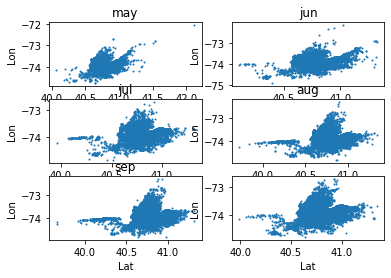

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

data4 = pd.read_csv("./Data/location/uber-raw-data-apr14.csv")
data5 = pd.read_csv("./Data/location/uber-raw-data-may14.csv")
data6 = pd.read_csv("./Data/location/uber-raw-data-jun14.csv")
data7 = pd.read_csv("./Data/location/uber-raw-data-jul14.csv")
data8 = pd.read_csv("./Data/location/uber-raw-data-aug14.csv")
data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")

plt.title("apr")
plt.subplot(321)
plt.scatter(data4.Lat , data4.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("may")
plt.subplot(322)
plt.scatter(data5.Lat , data5.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("jun")
plt.subplot(323)
plt.scatter(data6.Lat , data6.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("jul")
plt.subplot(324)
plt.scatter(data7.Lat , data7.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("aug")
plt.subplot(325)
plt.scatter(data8.Lat , data8.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.title("sep")
plt.subplot(326)
plt.scatter(data9.Lat , data9.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.show()


In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
%matplotlib inline

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [ ]:
DATA_FILE = '../input/uber-raw-data-aug14.csv'
uber_data = pd.read_csv(DATA_FILE)
uber_data.head()

In [ ]:
uber_data.info()

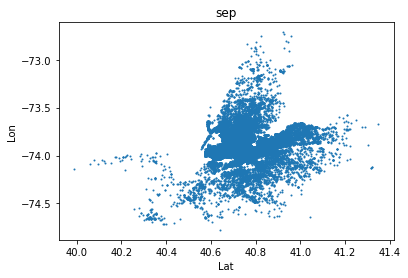

In [33]:
plt.title("sep")
plt.scatter(data9.Lat , data9.Lon, s= 1)
plt.xlabel("Lat")
plt.ylabel("Lon")

plt.show()

In [82]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
print("Shape of the DataFrame: ", data9.shape)

data = data9[["Lat","Lon"]]
data = data.to_numpy()


STdata = StandardScaler().fit(data)
x_STdata = STdata.transform()
db = DBSCAN(eps=0.3, min_samples=5 , metric='euclidean').fit(STdata)
db.labels_



# _db = db.fit_predict(X)
# plt.scatter(db.Lat , db.Lon, s= 1)
# plt.show()

Shape of the DataFrame:  (1028136, 4)


MemoryError: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
print("Shape of the DataFrame: ", data9.shape)

data = data9[["Lat","Lon"]].head(10000)
x = data.to_numpy()

scaler_ss = StandardScaler().fit(x)
x_scaled_ss = scaler_ss.transform(x) 
dbscan = DBSCAN()
clusters_ss = dbscan.fit_predict(x_scaled_ss)
print('np.unique(clusters_ss)\n예측한 레이블:{}'.format(np.unique(clusters_ss))) # [0 ,1]

df = np.hstack([x_scaled_ss, clusters_ss.reshape(-1, 1)]) # x_scaled_ss 오른쪽에 1열 붙이기

df_ftm1 = df[df[:,2]==-1, :] # 클러스터 -1 추출
df_ft0 = df[df[:,2]==0, :] # 클러스터 0 추출
df_ft1 = df[df[:,2]==1, :] # 클러스터 1 추출
df_ft2 = df[df[:,2]==2, :] # 클러스터 2 추출

# matplotlib로 그래프 그리기
plt.scatter(df_ftm1[:, 0], df_ftm1[:, 1], label='cluster -1', cmap='Pairs') # x, y, label, 색상
plt.scatter(df_ft0[:, 0], df_ft0[:, 1], label='cluster 0', cmap='Pairs')
plt.scatter(df_ft1[:, 0], df_ft1[:, 1], label='cluster 1', cmap='Pairs') # x, y, label, 색상
plt.scatter(df_ft2[:, 0], df_ft2[:, 1], label='cluster 2', cmap='Pairs')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()
plt.show()

In [ ]:
def plotResult(X, y, title='클러스터링 결과'):
    plt.scatter(X[y==0, 0], X[y==0, 1], c = 'lightblue' , marker='o', s=40, label='클러스터1')
    plt.scatter(X[y==1, 0], X[y==1, 1], c = 'red' , marker='s', s=40, label='클러스터2')
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pickle as pkl

with open('./DBs.pkl', 'rb')as f:
    df = pkl.load(f)

In [ ]:
df_ftm1 = df[df[:,2]==-1, :] # 클러스터 -1 추출
df_ft0 = df[df[:,2]==0, :] # 클러스터 0 추출
df_ft1 = df[df[:,2]==1, :] # 클러스터 1 추출
df_ft2 = df[df[:,2]==2, :] # 클러스터 2 추출
df_ft3 = df[df[:,2]==3, :] # 클러스터 3 추출
df_ft4 = df[df[:,2]==4, :] # 클러스터 4 추출
df_ft5 = df[df[:,2]==5, :] # 클러스터 5 추출
df_ft6 = df[df[:,2]==6, :] # 클러스터 6 추출
df_ft7 = df[df[:,2]==7, :] # 클러스터 7 추출
df_ft8 = df[df[:,2]==8, :] # 클러스터 8 추출
df_ft9 = df[df[:,2]==9, :] # 클러스터 9 추출
df_ft10 = df[df[:,2]==10, :] # 클러스터 10 추출
df_ft11 = df[df[:,2]==11, :] # 클러스터 11 추출
df_ft12 = df[df[:,2]==12, :] # 클러스터 12 추출
df_ft13 = df[df[:,2]==13, :] # 클러스터 13 추출
df_ft14 = df[df[:,2]==14, :] # 클러스터 14 추출
df_ft15 = df[df[:,2]==15, :] # 클러스터 15 추출
df_ft16 = df[df[:,2]==16, :] # 클러스터 16 추출
df_ft17 = df[df[:,2]==17, :] # 클러스터 17 추출
df_ft18 = df[df[:,2]==18, :] # 클러스터 18 추출
df_ft19 = df[df[:,2]==19, :] # 클러스터 19 추출
df_ft20 = df[df[:,2]==20, :] # 클러스터 20 추출

# matplotlib로 그래프 그리기
# plt.scatter(df_ftm1[:, 0], df_ftm1[:, 1], label='cluster -1', cmap='Pairs', s=1) 
# plt.scatter(df_ft0[:, 0], df_ft0[:, 1], label='cluster 0', cmap='Pairs', s=1)
plt.scatter(df_ft1[:, 0], df_ft1[:, 1], label='cluster 1', cmap='Pairs', s=1)
plt.scatter(df_ft2[:, 0], df_ft2[:, 1], label='cluster 2', cmap='Pairs', s=1)
plt.scatter(df_ft3[:, 0], df_ft3[:, 1], label='cluster 3', cmap='Pairs', s=1)
plt.scatter(df_ft4[:, 0], df_ft4[:, 1], label='cluster 4', cmap='Pairs', s=1)
plt.scatter(df_ft5[:, 0], df_ft5[:, 1], label='cluster 5', cmap='Pairs', s=1)
plt.scatter(df_ft6[:, 0], df_ft6[:, 1], label='cluster 6', cmap='Pairs', s=1)
plt.scatter(df_ft7[:, 0], df_ft7[:, 1], label='cluster 7', cmap='Pairs', s=1)
plt.scatter(df_ft8[:, 0], df_ft8[:, 1], label='cluster 8', cmap='Pairs', s=1)
plt.scatter(df_ft9[:, 0], df_ft9[:, 1], label='cluster 9', cmap='Pairs', s=1)
plt.scatter(df_ft10[:, 0], df_ft10[:, 1], label='cluster 10', cmap='Pairs', s=1)
plt.scatter(df_ft11[:, 0], df_ft11[:, 1], label='cluster 11', cmap='Pairs', s=1)
plt.scatter(df_ft12[:, 0], df_ft12[:, 1], label='cluster 12', cmap='Pairs', s=1)
plt.scatter(df_ft13[:, 0], df_ft13[:, 1], label='cluster 13', cmap='Pairs', s=1)
plt.scatter(df_ft14[:, 0], df_ft14[:, 1], label='cluster 14', cmap='Pairs', s=1)
plt.scatter(df_ft15[:, 0], df_ft15[:, 1], label='cluster 15', cmap='Pairs', s=1)
plt.scatter(df_ft16[:, 0], df_ft16[:, 1], label='cluster 16', cmap='Pairs', s=1)
plt.scatter(df_ft17[:, 0], df_ft17[:, 1], label='cluster 17', cmap='Pairs', s=1)
plt.scatter(df_ft18[:, 0], df_ft18[:, 1], label='cluster 18', cmap='Pairs', s=1)
plt.scatter(df_ft19[:, 0], df_ft19[:, 1], label='cluster 19', cmap='Pairs', s=1)
plt.scatter(df_ft20[:, 0], df_ft20[:, 1], label='cluster 20', cmap='Pairs', s=1)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
data9

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 50, 'linewidths':0}
plt.rcParams["figure.figsize"] = [9,7]
"""!pip install hdbscan"""
import hdbscan

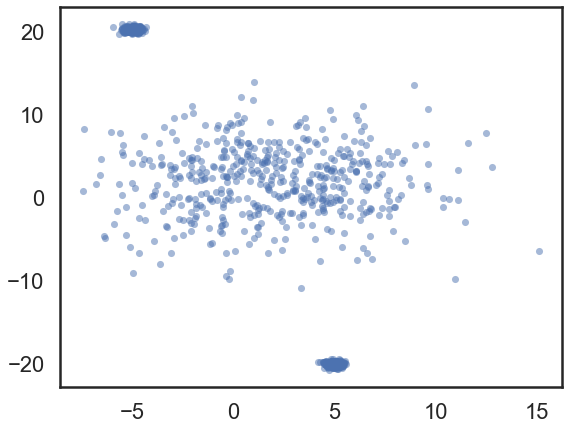

In [49]:
num=500
#moons, _ = data.make_moons(n_samples=num, noise=0.1)
blobs, _ = data.make_blobs(n_samples=num, centers=[(-5,20.25), (5.0, -20.0)], cluster_std=0.25)
blobs2, _ = data.make_blobs(n_samples=num, centers=[(2,2.25)], cluster_std=4)
test_data = np.vstack([ blobs,blobs2])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)
plt.show()

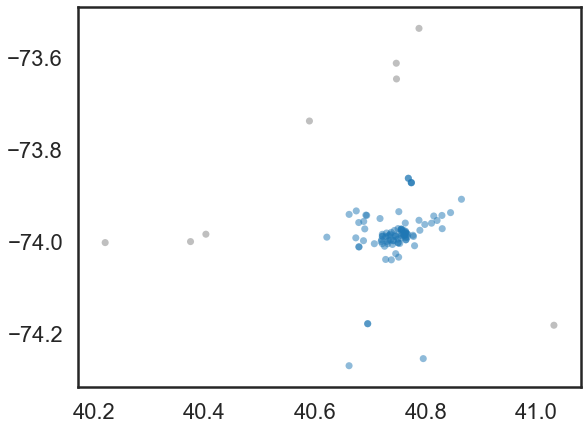

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 50, 'linewidths':0}
plt.rcParams["figure.figsize"] = [9,7]
"""!pip install hdbscan"""
import hdbscan

data9 = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
data = data9[["Lat","Lon"]].head(100)
test_data = data.to_numpy()
db = DBSCAN(eps=0.2, min_samples=10).fit(test_data)
palette = sns.color_palette()
cluster_colors = [palette[col]
                  if col >= 0 else (0.5, 0.5, 0.5) for col in
                  db.labels_]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

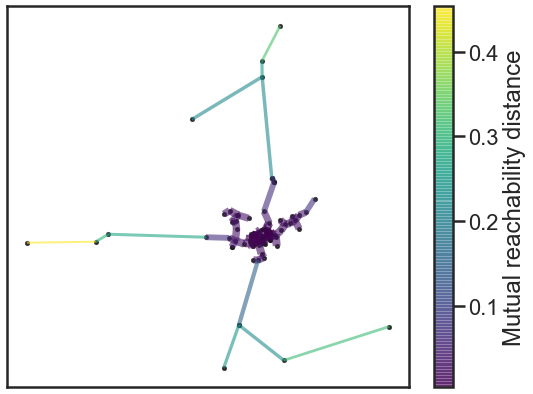

In [10]:
#HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=10, 
                                      edge_linewidth=2)

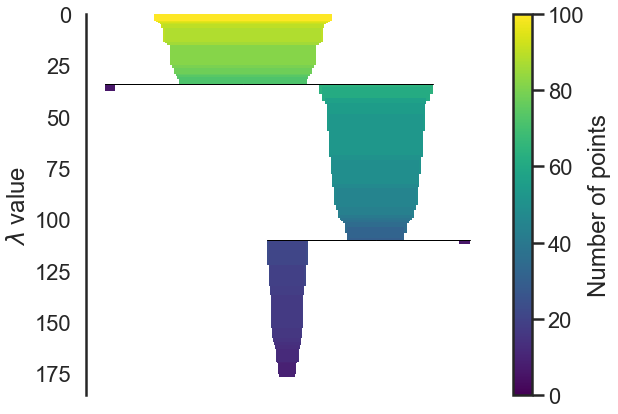

In [11]:
clusterer.condensed_tree_.plot()

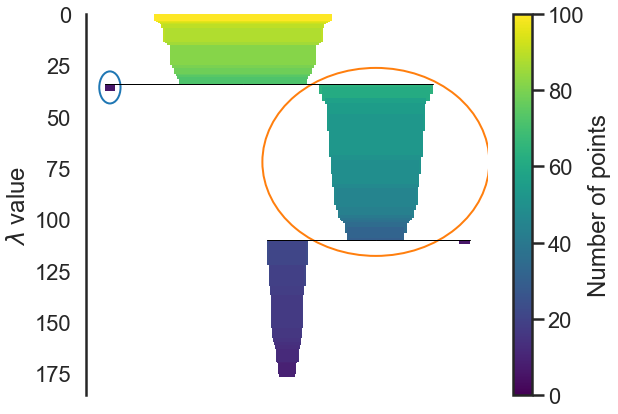

In [12]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


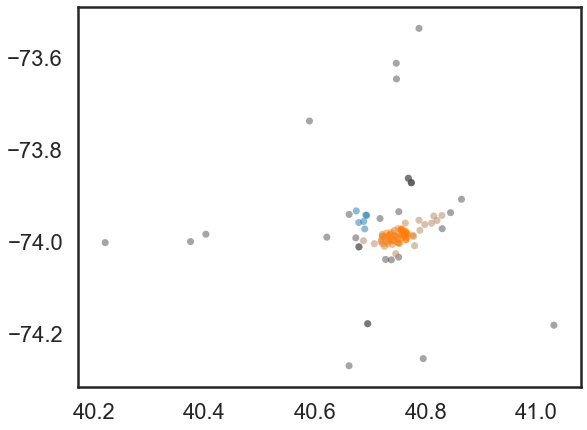

In [13]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.3,0.3,0.3) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

In [70]:
import pandas as pd
data = pd.read_csv("./Data/location/uber-raw-data-sep14.csv")
data['date'] = data['Date/Time'].str.split(' ').str[0]
data['time'] = data['Date/Time'].str.split(' ').str[1]

data['date'] = data['date'].str.split('\/').str[1]
data['time'] = data['time'].str.split(':').str[0]
print(data)

                  Date/Time      Lat      Lon    Base date time
0          9/1/2014 0:01:00  40.2201 -74.0021  B02512    1    0
1          9/1/2014 0:01:00  40.7500 -74.0027  B02512    1    0
2          9/1/2014 0:03:00  40.7559 -73.9864  B02512    1    0
3          9/1/2014 0:06:00  40.7450 -73.9889  B02512    1    0
4          9/1/2014 0:11:00  40.8145 -73.9444  B02512    1    0
...                     ...      ...      ...     ...  ...  ...
1028131  9/30/2014 22:57:00  40.7668 -73.9845  B02764   30   22
1028132  9/30/2014 22:57:00  40.6911 -74.1773  B02764   30   22
1028133  9/30/2014 22:58:00  40.8519 -73.9319  B02764   30   22
1028134  9/30/2014 22:58:00  40.7081 -74.0066  B02764   30   22
1028135  9/30/2014 22:58:00  40.7140 -73.9496  B02764   30   22

[1028136 rows x 6 columns]


In [71]:
clus = []
for i in data['date'].unique() :
    for j in data['time'].unique() :
        clus.append(data[data['time'] == str(j)][data[data['time'] == str(j)]['date'] == str(i)])

In [192]:
len(clus)
for i in clus:
    print(len(i))

699
490
363
333
261
283
330
427
560
765
874
988
1021
1125
1222
1345
1473
1341
1248
1251
1181
1055
818
508
209
111
84
293
518
858
1271
1596
1728
1256
1162
1138
1188
1288
1401
1719
2046
2146
1960
1765
1758
1515
1122
699
284
151
116
204
356
760
1383
1676
1669
1394
1232
1182
1205
1376
1626
2035
2336
2458
2376
2189
2208
1917
1574
924
492
266
180
247
384
760
1368
1753
1801
1455
1384
1399
1422
1552
1874
2346
2493
2735
3087
2808
2617
2446
2074
1417
651
362
233
303
468
827
1333
1707
1859
1609
1485
1432
1445
1713
2057
2323
2655
2961
3151
3157
2738
2793
2763
2294
1706
1122
706
476
348
340
526
710
953
1085
1286
1475
1600
1871
2133
2414
2579
2776
2854
2742
2422
2713
3034
2649
1830
1237
823
566
334
358
387
564
813
1024
1227
1397
1485
1639
1811
1988
2147
2036
1909
1708
1616
1444
1162
629
323
201
157
369
515
910
1222
1673
1725
1288
1204
1211
1190
1345
1577
1895
2092
2254
2221
1971
1823
1487
1117
590
312
194
146
242
407
826
1443
1778
1785
1330
1293
1294
1319
1639
2028
2234
2237
2616
2682
2379
2181
1908

1683
Max label :  13
-1 Label count :  131
0 Label count :  1213
1 Label count :  104
2 Label count :  31
3 Label count :  29
4 Label count :  57
5 Label count :  44
6 Label count :  9
7 Label count :  6
8 Label count :  15
9 Label count :  16
10 Label count :  7
11 Label count :  7
12 Label count :  7
13 Label count :  7


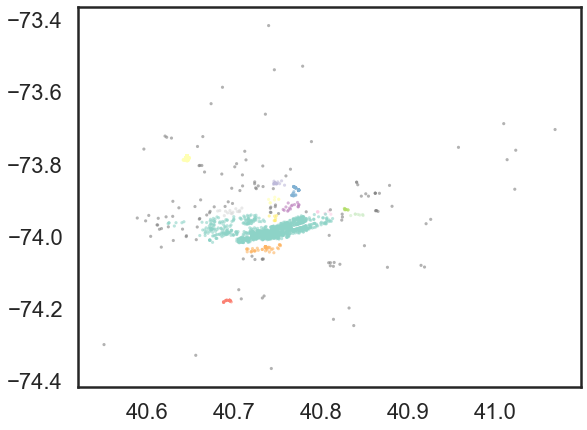

In [320]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.6, 's' : 10, 'linewidths':0} 
plt.rcParams["figure.figsize"] = [9,7]
"""!pip install hdbscan"""
import hdbscan

data9 = clus[496]
print(len(data9))
data = data9[["Lat","Lon"]]
test_data = data.to_numpy()

db = DBSCAN(eps=0.01, min_samples=7).fit(test_data)
palette = sns.color_palette("Set3", 14)
cluster_colors = [palette[col]
                  if col >= 0 else (0.5, 0.5, 0.5) for col in
                  db.labels_]
print("Max label : ", db.labels_.max())

for i in np.unique(db.labels_):
    print(i, "Label count : " ,db.labels_[db.labels_ == i].size)
    
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)



In [323]:
a = 0 
b = 0
for i in range(len(clus) - 1):
    data9 = clus[i]
    print(len(data9), "  ", i)
    
    data = data9[["Lat","Lon"]]
    test_data = data.to_numpy()

    db = DBSCAN(eps=0.01, min_samples=7).fit(test_data)
#     palette = sns.color_palette("deep", 14)
#     cluster_colors = [palette[col]
#                       if col >= 0 else (0.5, 0.5, 0.5) for col in
#                       db.labels_]
    print("Max label : ", db.labels_.max())
    if db.labels_.max() > a:
        a = db.labels_.max()
        b = i
print(a, b)

699    0
Max label :  4
490    1
Max label :  4
363    2
Max label :  2
333    3
Max label :  4
261    4
Max label :  2
283    5
Max label :  4
330    6
Max label :  5
427    7
Max label :  6
560    8
Max label :  5
765    9
Max label :  10
874    10
Max label :  4
988    11
Max label :  6
1021    12
Max label :  6
1125    13
Max label :  5
1222    14
Max label :  8
1345    15
Max label :  8
1473    16
Max label :  7
1341    17
Max label :  8
1248    18
Max label :  6
1251    19
Max label :  6
1181    20
Max label :  5
1055    21
Max label :  7
818    22
Max label :  7
508    23
Max label :  8
209    24
Max label :  4
111    25
Max label :  2
84    26
Max label :  1
293    27
Max label :  1
518    28
Max label :  8
858    29
Max label :  4
1271    30
Max label :  10
1596    31
Max label :  8
1728    32
Max label :  7
1256    33
Max label :  5
1162    34
Max label :  7
1138    35
Max label :  5
1188    36
Max label :  4
1288    37
Max label :  6
1401    38
Max label :  5
1719    39
Max 

Max label :  4
770    320
Max label :  5
969    321
Max label :  7
1123    322
Max label :  7
1359    323
Max label :  6
1323    324
Max label :  5
1512    325
Max label :  8
1587    326
Max label :  7
1786    327
Max label :  9
1903    328
Max label :  6
1870    329
Max label :  9
1796    330
Max label :  9
1624    331
Max label :  7
1521    332
Max label :  7
1237    333
Max label :  7
1012    334
Max label :  6
505    335
Max label :  8
257    336
Max label :  4
172    337
Max label :  1
158    338
Max label :  1
346    339
Max label :  3
571    340
Max label :  7
883    341
Max label :  6
1357    342
Max label :  7
1694    343
Max label :  7
1706    344
Max label :  6
1249    345
Max label :  7
1032    346
Max label :  7
1055    347
Max label :  7
1060    348
Max label :  4
1277    349
Max label :  5
1454    350
Max label :  7
1766    351
Max label :  8
2186    352
Max label :  5
2348    353
Max label :  6
2155    354
Max label :  4
1910    355
Max label :  5
1847    356
Max label 

Max label :  4
2562    641
Max label :  11
2787    642
Max label :  10
2683    643
Max label :  6
2366    644
Max label :  4
2863    645
Max label :  6
2909    646
Max label :  7
2710    647
Max label :  8
2087    648
Max label :  4
1410    649
Max label :  4
982    650
Max label :  6
659    651
Max label :  3
416    652
Max label :  6
477    653
Max label :  5
445    654
Max label :  4
589    655
Max label :  6
803    656
Max label :  5
990    657
Max label :  5
1216    658
Max label :  7
1494    659
Max label :  4
1481    660
Max label :  5
1605    661
Max label :  7
1760    662
Max label :  7
1828    663
Max label :  7
1937    664
Max label :  7
1811    665
Max label :  9
1800    666
Max label :  7
1568    667
Max label :  11
1415    668
Max label :  6
1253    669
Max label :  6
1009    670
Max label :  6
621    671
Max label :  6
329    672
Max label :  3
173    673
Max label :  1
150    674
Max label :  2
386    675
Max label :  5
582    676
Max label :  5
886    677
Max label :  

In [327]:
a = 0 
b = 0
for i in range(len(clus) - 1):
    data9 = clus[i]
    print(len(data9), "  ", i)
    
    data = data9[["Lat","Lon"]]
    test_data = data.to_numpy()
    #HBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
    clusterer.fit(test_data)
    print("Max label : ", clusterer.labels_.max())
    if clusterer.labels_.max() > a:
        a = clusterer.labels_.max()
        b = i
print(a, b)

#     print(np.unique(clusterer.labels_))

#     color_palette = sns.color_palette('deep', 8)
#     cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 
#     cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
#     plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)


699    0
Max label :  4
490    1
Max label :  2
363    2
Max label :  6
333    3
Max label :  2
261    4
Max label :  1
283    5
Max label :  2
330    6
Max label :  1
427    7
Max label :  2
560    8
Max label :  5
765    9
Max label :  8
874    10
Max label :  7
988    11
Max label :  8
1021    12
Max label :  9
1125    13
Max label :  8
1222    14
Max label :  11
1345    15
Max label :  12
1473    16
Max label :  16
1341    17
Max label :  15
1248    18
Max label :  11
1251    19
Max label :  24
1181    20
Max label :  12
1055    21
Max label :  11
818    22
Max label :  12
508    23
Max label :  9
209    24
Max label :  1
111    25
Max label :  1
84    26
Max label :  -1
293    27
Max label :  1
518    28
Max label :  2
858    29
Max label :  3
1271    30
Max label :  10
1596    31
Max label :  8
1728    32
Max label :  8
1256    33
Max label :  7
1162    34
Max label :  8
1138    35
Max label :  6
1188    36
Max label :  9
1288    37
Max label :  10
1401    38
Max label :  7
1719 

Max label :  31
2577    310
Max label :  39
2459    311
Max label :  42
1804    312
Max label :  31
1261    313
Max label :  20
877    314
Max label :  13
550    315
Max label :  8
365    316
Max label :  1
383    317
Max label :  1
419    318
Max label :  1
566    319
Max label :  1
770    320
Max label :  3
969    321
Max label :  5
1123    322
Max label :  7
1359    323
Max label :  11
1323    324
Max label :  7
1512    325
Max label :  9
1587    326
Max label :  11
1786    327
Max label :  30
1903    328
Max label :  25
1870    329
Max label :  25
1796    330
Max label :  13
1624    331
Max label :  17
1521    332
Max label :  30
1237    333
Max label :  14
1012    334
Max label :  10
505    335
Max label :  5
257    336
Max label :  1
172    337
Max label :  1
158    338
Max label :  1
346    339
Max label :  2
571    340
Max label :  9
883    341
Max label :  7
1357    342
Max label :  8
1694    343
Max label :  7
1706    344
Max label :  9
1249    345
Max label :  7
1032    346


Max label :  9
2299    616
Max label :  7
2626    617
Max label :  10
3039    618
Max label :  10
2782    619
Max label :  10
2440    620
Max label :  13
2686    621
Max label :  11
2547    622
Max label :  9
2355    623
Max label :  37
1686    624
Max label :  29
1232    625
Max label :  21
751    626
Max label :  5
527    627
Max label :  4
361    628
Max label :  1
422    629
Max label :  1
530    630
Max label :  5
679    631
Max label :  1
871    632
Max label :  5
1091    633
Max label :  6
1276    634
Max label :  5
1434    635
Max label :  10
1459    636
Max label :  5
1712    637
Max label :  10
1889    638
Max label :  12
2230    639
Max label :  11
2438    640
Max label :  10
2562    641
Max label :  10
2787    642
Max label :  12
2683    643
Max label :  12
2366    644
Max label :  14
2863    645
Max label :  14
2909    646
Max label :  11
2710    647
Max label :  46
2087    648
Max label :  29
1410    649
Max label :  24
982    650
Max label :  16
659    651
Max label :  2

84    1
Max label :  -1
[-1]
-1 Label count :  84


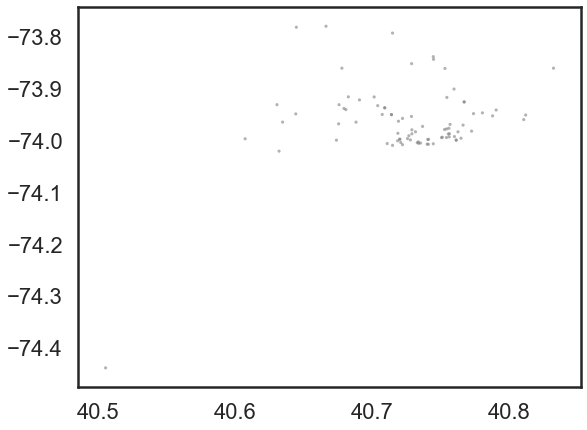

In [331]:
data9 = clus[26]
print(len(data9), "  ", i)

data = data9[["Lat","Lon"]]
test_data = data.to_numpy()
#HBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(test_data)
print("Max label : ", clusterer.labels_.max())
print(np.unique(clusterer.labels_))

color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)

for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)

293    718
Max label :  1
[-1  0  1]


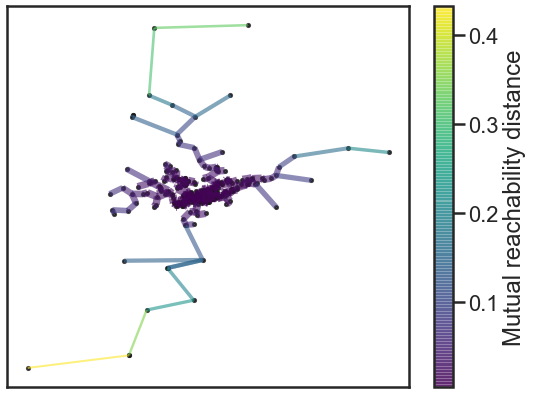

In [328]:

#HBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=11, gen_min_span_tree=True)
clusterer.fit(test_data)
print("Max label : ", clusterer.labels_.max())
print(np.unique(clusterer.labels_))

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=10,
                                      edge_linewidth=2)

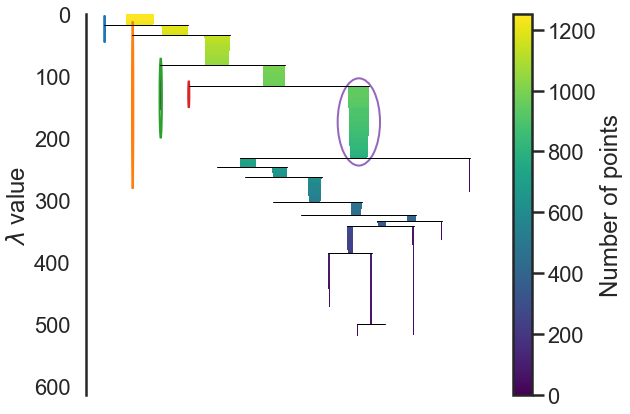

In [291]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

-1 Label count :  186
0 Label count :  13
1 Label count :  30
2 Label count :  53
3 Label count :  25
4 Label count :  944


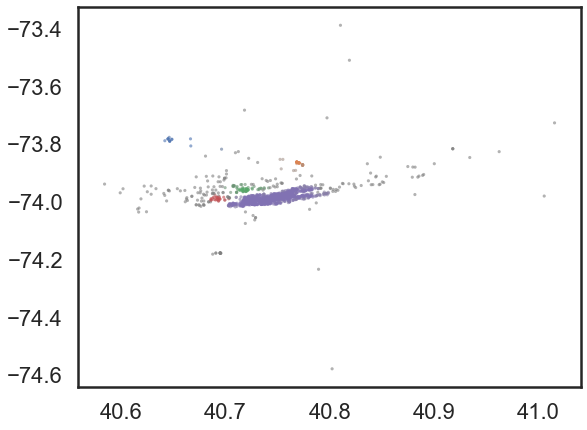

In [292]:
# palette = sns.color_palette("Set3", 12)
# cluster_colors = [sns.desaturate(palette[col], sat)
#                   if col >= 0 else (0.3,0.3,0.3) for col, sat in
#                   zip(clusterer.labels_, clusterer.probabilities_)]
# plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_] 
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*test_data.T, s=10, linewidth=0, c=cluster_member_colors, alpha=0.6)

for i in np.unique(clusterer.labels_):
    print(i, "Label count : " ,clusterer.labels_[clusterer.labels_ == i].size)
    



In [281]:
# data9["label"] = clusterer.labels_
# data9["probability"] = clusterer.probabilities_
# data9
df1 = pd.DataFrame(clusterer.labels_ , columns = ["labels"])
df1["probabilities"] = clusterer.probabilities_
df1

,labels,probabilities
0,-1,0.000000
1,1,1.000000
2,1,1.000000
3,1,0.659868
4,-1,0.000000
...,...,...
869,1,1.000000
870,1,1.000000
871,1,1.000000
872,1,1.000000


In [282]:
a=0
clu = []
for i in range(len(clusterer.labels_)):
    clu.append([clusterer.labels_[i], clusterer.probabilities_[i]])
    if clusterer.probabilities_[i]>=0.9:
        a+=1
print(a)
clu

677


[[-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.6598677577269375],
 [-1, 0.0],
 [-1, 0.0],
 [-1, 0.0],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [-1, 0.0],
 [0, 0.0426910281124368],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.6598677577271383],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [2, 0.5826229838172946],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.6612643979061325],
 [1, 0.991710482475883],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 0.9270082320548311],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [0, 0.042717882885245965],
 [2, 1.0],
 [1, 1.0],
 [1, 1.0],
 [-1, 0.0],
 [1, 1.0],
 [-1, 0.0],
 [1, 0.6145716883240867],
 [1, 1.0],
 [2, 1.0],
 [-1, 0.0],
 [-1, 0.0],
 [1, 1.0],
 [1, 1.0],
 [1, 1.0],
 [0, 0.04225641

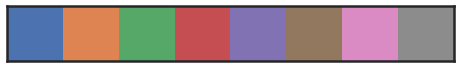

In [91]:
sns.palplot(sns.color_palette('deep', 8))

In [193]:
data = pd.read_csv("./Data/nyc_taxi_data_2014.csv")

C:\Users\Jun\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [227]:
data.tail(50)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14999949,VTS,2014-02-03 21:45:00,2014-02-03 21:59:00,1,3.20,-73.972500,40.758155,1,NaN,-73.976935,40.782577,CRD,13.0,0.5,0.5,4.05,0.00,18.05
14999950,VTS,2014-02-03 21:53:00,2014-02-03 21:59:00,6,1.40,-73.975567,40.776707,1,NaN,-73.957887,40.774517,CSH,7.0,0.5,0.5,0.00,0.00,8.00
14999951,VTS,2014-02-03 21:53:00,2014-02-03 22:00:00,1,2.27,-73.971973,40.753910,1,NaN,-73.951088,40.778957,CRD,9.0,0.5,0.5,1.15,0.00,11.15
14999952,VTS,2014-02-03 21:58:00,2014-02-03 22:00:00,1,0.49,-73.962255,40.763472,1,NaN,-73.966325,40.757810,CSH,4.0,0.5,0.5,0.00,0.00,5.00
14999953,VTS,2014-02-07 07:48:00,2014-02-07 07:53:00,2,0.83,-74.016897,40.709412,1,NaN,-74.011975,40.702767,UNK,5.5,0.0,0.5,1.26,0.00,7.26
14999954,VTS,2014-02-03 21:03:00,2014-02-03 21:11:00,5,2.29,-73.959672,40.758817,1,NaN,-73.948267,40.784167,CRD,9.0,0.5,0.5,2.38,0.00,12.38
14999955,VTS,2014-02-07 06:09:00,2014-02-07 06:14:00,5,1.72,-73.994372,40.750962,1,NaN,-73.974312,40.758795,CSH,7.0,0.0,0.5,0.00,0.00,7.50
14999956,VTS,2014-02-03 21:27:00,2014-02-03 21:33:00,1,2.27,-73.980017,40.754870,1,NaN,-73.997777,40.729480,CRD,8.5,0.5,0.5,2.70,0.00,12.20
14999957,VTS,2014-02-07 07:17:00,2014-02-07 07:22:00,5,0.66,-73.955420,40.777110,1,NaN,-73.951042,40.771627,CRD,5.0,0.0,0.5,1.00,0.00,6.50
14999958,VTS,2014-02-03 21:27:00,2014-02-03 21:35:00,1,2.10,-73.992680,40.720610,1,NaN,-73.977060,40.743150,CSH,8.5,0.5,0.5,0.00,0.00,9.50
